# **Time Series Characterization**

## _ETL Workflow Notebook 4_

## Content:
1. Lag-diagnosis: obtaining autocorrelation (ACF) and partial autocorrelation function (PACF) plots of the time series; 
2. Obtaining the 'd' parameter of ARIMA (p, q, d) model; 
3. Obtaining the best ARIMA (p, q, d) model; 
4. Forecasting with ARIMA model; 
5. Obtaining rolling window statistics of the dataframe; 
6. decomposing seasonality and trend of the time series.

Marco Cesar Prado Soares, Data Scientist Specialist - Bayer Crop Science LATAM
- marcosoares.feq@gmail.com
- marco.soares@bayer.com

In [ ]:
# To install a library (e.g. tensorflow), unmark and run:
# ! pip install tensorflow
# to update a library (e.g. tensorflow), unmark and run:
# ! pip install tensorflow --upgrade
# to update pip, unmark and run:
# ! pip install pip --upgrade
# to show if a library is installed and visualize its information, unmark and run
# (e.g. tensorflow):
# ! pip show tensorflow
# To run a Python file (e.g idsw_etl.py) saved in the notebook's workspace directory,
# unmark and run:
# import idsw_etl
# or:
# import idsw_etl as etl

## **Load Python Libraries in Global Context**

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults

# **Function for mounting Google Drive or S3 (AWS Simple Storage Service) bucket**

In [ ]:
def mount_storage_system (source = 'aws', path_to_store_imported_s3_bucket = '', s3_bucket_name = None, s3_obj_prefix = None):
    
    # source = 'google' for mounting the google drive;
    # source = 'aws' for mounting an AWS S3 bucket.
    
    # THE FOLLOWING PARAMETERS HAVE EFFECT ONLY WHEN source == 'aws'
    
    # path_to_store_imported_s3_bucket: path of the Python environment to which the
    # S3 bucket contents will be imported. If it is None, or if 
    # path_to_store_imported_s3_bucket = '/', bucket will be imported to the root path. 
    # Alternatively, input the path as a string (in quotes). e.g. 
    # path_to_store_imported_s3_bucket = 'copied_s3_bucket'
    
    # s3_bucket_name = None.
    ## This parameter is obbligatory to access an AWS S3 bucket. Substitute it for a string
    # with the bucket's name. e.g. s3_bucket_name = "aws-bucket-1" access a bucket named as
    # "aws-bucket-1"
    
    # s3_obj_prefix = None. Keep it None or as an empty string (s3_obj_key_prefix = '')
    # to import the whole bucket content, instead of a single object from it.
    # Alternatively, set it as a string containing the subfolder from the bucket to import:
    # Suppose that your bucket (admin-created) has four objects with the following object 
    # keys: Development/Projects1.xls; Finance/statement1.pdf; Private/taxdocument.pdf; and
    # s3-dg.pdf. The s3-dg.pdf key does not have a prefix, so its object appears directly 
    # at the root level of the bucket. If you open the Development/ folder, you see 
    # the Projects.xlsx object in it.
    # Check Amazon documentation:
    # https://docs.aws.amazon.com/AmazonS3/latest/userguide/object-keys.html
    
    # In summary, if the path of the file is: 'bucket/my_path/.../file.csv'
    # where 'bucket' is the bucket's name, key_prefix = 'my_path/.../', without the
    # 'file.csv' (file name with extension) last part.
    
    # So, declare the prefix as S3_OBJECT_FOLDER_PREFIX to import only files from
    # a given folder (directory) of the bucket.
    # DO NOT PUT A SLASH before (to the right of) the prefix;
    # DO NOT ADD THE BUCKET'S NAME TO THE right of the prefix:
    # S3_OBJECT_FOLDER_PREFIX = "bucket_directory1/.../bucket_directoryN/"

    # Alternatively, provide the full path of a given file if you want to import only it:
    # S3_OBJECT_FOLDER_PREFIX = "bucket_directory1/.../bucket_directoryN/my_file.ext"
    # where my_file is the file's name, and ext is its extension.


    # Attention: after running this function for fetching AWS Simple Storage System (S3), 
    # your 'AWS Access key ID' and your 'Secret access key' will be requested.
    # The 'Secret access key' will be hidden through dots, so it cannot be visualized or copied by
    # other users. On the other hand, the same is not true for 'Access key ID', the bucket's name 
    # and the prefix. All of these are sensitive information from the organization.
    # Therefore, after importing the information, always remember of cleaning the output of this cell
    # and of removing such information from the strings.
    # Remember that these data may contain privilege for accessing the information, so it should not
    # be used for non-authorized people.

    # Also, remember of deleting the imported files from the workspace after finishing the analysis.
    # The costs for storing the files in S3 is quite inferior than those for storing directly in the
    # workspace. Also, files stored in S3 may be accessed for other users than those with access to
    # the notebook's workspace.
    
    
    if (source == 'google'):
        
        from google.colab import drive
        # Google Colab library must be imported only in case it is
        # going to be used, for avoiding AWS compatibility issues.
        
        print("Associate the Python environment to your Google Drive account, and authorize the access in the opened window.")
        
        drive.mount('/content/drive')
        
        print("Now your Python environment is connected to your Google Drive: the root directory of your environment is now the root of your Google Drive.")
        print("In Google Colab, navigate to the folder icon (\'Files\') of the left navigation menu to find a specific folder or file in your Google Drive.")
        print("Click on the folder or file name and select the elipsis (...) icon on the right of the name to reveal the option \'Copy path\', which will give you the path to use as input for loading objects and files on your Python environment.")
        print("Caution: save your files into different directories of the Google Drive. If files are all saved in a same folder or directory, like the root path, they may not be accessible from your Python environment.")
        print("If you still cannot see the file after moving it to a different folder, reload the environment.")
    
    elif (source == 'aws'):
        
        import os
        import boto3
        # boto3 is AWS S3 Python SDK
        # sagemaker and boto3 libraries must be imported only in case 
        # they are going to be used, for avoiding 
        # Google Colab compatibility issues.
        from getpass import getpass

        # Check if path_to_store_imported_s3_bucket is None. If it is, make it the root directory:
        if ((path_to_store_imported_s3_bucket is None)|(str(path_to_store_imported_s3_bucket) == "/")):
            
            # For the S3 buckets, the path should not start with slash. Assign the empty
            # string instead:
            path_to_store_imported_s3_bucket = ""
            print("Bucket\'s content will be copied to the notebook\'s root directory.")
        
        elif (str(path_to_store_imported_s3_bucket) == ""):
            # Guarantee that the path is the empty string.
            # Avoid accessing the else condition, what would raise an error
            # since the empty string has no character of index 0
            path_to_store_imported_s3_bucket = str(path_to_store_imported_s3_bucket)
            print("Bucket\'s content will be copied to the notebook\'s root directory.")
        
        else:
            # Use the str attribute to guarantee that the path was read as a string:
            path_to_store_imported_s3_bucket = str(path_to_store_imported_s3_bucket)
            
            if(path_to_store_imported_s3_bucket[0] == "/"):
                # the first character is the slash. Let's remove it

                # In AWS, neither the prefix nor the path to which the file will be imported
                # (file from S3 to workspace) or from which the file will be exported to S3
                # (the path in the notebook's workspace) may start with slash, or the operation
                # will not be concluded. Then, we have to remove this character if it is present.

                # The slash is character 0. Then, we want all characters from character 1 (the
                # second) to character len(str(path_to_store_imported_s3_bucket)) - 1, the index
                # of the last character. So, we can slice the string from position 1 to position
                # the slicing syntax is: string[1:] - all string characters from character 1
                # string[:10] - all string characters from character 10-1 = 9 (including 9); or
                # string[1:10] - characters from 1 to 9
                # So, slice the whole string, starting from character 1:
                path_to_store_imported_s3_bucket = path_to_store_imported_s3_bucket[1:]
                # attention: even though strings may be seem as list of characters, that can be
                # sliced, we cannot neither simply assign a character to a given position nor delete
                # a character from a position.

        # Ask the user to provide the credentials:
        ACCESS_KEY = input("Enter your AWS Access Key ID here (in the right). It is the value stored in the field \'Access key ID\' from your AWS user credentials CSV file.")
        print("\n") # line break
        SECRET_KEY = getpass("Enter your password (Secret key) here (in the right). It is the value stored in the field \'Secret access key\' from your AWS user credentials CSV file.")
        
        # The use of 'getpass' instead of 'input' hide the password behind dots.
        # So, the password is not visible by other users and cannot be copied.
        
        print("\n")
        print("WARNING: The bucket\'s name, the prefix, the AWS access key ID, and the AWS Secret access key are all sensitive information, which may grant access to protected information from the organization.\n")
        print("After copying data from S3 to your workspace, remember of removing these information from the notebook, specially if it is going to be shared. Also, remember of removing the files from the workspace.\n")
        print("The cost for storing files in Simple Storage Service is quite inferior than the one for storing directly in SageMaker workspace. Also, files stored in S3 may be accessed for other users than those with access the notebook\'s workspace.\n")

        # Check if the user actually provided the mandatory inputs, instead
        # of putting None or empty string:
        if ((ACCESS_KEY is None) | (ACCESS_KEY == '')):
            print("AWS Access Key ID is missing. It is the value stored in the field \'Access key ID\' from your AWS user credentials CSV file.")
            return "error"
        elif ((SECRET_KEY is None) | (SECRET_KEY == '')):
            print("AWS Secret Access Key is missing. It is the value stored in the field \'Secret access key\' from your AWS user credentials CSV file.")
            return "error"
        elif ((s3_bucket_name is None) | (s3_bucket_name == '')):
            print ("Please, enter a valid S3 Bucket\'s name. Do not add sub-directories or folders (prefixes), only the name of the bucket itself.")
            return "error"
        
        else:
            # Use the str attribute to guarantee that all AWS parameters were properly read as strings, and not as
            # other variables (like integers or floats):
            ACCESS_KEY = str(ACCESS_KEY)
            SECRET_KEY = str(SECRET_KEY)
            s3_bucket_name = str(s3_bucket_name)
        
        if(s3_bucket_name[0] == "/"):
                # the first character is the slash. Let's remove it

                # In AWS, neither the prefix nor the path to which the file will be imported
                # (file from S3 to workspace) or from which the file will be exported to S3
                # (the path in the notebook's workspace) may start with slash, or the operation
                # will not be concluded. Then, we have to remove this character if it is present.

                # So, slice the whole string, starting from character 1 (as did for 
                # path_to_store_imported_s3_bucket):
                s3_bucket_name = s3_bucket_name[1:]

        # Remove any possible trailing (white and tab spaces) spaces
        # That may be present in the string. Use the Python string
        # rstrip method, which is the equivalent to the Trim function:
        # When no arguments are provided, the whitespaces and tabulations
        # are the removed characters
        # https://www.w3schools.com/python/ref_string_rstrip.asp?msclkid=ee2d05c3c56811ecb1d2189d9f803f65
        s3_bucket_name = s3_bucket_name.rstrip()
        ACCESS_KEY = ACCESS_KEY.rstrip()
        SECRET_KEY = SECRET_KEY.rstrip()
        # Since the user manually inputs the parameters ACCESS and SECRET_KEY,
        # it is easy to input whitespaces without noticing that.

        # Now process the non-obbligatory parameter.
        # Check if a prefix was passed as input parameter. If so, we must select only the names that start with
        # The prefix.
        # Example: in the bucket 'my_bucket' we have a directory 'dir1'.
        # In the main (root) directory, we have a file 'file1.json' like: '/file1.json'
        # If we pass the prefix 'dir1', we want only the files that start as '/dir1/'
        # such as: 'dir1/file2.json', excluding the file in the main (root) directory and excluding the files in other
        # directories. Also, we want to eliminate the file names with no extensions, like 'dir1/' or 'dir1/dir2',
        # since these object names represent folders or directories, not files.	

        if (s3_obj_prefix is None):
            print ("No prefix, specific object, or subdirectory provided.") 
            print (f"Then, retrieving all content from the bucket \'{s3_bucket_name}\'.\n")
        elif ((s3_obj_prefix == "/") | (s3_obj_prefix == '')):
            # The root directory in the bucket must not be specified starting with the slash
            # If the root "/" or the empty string '' is provided, make
            # it equivalent to None (no directory)
            s3_obj_prefix = None
            print ("No prefix, specific object, or subdirectory provided.") 
            print (f"Then, retrieving all content from the bucket \'{s3_bucket_name}\'.\n")
    
        else:
            # Since there is a prefix, use the str attribute to guarantee that the path was read as a string:
            s3_obj_prefix = str(s3_obj_prefix)
            
            if(s3_obj_prefix[0] == "/"):
                # the first character is the slash. Let's remove it

                # In AWS, neither the prefix nor the path to which the file will be imported
                # (file from S3 to workspace) or from which the file will be exported to S3
                # (the path in the notebook's workspace) may start with slash, or the operation
                # will not be concluded. Then, we have to remove this character if it is present.

                # So, slice the whole string, starting from character 1 (as did for 
                # path_to_store_imported_s3_bucket):
                s3_obj_prefix = s3_obj_prefix[1:]

            # Remove any possible trailing (white and tab spaces) spaces
            # That may be present in the string. Use the Python string
            # rstrip method, which is the equivalent to the Trim function:
            s3_obj_prefix = s3_obj_prefix.rstrip()
            
            # Store the total characters in the prefix string after removing the initial slash
            # and trailing spaces:
            prefix_len = len(s3_obj_prefix)
            
            print("AWS Access Credentials, and bucket\'s prefix, object or subdirectory provided.\n")	

            
        print ("Starting connection with the S3 bucket.\n")
        
        try:
            # Start S3 client as the object 's3_client'
            s3_client = boto3.resource('s3', aws_access_key_id = ACCESS_KEY, aws_secret_access_key = SECRET_KEY)
        
            print(f"Credentials accepted by AWS. S3 client successfully started.\n")
            # An object 'data_table.xlsx' in the main (root) directory of the s3_bucket is stored in Python environment as:
            # s3.ObjectSummary(bucket_name='bucket_name', key='data_table.xlsx')
            # The name of each object is stored as the attribute 'key' of the object.
        
        except:
            
            print("Failed to connect to AWS Simple Storage Service (S3). Review if your credentials are correct.")
            print("The variable \'access_key\' must be set as the value (string) stored as \'Access key ID\' in your user security credentials CSV file.")
            print("The variable \'secret_key\' must be set as the value (string) stored as \'Secret access key\' in your user security credentials CSV file.")
        
        try:
            # Connect to the bucket specified as 'bucket_name'.
            # The bucket is started as the object 's3_bucket':
            s3_bucket = s3_client.Bucket(s3_bucket_name)
            print(f"Connection with bucket \'{s3_bucket_name}\' stablished.\n")
            
        except:
            
            print("Failed to connect with the bucket, which usually happens when declaring a wrong bucket\'s name.") 
            print("Check the spelling of your bucket_name string and remember that it must be all in lower-case.\n")
                

        # Then, let's obtain a list of all objects in the bucket (list bucket_objects):
        
        bucket_objects_list = []

        # Loop through all objects of the bucket:
        for stored_obj in s3_bucket.objects.all():
            
            # Loop through all elements 'stored_obj' from s3_bucket.objects.all()
            # Which stores the ObjectSummary for all objects in the bucket s3_bucket:
            # Let's store only the key attribute and use the str function
            # to guarantee that all values were stored as strings.
            bucket_objects_list.append(str(stored_obj.key))
        
        # Now start a support list to store only the elements from
        # bucket_objects_list that are not folders or directories
        # (objects with extensions).
        # If a prefix was provided, only files with that prefix should
        # be added:
        support_list = []
        
        for stored_obj in bucket_objects_list:
            
            # Loop through all elements 'stored_obj' from the list
            # bucket_objects_list

            # Check the file extension.
            file_extension = os.path.splitext(stored_obj)[1][1:]
            
            # The os.path.splitext method splits the string into its FIRST dot (".") to
            # separate the file extension from the full path. Example:
            # "C:/dir1/dir2/data_table.csv" is split into:
            # "C:/dir1/dir2/data_table" (root part) and '.csv' (extension part)
            # https://www.geeksforgeeks.org/python-os-path-splitext-method/?msclkid=2d56198fc5d311ec820530cfa4c6d574

            # os.path.splitext(stored_obj) is a tuple of strings: the first is the complete file
            # root with no extension; the second is the extension starting with a point: '.txt'
            # When we set os.path.splitext(stored_obj)[1], we are selecting the second element of
            # the tuple. By selecting os.path.splitext(stored_obj)[1][1:], we are taking this string
            # from the second character (index 1), eliminating the dot: 'txt'


            # Check if the file extension is not an empty string '' (i.e., that it is different from != the empty
            # string:
            if (file_extension != ''):
                    
                    # The extension is different from the empty string, so it is not neither a folder nor a directory
                    # The object is actually a file and may be copied if it satisfies the prefix condition. If there
                    # is no prefix to check, we may simply copy the object to the list.

                    # If there is a prefix, the first characters of the stored_obj must be the prefix:
                    if not (s3_obj_prefix is None):
                        
                        # Check the characters from the position 0 (1st character) to the position
                        # prefix_len - 1. Since a prefix was declared, we want only the objects that this first portion
                        # corresponds to the prefix. string[i:j] slices the string from index i to index j-1
                        # Then, the 1st portion of the string to check is: string[0:(prefix_len)]

                        # Slice the string stored_obj from position 0 (1st character) to position prefix_len - 1,
                        # The position that the prefix should end.
                        obj_name_first_part = (stored_obj)[0:(prefix_len)]
                        
                        # If this first part is the prefix, then append the object to 
                        # support list:
                        if (obj_name_first_part == (s3_obj_prefix)):

                                support_list.append(stored_obj)

                    else:
                        # There is no prefix, so we can simply append the object to the list:
                        support_list.append(stored_obj)

            
        # Make the objects list the support list itself:
        bucket_objects_list = support_list
            
        # Now, bucket_objects_list contains the names of all objects from the bucket that must be copied.

        print("Finished mapping objects to fetch. Now, all these objects from S3 bucket will be copied to the notebook\'s workspace, in the specified directory.\n")
        print(f"A total of {len(bucket_objects_list)} files were found in the specified bucket\'s prefix (\'{s3_obj_prefix}\').")
        print(f"The first file found is \'{bucket_objects_list[0]}\'; whereas the last file found is \'{bucket_objects_list[len(bucket_objects_list) - 1]}\'.")
            
        # Now, let's try copying the files:
            
        try:
            
            # Loop through all objects in the list bucket_objects and copy them to the workspace:
            for copied_object in bucket_objects_list:

                # Select the object in the bucket previously started as 's3_bucket':
                selected_object = s3_bucket.Object(copied_object)
            
                # Now, copy this object to the workspace:
                # Set the new file_path. Notice that by now, copied_object may be a string like:
                # 'dir1/.../dirN/file_name.ext', where dirN is the n-th directory and ext is the file extension.
                # We want only the file_name to joing with the path to store the imported bucket. So, we can use the
                # str.split method specifying the separator sep = '/' to break the string into a list of substrings.
                # The last element from this list will be 'file_name.ext'
                # https://www.w3schools.com/python/ref_string_split.asp?msclkid=135399b6c63111ecada75d7d91add056

                # 1. Break the copied_object full path into the list object_path_list, using the .split method:
                object_path_list = copied_object.split(sep = "/")

                # 2. Get the last element from this list. Since it has length len(object_path_list) and indexing starts from
                # zero, the index of the last element is (len(object_path_list) - 1):
                fetched_object = object_path_list[(len(object_path_list) - 1)]

                # 3. Finally, join the string fetched_object with the new path (path on the notebook's workspace) to finish
                # The new object's file_path:

                file_path = os.path.join(path_to_store_imported_s3_bucket, fetched_object)

                # Download the selected object to the workspace in the specified file_path
                # The parameter Filename must be input with the path of the copied file, including its name and
                # extension. Example Filename = "/my_table.xlsx" copies a xlsx file named 'my_table' to the notebook's main (root)
                # directory
                selected_object.download_file(Filename = file_path)

                print(f"The file \'{fetched_object}\' was successfully copied to notebook\'s workspace.\n")

                
            print("Finished copying the files from the bucket to the notebook\'s workspace. It may take a couple of minutes untill they be shown in SageMaker environment.\n") 
            print("Do not forget to delete these copies after finishing the analysis. They will remain stored in the bucket.\n")


        except:

            # Run this code for any other exception that may happen (no exception error
            # specified, so any exception runs the following code).
            # Check: https://pythonbasics.org/try-except/?msclkid=4f6b4540c5d011ecb1fe8a4566f632a6
            # for seeing how to handle successive exceptions

            print("Attention! The function raised an exception error, which is probably due to the AWS Simple Storage Service (S3) permissions.")
            print("Before running again this function, check this quick guide for configuring the permission roles in AWS.\n")
            print("It is necessary to create an user with full access permissions to interact with S3 from SageMaker. To configure the User, go to the upper ribbon of AWS, click on Services, and select IAM – Identity and Access Management.")
            print("1. In IAM\'s lateral panel, search for \'Users\' in the group of Access Management.")
            print("2. Click on the \'Add users\' button.")
            print("3. Set an user name in the text box \'User name\'.")
            print("Attention: users and S3 buckets cannot be written in upper case. Also, selecting a name already used by an Amazon user or bucket will raise an error message.\n")
            print("4. In the field \'Select type of Access to AWS\'-\'Select type of AWS credentials\' select the option \'Access key - Programmatic access\'. After that, click on the button \'Next: Permissions\'.")
            print("5. In the field \'Set Permissions\', keep the \'Add user to a group\' button marked.")
            print("6. In the field \'Add user to a group\', click on \'Create group\' (alternatively, you can be added to a group already configured or copy the permissions of another user.")
            print("7. In the text box \'Group\'s name\', set a name for the new group of permissions.")
            print("8. In the search bar below (\'Filter politics\'), search for a politics that fill your needs, and check the option button on the left of this politic. The politics \'AmazonS3FullAccess\' grants full access to the S3 content.")
            print("9. Finally, click on \'Create a group\'.")
            print("10. After the group is created, it will appear with a check box marked, over the previous groups. Keep it marked and click on the button \'Next: Tags\'.")
            print("11. Create and note down the Access key ID and Secret access key. You can also download a comma separated values (CSV) file containing the credentials for future use.")
            print("ATTENTION: These parameters are required for accessing the bucket\'s content from any application, including AWS SageMaker.")
            print("12. Click on \'Next: Review\' and review the user credentials information and permissions.")
            print("13. Click on \'Create user\' and click on the download button to download the CSV file containing the user credentials information.")
            print("The headers of the CSV file (the stored fields) is: \'User name, Password, Access key ID, Secret access key, Console login link\'.")
            print("You need both the values indicated as \'Access key ID\' and as \'Secret access key\' to fetch the S3 bucket.")
            print("\n") # line break
            print("After acquiring the necessary user privileges, use the boto3 library to fetch the bucket from the Python code. boto3 is AWS S3 Python SDK.")
            print("For fetching a specific bucket\'s file use the following code:\n")
            print("1. Set a variable \'access_key\' as the value (string) stored as \'Access key ID\' in your user security credentials CSV file.")
            print("2. Set a variable \'secret_key\' as the value (string) stored as \'Secret access key\' in your user security credentials CSV file.")
            print("3. Set a variable \'bucket_name\' as a string containing only the name of the bucket. Do not add subdirectories, folders (prefixes), or file names.")
            print("Example: if your bucket is named \'my_bucket\' and its main directory contains folders like \'folder1\', \'folder2\', etc, do not declare bucket_name = \'my_bucket/folder1\', even if you only want files from folder1.")
            print("ALWAYS declare only the bucket\'s name: bucket_name = \'my_bucket\'.")
            print("4. Set a variable \'file_path\' containing the path from the bucket\'s subdirectories to the file you want to fetch. Include the file name and its extension.")
            print("If the file is stored in the bucket\'s root (main) directory: file_path = \"my_file.ext\".")
            print("If the path of the file in the bucket is: \'dir1/…/dirN/my_file.ext\', where dirN is the N-th subdirectory, and dir1 is a folder or directory of the main (root) bucket\'s directory: file_path = \"dir1/…/dirN/my_file.ext\".")
            print("Also, we say that \'dir1/…/dirN/\' is the file\'s prefix. Notice that the name of the bucket is never declared here as the path for fetching its content from the Python code.")
            print("5. Set a variable named \'new_path\' to store the path of the file copied to the notebook’s workspace. This path must contain the file name and its extension.")
            print("Example: if you want to copy \'my_file.ext\' to the root directory of the notebook’s workspace, set: new_path = \"/my_file.ext\".")
            print("6. Finally, declare the following code, which refers to the defined variables:\n")

            # Let's use triple quotes to declare a formated string
            example_code = """
                import boto3
                # Start S3 client as the object 's3_client'
                s3_client = boto3.resource('s3', aws_access_key_id = access_key, aws_secret_access_key = secret_key)
                # Connect to the bucket specified as 'bucket_name'.
                # The bucket is started as the object 's3_bucket':
                s3_bucket = s3_client.Bucket(bucket_name)
                # Select the object in the bucket previously started as 's3_bucket':
                selected_object = s3_bucket.Object(file_path)
                # Download the selected object to the workspace in the specified file_path
                # The parameter Filename must be input with the path of the copied file, including its name and
                # extension. Example Filename = "/my_table.xlsx" copies a xlsx file named 'my_table' to the notebook's main (root)
                # directory
                selected_object.download_file(Filename = new_path)
                """

            print(example_code)

            print("An object \'my_file.ext\' in the main (root) directory of the s3_bucket is stored in Python environment as:")
            print("""s3.ObjectSummary(bucket_name='bucket_name', key='my_file.ext'""") 
            # triple quotes to keep the internal quotes without using too much backslashes "\" (the ignore next character)
            print("Then, the name of each object is stored as the attribute \'key\' of the object. To view all objects, we can loop through their \'key\' attributes:\n")
            example_code = """
                # Loop through all objects of the bucket:
                for stored_obj in s3_bucket.objects.all():		
                    # Loop through all elements 'stored_obj' from s3_bucket.objects.all()
                    # Which stores the ObjectSummary for all objects in the bucket s3_bucket:
                    # Print the object’s names:
                    print(stored_obj.key)
                    """

            print(example_code)

                
    else:
        
        print("Select a valid source: \'google\' for mounting Google Drive; or \'aws\' for accessing AWS S3 Bucket.")

# **Function for loading the dataframe**

In [ ]:
def load_pandas_dataframe (file_directory_path, file_name_with_extension, load_txt_file_with_json_format = False, how_missing_values_are_registered = None, has_header = True, decimal_separator = '.', txt_csv_col_sep = "comma", load_all_sheets_at_once = False, sheet_to_load = None, json_record_path = None, json_field_separator = "_", json_metadata_prefix_list = None):
    
    # Pandas documentation:
    # pd.read_csv: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html
    # pd.read_excel: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html
    # pd.json_normalize: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.json_normalize.html
    # Python JSON documentation:
    # https://docs.python.org/3/library/json.html
    
    import os
    import json
    import numpy as np
    import pandas as pd
    from pandas import json_normalize
    
    ## WARNING: Use this function to load dataframes stored on Excel (xls, xlsx, xlsm, xlsb, odf, ods and odt), 
    ## JSON, txt, or CSV (comma separated values) files.
    
    # file_directory_path - (string, in quotes): input the path of the directory (e.g. folder path) 
    # where the file is stored. e.g. file_directory_path = "/" or file_directory_path = "/folder"
    
    # FILE_NAME_WITH_EXTENSION - (string, in quotes): input the name of the file with the 
    # extension. e.g. FILE_NAME_WITH_EXTENSION = "file.xlsx", or, 
    # FILE_NAME_WITH_EXTENSION = "file.csv", "file.txt", or "file.json"
    # Again, the extensions may be: xls, xlsx, xlsm, xlsb, odf, ods, odt, json, txt or csv.
    
    # load_txt_file_with_json_format = False. Set load_txt_file_with_json_format = True 
    # if you want to read a file with txt extension containing a text formatted as JSON 
    # (but not saved as JSON).
    # WARNING: if load_txt_file_with_json_format = True, all the JSON file parameters of the 
    # function (below) must be set. If not, an error message will be raised.
    
    # HOW_MISSING_VALUES_ARE_REGISTERED = None: keep it None if missing values are registered as None,
    # empty or np.nan. Pandas automatically converts None to NumPy np.nan objects (floats).
    # This parameter manipulates the argument na_values (default: None) from Pandas functions.
    # By default the following values are interpreted as NaN: ‘’, ‘#N/A’, ‘#N/A N/A’, ‘#NA’, ‘-1.#IND’, 
    #‘-1.#QNAN’, ‘-NaN’, ‘-nan’, ‘1.#IND’, ‘1.#QNAN’, ‘<NA>’, ‘N/A’, ‘NA’, ‘NULL’, ‘NaN’, 
    # ‘n/a’, ‘nan’, ‘null’.

    # If a different denomination is used, indicate it as a string. e.g.
    # HOW_MISSING_VALUES_ARE_REGISTERED = '.' will convert all strings '.' to missing values;
    # HOW_MISSING_VALUES_ARE_REGISTERED = 0 will convert zeros to missing values.

    # If dict passed, specific per-column NA values. For example, if zero is the missing value
    # only in column 'numeric_col', you can specify the following dictionary:
    # how_missing_values_are_registered = {'numeric-col': 0}
    
    
    # has_header = True if the the imported table has headers (row with columns names).
    # Alternatively, has_header = False if the dataframe does not have header.
    
    # DECIMAL_SEPARATOR = '.' - String. Keep it '.' or None to use the period ('.') as
    # the decimal separator. Alternatively, specify here the separator.
    # e.g. DECIMAL_SEPARATOR = ',' will set the comma as the separator.
    # It manipulates the argument 'decimal' from Pandas functions.
    
    # txt_csv_col_sep = "comma" - This parameter has effect only when the file is a 'txt'
    # or 'csv'. It informs how the different columns are separated.
    # Alternatively, txt_csv_col_sep = "comma", or txt_csv_col_sep = "," 
    # for columns separated by comma;
    # txt_csv_col_sep = "whitespace", or txt_csv_col_sep = " " 
    # for columns separated by simple spaces.
    # You can also set a specific separator as string. For example:
    # txt_csv_col_sep = '\s+'; or txt_csv_col_sep = '\t' (in this last example, the tabulation
    # is used as separator for the columns - '\t' represents the tab character).
    
    
    ## Parameters for loading Excel files:
    
    # load_all_sheets_at_once = False - This parameter has effect only when for Excel files.
    # If load_all_sheets_at_once = True, the function will return a list of dictionaries, each
    # dictionary containing 2 key-value pairs: the first key will be 'sheet', and its
    # value will be the name (or number) of the table (sheet). The second key will be 'df',
    # and its value will be the pandas dataframe object obtained from that sheet.
    # This argument has preference over sheet_to_load. If it is True, all sheets will be loaded.
    
    # sheet_to_load - This parameter has effect only when for Excel files.
    # keep sheet_to_load = None not to specify a sheet of the file, so that the first sheet
    # will be loaded.
    # sheet_to_load may be an integer or an string (inside quotes). sheet_to_load = 0
    # loads the first sheet (sheet with index 0); sheet_to_load = 1 loads the second sheet
    # of the file (index 1); sheet_to_load = "Sheet1" loads a sheet named as "Sheet1".
    # Declare a number to load the sheet with that index, starting from 0; or declare a
    # name to load the sheet with that name.
    
    
    ## Parameters for loading JSON files:
    
    # json_record_path (string): manipulate parameter 'record_path' from json_normalize method.
    # Path in each object to list of records. If not passed, data will be assumed to 
    # be an array of records. If a given field from the JSON stores a nested JSON (or a nested
    # dictionary) declare it here to decompose the content of the nested data. e.g. if the field
    # 'books' stores a nested JSON, declare, json_record_path = 'books'
    
    # json_field_separator = "_" (string). Manipulates the parameter 'sep' from json_normalize method.
    # Nested records will generate names separated by sep. 
    # e.g., for json_field_separator = ".", {‘foo’: {‘bar’: 0}} -> foo.bar.
    # Then, if a given field 'main_field' stores a nested JSON with fields 'field1', 'field2', ...
    # the name of the columns of the dataframe will be formed by concatenating 'main_field', the
    # separator, and the names of the nested fields: 'main_field_field1', 'main_field_field2',...
    
    # json_metadata_prefix_list: list of strings (in quotes). Manipulates the parameter 
    # 'meta' from json_normalize method. Fields to use as metadata for each record in resulting 
    # table. Declare here the non-nested fields, i.e., the fields in the principal JSON. They
    # will be repeated in the rows of the dataframe to give the metadata (context) of the rows.
    
    # e.g. Suppose a JSON with the following structure: {'name': 'Mary', 'last': 'Shelley',
    # 'books': [{'title': 'Frankestein', 'year': 1818}, {'title': 'Mathilda ', 'year': 1819},{'title': 'The Last Man', 'year': 1826}]},
    # Here, there are nested JSONs in the field 'books'. The fields that are not nested
    # are 'name' and 'last'.
    # Then, json_record_path = 'books'
    # json_metadata_prefix_list = ['name', 'last']
    
    
    # Create the complete file path:
    file_path = os.path.join(file_directory_path, file_name_with_extension)
    # Extract the file extension
    file_extension = os.path.splitext(file_path)[1][1:]
    # os.path.splitext(file_path) is a tuple of strings: the first is the complete file
    # root with no extension; the second is the extension starting with a point: '.txt'
    # When we set os.path.splitext(file_path)[1], we are selecting the second element of
    # the tuple. By selecting os.path.splitext(file_path)[1][1:], we are taking this string
    # from the second character (index 1), eliminating the dot: 'txt'
    
    # Check if the decimal separator is None. If it is, set it as '.' (period):
    if (decimal_separator is None):
        decimal_separator = '.'
    
    if ((file_extension == 'txt') | (file_extension == 'csv')): 
        # The operator & is equivalent to 'And' (intersection).
        # The operator | is equivalent to 'Or' (union).
        # pandas.read_csv method must be used.
        if (load_txt_file_with_json_format == True):
            
            print("Reading a txt file containing JSON parsed data. A reading error will be raised if you did not set the JSON parameters.\n")
            
            with open(file_path, 'r') as opened_file:
                # 'r' stands for read mode; 'w' stands for write mode
                # read the whole file as a string named 'file_full_text'
                file_full_text = opened_file.read()
                # if we used the readlines() method, we would be reading the
                # file by line, not the whole text at once.
                # https://stackoverflow.com/questions/8369219/how-to-read-a-text-file-into-a-string-variable-and-strip-newlines?msclkid=a772c37bbfe811ec9a314e3629df4e1e
                # https://www.tutorialkart.com/python/python-read-file-as-string/#:~:text=example.py%20%E2%80%93%20Python%20Program.%20%23open%20text%20file%20in,and%20prints%20it%20to%20the%20standard%20output.%20Output.?msclkid=a7723a1abfe811ecb68bba01a2b85bd8
                
            #Now, file_full_text is a string containing the full content of the txt file.
            json_file = json.loads(file_full_text)
            # json.load() : This method is used to parse JSON from URL or file.
            # json.loads(): This method is used to parse string with JSON content.
            # e.g. .json.loads() must be used to read a string with JSON and convert it to a flat file
            # like a dataframe.
            # check: https://www.pythonpip.com/python-tutorials/how-to-load-json-file-using-python/#:~:text=The%20json.load%20%28%29%20is%20used%20to%20read%20the,and%20alter%20data%20in%20our%20application%20or%20system.
            dataset = json_normalize(json_file, record_path = json_record_path, sep = json_field_separator, meta = json_metadata_prefix_list)
        
        else:
            # Not a JSON txt
        
            if (has_header == True):

                if ((txt_csv_col_sep == "comma") | (txt_csv_col_sep == ",")):

                    dataset = pd.read_csv(file_path, na_values = how_missing_values_are_registered, verbose = True, parse_dates = True, infer_datetime_format = True, decimal = decimal_separator)
                    # verbose = True for showing number of NA values placed in non-numeric columns.
                    #  parse_dates = True: try parsing the index; infer_datetime_format = True : If True and parse_dates is enabled, pandas will attempt to infer the format of the datetime strings in 
                    # the columns, and if it can be inferred, switch to a faster method of parsing them. In some cases this can increase the 
                    # parsing speed by 5-10x.

                elif ((txt_csv_col_sep == "whitespace") | (txt_csv_col_sep == " ")):

                    dataset = pd.read_csv(file_path, delim_whitespace = True, na_values = how_missing_values_are_registered, verbose = True, parse_dates = True, infer_datetime_format = True, decimal = decimal_separator)
                    
                    
                else:
                    
                    try:
                        
                        # Try using the character specified as the argument txt_csv_col_sep:
                        dataset = pd.read_csv(file_path, sep = txt_csv_col_sep, na_values = how_missing_values_are_registered, verbose = True, parse_dates = True, infer_datetime_format = True, decimal = decimal_separator)
                    
                    except:
                        # An error was raised, the separator is not valid
                        print(f"Enter a valid column separator for the {file_extension} file, like: \'comma\' or \'whitespace\'.")


            else:
                # has_header == False

                if ((txt_csv_col_sep == "comma") | (txt_csv_col_sep == ",")):

                    dataset = pd.read_csv(file_path, header = None, na_values = how_missing_values_are_registered, verbose = True, parse_dates = True, infer_datetime_format = True, decimal = decimal_separator)

                    
                elif ((txt_csv_col_sep == "whitespace") | (txt_csv_col_sep == " ")):

                    dataset = pd.read_csv(file_path, delim_whitespace = True, header = None, na_values = how_missing_values_are_registered, verbose = True, parse_dates = True, infer_datetime_format = True, decimal = decimal_separator)
                    
                    
                else:
                    
                    try:
                        
                        # Try using the character specified as the argument txt_csv_col_sep:
                        dataset = pd.read_csv(file_path, sep = txt_csv_col_sep, header = None, na_values = how_missing_values_are_registered, verbose = True, parse_dates = True, infer_datetime_format = True, decimal = decimal_separator)
                    
                    except:
                        # An error was raised, the separator is not valid
                        print(f"Enter a valid column separator for the {file_extension} file, like: \'comma\' or \'whitespace\'.")

    elif (file_extension == 'json'):
        
        with open(file_path, 'r') as opened_file:
            
            json_file = json.load(opened_file)
            # The structure json_file = json.load(open(file_path)) relies on the GC to close the file. That's not a 
            # good idea: If someone doesn't use CPython the garbage collector might not be using refcounting (which 
            # collects unreferenced objects immediately) but e.g. collect garbage only after some time.
            # Since file handles are closed when the associated object is garbage collected or closed 
            # explicitly (.close() or .__exit__() from a context manager) the file will remain open until 
            # the GC kicks in.
            # Using 'with' ensures the file is closed as soon as the block is left - even if an exception 
            # happens inside that block, so it should always be preferred for any real application.
            # source: https://stackoverflow.com/questions/39447362/equivalent-ways-to-json-load-a-file-in-python
            
        # json.load() : This method is used to parse JSON from URL or file.
        # json.loads(): This method is used to parse string with JSON content.
        # Then, json.load for a .json file
        # and json.loads for text file containing json
        # check: https://www.pythonpip.com/python-tutorials/how-to-load-json-file-using-python/#:~:text=The%20json.load%20%28%29%20is%20used%20to%20read%20the,and%20alter%20data%20in%20our%20application%20or%20system.   
        dataset = json_normalize(json_file, record_path = json_record_path, sep = json_field_separator, meta = json_metadata_prefix_list)
    
    else:
        # If it is not neither a csv nor a txt file, let's assume it is one of different
        # possible Excel files.
        print("Excel file inferred. If an error message is shown, check if a valid file extension was used: \'xlsx\', \'xls\', etc.\n")
        # For Excel type files, Pandas automatically detects the decimal separator and requires only the parameter parse_dates.
        # Firstly, the argument infer_datetime_format was present on read_excel function, but was removed.
        # From version 1.4 (beta, in 10 May 2022), it will be possible to pass the parameter 'decimal' to
        # read_excel function for detecting decimal cases in strings. For numeric variables, it is not needed, though
        
        if (load_all_sheets_at_once == True):
            
            # Corresponds to setting sheet_name = None
            
            if (has_header == True):
                
                xlsx_doc = pd.read_excel(file_path, sheet_name = None, na_values = how_missing_values_are_registered, verbose = True, parse_dates = True)
                # verbose = True for showing number of NA values placed in non-numeric columns.
                #  parse_dates = True: try parsing the index; infer_datetime_format = True : If True and parse_dates is enabled, pandas will attempt to infer the format of the datetime strings in 
                # the columns, and if it can be inferred, switch to a faster method of parsing them. In some cases this can increase the 
                # parsing speed by 5-10x.
                
            else:
                #No header
                xlsx_doc = pd.read_excel(file_path, sheet_name = None, header = None, na_values = how_missing_values_are_registered, verbose = True, parse_dates = True)
            
            # xlsx_doc is a dictionary containing the sheet names as keys, and dataframes as items.
            # Let's convert it to the desired format.
            # Dictionary dict, dict.keys() is the array of keys; dict.values() is an array of the values;
            # and dict.items() is an array of tuples with format ('key', value)
            
            # Create a list of returned datasets:
            list_of_datasets = []
            
            # Let's iterate through the array of tuples. The first element returned is the key, and the
            # second is the value
            for sheet_name, dataframe in (xlsx_doc.items()):
                # sheet_name = key; dataframe = value
                # Define the dictionary with the standard format:
                df_dict = {'sheet': sheet_name,
                            'df': dataframe}
                
                # Add the dictionary to the list:
                list_of_datasets.append(df_dict)
            
            print("\n")
            print(f"A total of {len(list_of_datasets)} dataframes were retrieved from the Excel file.\n")
            print(f"The dataframes correspond to the following Excel sheets: {list(xlsx_doc.keys())}\n")
            print("Returning a list of dictionaries. Each dictionary contains the key \'sheet\', with the original sheet name; and the key \'df\', with the Pandas dataframe object obtained.\n")
            print(f"Check the 10 first rows of the dataframe obtained from the first sheet, named {list_of_datasets[0]['sheet']}:\n")
            
            try:
                # only works in Jupyter Notebook:
                from IPython.display import display
                display((list_of_datasets[0]['df']).head(10))
            
            except: # regular mode
                print((list_of_datasets[0]['df']).head(10))
            
            return list_of_datasets
            
        elif (sheet_to_load is not None):        
        #Case where the user specifies which sheet of the Excel file should be loaded.
            
            if (has_header == True):
                
                dataset = pd.read_excel(file_path, sheet_name = sheet_to_load, na_values = how_missing_values_are_registered, verbose = True, parse_dates = True)
                # verbose = True for showing number of NA values placed in non-numeric columns.
                #  parse_dates = True: try parsing the index; infer_datetime_format = True : If True and parse_dates is enabled, pandas will attempt to infer the format of the datetime strings in 
                # the columns, and if it can be inferred, switch to a faster method of parsing them. In some cases this can increase the 
                # parsing speed by 5-10x.
                
            else:
                #No header
                dataset = pd.read_excel(file_path, sheet_name = sheet_to_load, header = None, na_values = how_missing_values_are_registered, verbose = True, parse_dates = True)
                
        
        else:
            #No sheet specified
            if (has_header == True):
                
                dataset = pd.read_excel(file_path, na_values = how_missing_values_are_registered, verbose = True, parse_dates = True)
                
            else:
                #No header
                dataset = pd.read_excel(file_path, header = None, na_values = how_missing_values_are_registered, verbose = True, parse_dates = True)
                
    print(f"Dataset extracted from {file_path}. Check the 10 first rows of this dataframe:\n")
    
    try:
        # only works in Jupyter Notebook:
        from IPython.display import display
        display(dataset.head(10))
            
    except: # regular mode
        print(dataset.head(10))
    
    return dataset

# **Function for converting JSON object to dataframe**
- Objects may be:
    - String with JSON formatted text;
    - List with nested dictionaries (JSON formatted);
    - Each dictionary may contain nested dictionaries, or nested lists of dictionaries (nested JSON).

In [ ]:
def json_obj_to_pandas_dataframe (json_obj_to_convert, json_obj_type = 'list', json_record_path = None, json_field_separator = "_", json_metadata_prefix_list = None):
    
    import json
    import pandas as pd
    from pandas import json_normalize
    
    # JSON object in terms of Python structure: list of dictionaries, where each value of a
    # dictionary may be a dictionary or a list of dictionaries (nested structures).
    # example of highly nested structure saved as a list 'json_formatted_list'. Note that the same
    # structure could be declared and stored into a string variable. For instance, if you have a txt
    # file containing JSON, you could read the txt and save its content as a string.
    # json_formatted_list = [{'field1': val1, 'field2': {'dict_val': dict_val}, 'field3': [{
    # 'nest1': nest_val1}, {'nest2': nestval2}]}, {'field1': val1, 'field2': {'dict_val': dict_val}, 
    # 'field3': [{'nest1': nest_val1}, {'nest2': nestval2}]}]    

    # json_obj_type = 'list', in case the object was saved as a list of dictionaries (JSON format)
    # json_obj_type = 'string', in case it was saved as a string (text) containing JSON.

    # json_obj_to_convert: object containing JSON, or string with JSON content to parse.
    # Objects may be: string with JSON formatted text;
    # list with nested dictionaries (JSON formatted);
    # dictionaries, possibly with nested dictionaries (JSON formatted).
    
    # https://docs.python.org/3/library/json.html
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.json_normalize.html#pandas.json_normalize
    
    # json_record_path (string): manipulate parameter 'record_path' from json_normalize method.
    # Path in each object to list of records. If not passed, data will be assumed to 
    # be an array of records. If a given field from the JSON stores a nested JSON (or a nested
    # dictionary) declare it here to decompose the content of the nested data. e.g. if the field
    # 'books' stores a nested JSON, declare, json_record_path = 'books'
    
    # json_field_separator = "_" (string). Manipulates the parameter 'sep' from json_normalize method.
    # Nested records will generate names separated by sep. 
    # e.g., for json_field_separator = ".", {‘foo’: {‘bar’: 0}} -> foo.bar.
    # Then, if a given field 'main_field' stores a nested JSON with fields 'field1', 'field2', ...
    # the name of the columns of the dataframe will be formed by concatenating 'main_field', the
    # separator, and the names of the nested fields: 'main_field_field1', 'main_field_field2',...
    
    # json_metadata_prefix_list: list of strings (in quotes). Manipulates the parameter 
    # 'meta' from json_normalize method. Fields to use as metadata for each record in resulting 
    # table. Declare here the non-nested fields, i.e., the fields in the principal JSON. They
    # will be repeated in the rows of the dataframe to give the metadata (context) of the rows.
    
    # e.g. Suppose a JSON with the following structure: {'name': 'Mary', 'last': 'Shelley',
    # 'books': [{'title': 'Frankestein', 'year': 1818}, {'title': 'Mathilda ', 'year': 1819},{'title': 'The Last Man', 'year': 1826}]},
    # Here, there are nested JSONs in the field 'books'. The fields that are not nested
    # are 'name' and 'last'.
    # Then, json_record_path = 'books'
    # json_metadata_prefix_list = ['name', 'last']

    
    if (json_obj_type == 'string'):
        # Use the json.loads method to convert the string to json
        json_file = json.loads(json_obj_to_convert)
        # json.load() : This method is used to parse JSON from URL or file.
        # json.loads(): This method is used to parse string with JSON content.
        # e.g. .json.loads() must be used to read a string with JSON and convert it to a flat file
        # like a dataframe.
        # check: https://www.pythonpip.com/python-tutorials/how-to-load-json-file-using-python/#:~:text=The%20json.load%20%28%29%20is%20used%20to%20read%20the,and%20alter%20data%20in%20our%20application%20or%20system.
    
    elif (json_obj_type == 'list'):
        
        # make the json_file the object itself:
        json_file = json_obj_to_convert
    
    else:
        print ("Enter a valid JSON object type: \'list\', in case the JSON object is a list of dictionaries in JSON format; or \'string\', if the JSON is stored as a text (string variable).")
        return "error"
    
    dataset = json_normalize(json_file, record_path = json_record_path, sep = json_field_separator, meta = json_metadata_prefix_list)
    
    print(f"JSON object converted to a flat dataframe object. Check the 10 first rows of this dataframe:\n")
    
    try:
        # only works in Jupyter Notebook:
        from IPython.display import display
        display(dataset.head(10))
            
    except: # regular mode
        print(dataset.head(10))
    
    return dataset

# **Function for calculating differences between successive timestamps (delay)**
- Use this function for creating a column containing differences between two successive timestamps from a same column.

In [ ]:
def CALCULATE_DELAY (df, timestamp_tag_column, new_timedelta_column_name  = None, returned_timedelta_unit = None, return_avg_delay = True):
    
    import numpy as np
    import pandas as pd
    
    #THIS FUNCTION CALCULATES THE DIFFERENCE (timedelta - delay) BETWEEN TWO SUCCESSIVE
    # Timestamps from a same column
    
    #df: dataframe containing the two timestamp columns.
    #timestamp_tag_column: string containing the name of the column with the timestamps
    
    #new_timedelta_column_name: name of the new column. If no value is provided, the default
    #name [timestamp_tag_column1]-[timestamp_tag_column2] will be given:
    
    # return_avg_delay = True will print and return the value of the average delay.
    # return_avg_delay = False will omit this information
    
    if (new_timedelta_column_name is None):
        
        #apply the default name:
        new_timedelta_column_name = "time_delay"
    
    #Pandas Timedelta class: applicable to timedelta objects
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timedelta.html
    #The delta method from the Timedelta class converts returns the timedelta in
    #nanoseconds, guaranteeing the internal compatibility:
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timedelta.delta.html#pandas.Timedelta.delta
    
    #returned_timedelta_unit: unit of the new column. If no value is provided, the unit will be
    # considered as nanoseconds. 
    # POSSIBLE VALUES FOR THE TIMEDELTA UNIT:
    #'year', 'month', 'day', 'hour', 'minute', 'second'.
    
    # START: CONVERT ALL TIMESTAMPS/DATETIMES/STRINGS TO pandas.Timestamp OBJECTS.
    # This will prevent any compatibility problems.
    
    #The pd.Timestamp function can handle a single timestamp per call. Then, we must
    # loop trough the series, and apply the function to each element.
    
    # Create dataframe local copy to manipulate, avoiding that Pandas operates on
    # the original object; or that Pandas tries to set values on slices or copies,
    # resulting in unpredictable results.
    # Use the copy method to effectively create a second object with the same properties
    # of the input parameters, but completely independent from it.
    DATASET = df.copy(deep = True)
    
    # 1. Start a list to store the Pandas timestamps:
    timestamp_list = []
    
    # 2. Loop through each element of the timestamp column, and apply the function
    # to guarantee that all elements are Pandas timestamps
    
    for timestamp in DATASET[timestamp_tag_column]:
        #Access each element 'timestamp' of the series df[timestamp_tag_column1]
        timestamp_list.append(pd.Timestamp(timestamp, unit = 'ns'))
    
    # 3. Save the list as the column timestamp_tag_column itself:
    DATASET[timestamp_tag_column] = timestamp_list
    
    # 4. Sort the dataframe in ascending order of timestamps:
    DATASET = DATASET.sort_values(by = timestamp_tag_column, ascending = True)
    # Reset indices:
    DATASET = DATASET.reset_index(drop = True)
    
    # Now, let's create a list of the following timestamps
    following_timestamp = []
    # Let's skip the index 0, correspondent to the first timestamp:
    
    for i in range (1, len(timestamp_list)):
        
        # this loop goes from i = 1 to i = len(timestamp_list) - 1, the last index
        # of the list. If we simply declared range (len(timestamp_list)), the loop
        # will start from 0, the default
        
        #append the element from timestamp_list to following_timestamp:
        following_timestamp.append(timestamp_list[i])
    
    # Notice that this list has one element less than the original list, because we started
    # copying from index 1, not 0. Therefore, let's repeat the last element of timestamp_list:
    following_timestamp.append(timestamp_list[i])
    # Notice that, once we did not restarted the variable i, it keeps its last value obtained
    # during the loop, correspondent to the index of the last element.
    # Now, let's store it into a column (series) of the dataframe:
    timestamp_tag_column2 = timestamp_tag_column + "_delayed"
    DATASET[timestamp_tag_column2] = following_timestamp
    
    # Pandas Timestamps can be subtracted to result into a Pandas Timedelta.
    # We will apply the delta method from Pandas Timedeltas.
    
    # 4. Create a timedelta object as the difference between the timestamps:
    
    # NOTICE: Even though a list could not be submitted to direct operations like
    # sum, subtraction and multiplication, the series and NumPy arrays can. When we
    # copied the list as a new column on the dataframes, we converted the lists to series
    # called df[timestamp_tag_column1] and df[timestamp_tag_column2]. These two series now
    # can be submitted to direct operations.
    
    # Delay = next measurement (tag_column2, timestamp higher) - current measurement
    # (tag_column2, timestamp lower). Since we repeated the last timestamp twice,
    # in the last row it will be subtracted from itself, resulting in zero.
    # This is the expected, since we do not have a delay yet
    timedelta_obj = DATASET[timestamp_tag_column2] - DATASET[timestamp_tag_column]
    
    #This timedelta_obj is a series of timedelta64 objects. The Pandas Timedelta function
    # can process only one element of the series in each call. Then, we must loop through
    # the series to obtain the float values in nanoseconds. Even though this loop may 
    # look unecessary, it uses the Delta method to guarantee the internal compatibility.
    # Then, no errors due to manipulation of timestamps with different resolutions, or
    # due to the presence of global variables, etc. will happen. This is the safest way
    # to manipulate timedeltas.
    
    #5. Create an empty list to store the timedeltas in nanoseconds
    TimedeltaList = []
    
    #6. Loop through each timedelta_obj and convert it to nanoseconds using the Delta
    # method. Both pd.Timedelta function and the delta method can be applied to a 
    # a single object.
    #len(timedelta_obj) is the total of timedeltas present.
    
    for i in range(len(timedelta_obj)):
        
        #This loop goes from i = 0 to i = [len(timedelta_obj) - 1], so that
        #all indices are evaluated.
        
        #append the element resultant from the delta method application on the
        # i-th element of the list timedelta_obj, i.e., timedelta_obj[i].
        TimedeltaList.append(pd.Timedelta(timedelta_obj[i]).delta)
    
    #Notice that the loop is needed because Pandas cannot handle a series/list of
    #Timedelta objects simultaneously. It can manipulate a single object
    # in each call or iteration.
    
    #Now the list contains the timedeltas in nanoseconds and guarantees internal
    #compatibility.
    # The delta method converts the Timedelta object to an integer number equals to the
    # value of the timedelta in nanoseconds. Then we are now dealing with numbers, not
    # with timestamps.
    # Even though some steps seem unecessary, they are added to avoid errors and bugs
    # hard to identify, resultant from a timestamp assigned to the wrong type of
    # object.
    
    #The list is not as the series (columns) and arrays: it cannot be directly submitted to 
    # operations like sum, division, and multiplication. For doing so, we can loop through 
    # each element, what would be the case for using the Pandas Timestamp and Timedelta 
    # functions, which can only manipulate one object per call.
    # For simpler operations like division, we can convert the list to a NumPy array and
    # submit the entire array to the operation at the same time, avoiding the use of 
    # memory consuminh iterative methods.
    
    #Convert the timedelta list to a NumPy array:
    # Notice that we could have created a column with the Timedeltalist, so that it would
    # be converted to a series. On the other hand, we still did not defined the name of the
    # new column. So, it is easier to simply convert it to a NumPy array, and then copy
    # the array as a new column.
    TimedeltaList = np.array(TimedeltaList)
    
    #Convert the array to the desired unit by dividing it by the proper factor:
    
    if (returned_timedelta_unit == 'year'):
        
        #1. Convert the list to seconds (1 s = 10**9 ns, where 10**9 represents
        #the potentiation operation in Python, i.e., 10^9. e.g. 10**2 = 100):
        TimedeltaList = TimedeltaList / (10**9) #in seconds
        
        #2. Convert it to minutes (1 min = 60 s):
        TimedeltaList = TimedeltaList / 60.0 #in minutes
        
        #3. Convert it to hours (1 h = 60 min):
        TimedeltaList = TimedeltaList / 60.0 #in hours
        
        #4. Convert it to days (1 day = 24 h):
        TimedeltaList = TimedeltaList / 24.0 #in days
        
        #5. Convert it to years. 1 year = 365 days + 6 h = 365 days + 6/24 h/(h/day)
        # = (365 + 1/4) days = 365.25 days
        
        TimedeltaList = TimedeltaList / (365.25) #in years
        
        #The .0 after the numbers guarantees a float division.
        
        print("Returned timedelta in years. Considered 1 year = 365 days + 6 h.\n")
    
    
    elif (returned_timedelta_unit == 'month'):
        
        #1. Convert the list to seconds (1 s = 10**9 ns, where 10**9 represents
        #the potentiation operation in Python, i.e., 10^9. e.g. 10**2 = 100):
        TimedeltaList = TimedeltaList / (10**9) #in seconds
        
        #2. Convert it to minutes (1 min = 60 s):
        TimedeltaList = TimedeltaList / 60.0 #in minutes
        
        #3. Convert it to hours (1 h = 60 min):
        TimedeltaList = TimedeltaList / 60.0 #in hours
        
        #4. Convert it to days (1 day = 24 h):
        TimedeltaList = TimedeltaList / 24.0 #in days
        
        #5. Convert it to months. Consider 1 month = 30 days
        
        TimedeltaList = TimedeltaList / (30.0) #in months
        
        #The .0 after the numbers guarantees a float division.
        
        print("Returned timedelta in months. Considered 1 month = 30 days.\n")
        
    
    elif (returned_timedelta_unit == 'day'):
        
        #1. Convert the list to seconds (1 s = 10**9 ns, where 10**9 represents
        #the potentiation operation in Python, i.e., 10^9. e.g. 10**2 = 100):
        TimedeltaList = TimedeltaList / (10**9) #in seconds
        
        #2. Convert it to minutes (1 min = 60 s):
        TimedeltaList = TimedeltaList / 60.0 #in minutes
        
        #3. Convert it to hours (1 h = 60 min):
        TimedeltaList = TimedeltaList / 60.0 #in hours
        
        #4. Convert it to days (1 day = 24 h):
        TimedeltaList = TimedeltaList / 24.0 #in days
        
        #The .0 after the numbers guarantees a float division.
        
        print("Returned timedelta in days.\n")
        
    
    elif (returned_timedelta_unit == 'hour'):
        
        #1. Convert the list to seconds (1 s = 10**9 ns, where 10**9 represents
        #the potentiation operation in Python, i.e., 10^9. e.g. 10**2 = 100):
        TimedeltaList = TimedeltaList / (10**9) #in seconds
        
        #2. Convert it to minutes (1 min = 60 s):
        TimedeltaList = TimedeltaList / 60.0 #in minutes
        
        #3. Convert it to hours (1 h = 60 min):
        TimedeltaList = TimedeltaList / 60.0 #in hours
        
        #The .0 after the numbers guarantees a float division.
        
        print("Returned timedelta in hours [h].\n")
    

    elif (returned_timedelta_unit == 'minute'):
        
        #1. Convert the list to seconds (1 s = 10**9 ns, where 10**9 represents
        #the potentiation operation in Python, i.e., 10^9. e.g. 10**2 = 100):
        TimedeltaList = TimedeltaList / (10**9) #in seconds
        
        #2. Convert it to minutes (1 min = 60 s):
        TimedeltaList = TimedeltaList / 60.0 #in minutes
        
        #The .0 after the numbers guarantees a float division.
        
        print("Returned timedelta in minutes [min].\n")
        
        
    elif (returned_timedelta_unit == 'second'):
        
        #1. Convert the list to seconds (1 s = 10**9 ns, where 10**9 represents
        #the potentiation operation in Python, i.e., 10^9. e.g. 10**2 = 100):
        TimedeltaList = TimedeltaList / (10**9) #in seconds
        
        #The .0 after the numbers guarantees a float division.
        
        print("Returned timedelta in seconds [s].\n")
        
        
    else:
        
        returned_timedelta_unit = 'ns'
        print("No unit or invalid unit provided for timedelta. Then, returned timedelta in nanoseconds (1s = 10^9 ns).\n")
        
        #In case None unit is provided or a non-valid value or string is provided,
        #The calculus will be in nanoseconds.
    
    #Finally, create a column in the dataframe named as new_timedelta_column_name 
    # with the elements of TimedeltaList converted to the correct unit of time:
    
    #Append the selected unit as a suffix on the new_timedelta_column_name:
    new_timedelta_column_name = new_timedelta_column_name + "_" + returned_timedelta_unit
    
    DATASET[new_timedelta_column_name] = TimedeltaList
      
    # Pandas .head(Y) method results in a dataframe containing the first Y rows of the 
    # original dataframe. The default .head() is Y = 5. Print first 10 rows of the 
    # new dataframe:
    print("Time delays successfully calculated. Check dataset\'s 10 first rows:\n")
    
    try:
        # only works in Jupyter Notebook:
        from IPython.display import display
        display(DATASET.head(10))
            
    except: # regular mode
        print(DATASET.head(10))
    
    if (return_avg_delay == True):
        
        # Let's calculate the average delay, print and return it:
        # Firstly, we must remove the last element of the TimedeltaList.
        # Remember that this element is 0 because there is no delay. It was added to allow
        # the element-wise operations between the series.
        # Let's eliminate the last element from TimedeltaList. Since this list was already
        # copied to the dataframe, there is no risk of losing information.
        
        # Index of the last element:
        last_element_index = len(TimedeltaList) - 1
        
        # Slice TimedeltaList until the element of index last_element_index - 1.
        # It will eliminate the last element before we obtain the average:
        TimedeltaList = TimedeltaList[:last_element_index]
        # slice[i:j] slices including index i to index j-1; if the first element is not included,
        # the slices goes from the 1st element; if the last element is not included, slices goes to
        # the last element.
        
        # Now we calculate the average value:
        avg_delay = np.average(TimedeltaList)
        
        print(f"Average delay = {avg_delay} {returned_timedelta_unit}\n")
        
        # Return the dataframe and the average value:
        return DATASET, avg_delay
    
    #Finally, return the dataframe with the new column:
    
    else: 
        # Return only the dataframe
        return DATASET

# **Function for concatenating (SQL UNION) multiple dataframes**
- Vertical concatenation of the dataframes.
- Equivalent to SQL Union: vertical stack/append of the tables.

In [ ]:
def UNION_DATAFRAMES (list_of_dataframes, what_to_append = 'rows', ignore_index_on_union = True, sort_values_on_union = True, union_join_type = None):
    
    import pandas as pd
    #JOIN can be 'inner' to perform an inner join, eliminating the missing values
    #The default (None) is 'outer': the dataframes will be stacked on the columns with
    #same names but, in case there is no correspondence, the row will present a missing
    #value for the columns which are not present in one of the dataframes.
    #When using the 'inner' method, only the common columns will remain
    
    #list_of_dataframes must be a list containing the dataframe objects
    # example: list_of_dataframes = [df1, df2, df3, df4]
    #Notice that the dataframes are objects, not strings. Therefore, they should not
    # be declared inside quotes.
    # There is no limit of dataframes. In this example, we will concatenate 4 dataframes.
    # If list_of_dataframes = [df1, df2, df3] we would concatenate 3, and if
    # list_of_dataframes = [df1, df2, df3, df4, df5] we would concatenate 5 dataframes.
    
    # what_to_append = 'rows' for appending the rows from one dataframe
    # into the other; what_to_append = 'columns' for appending the columns
    # from one dataframe into the other (horizontal or lateral append).
    
    # When what_to_append = 'rows', Pandas .concat method is defined as
    # axis = 0, i.e., the operation occurs in the row level, so the rows
    # of the second dataframe are added to the bottom of the first one.
    # It is the SQL union, and creates a dataframe with more rows, and
    # total of columns equals to the total of columns of the first dataframe
    # plus the columns of the second one that were not in the first dataframe.
    # When what_to_append = 'columns', Pandas .concat method is defined as
    # axis = 1, i.e., the operation occurs in the column level: the two
    # dataframes are laterally merged using the index as the key, 
    # preserving all columns from both dataframes. Therefore, the number of
    # rows will be the total of rows of the dataframe with more entries,
    # and the total of columns will be the sum of the total of columns of
    # the first dataframe with the total of columns of the second dataframe.
    
    #The other parameters are the same from Pandas .concat method.
    # ignore_index_on_union = ignore_index;
    # sort_values_on_union = sort
    # union_join_type = join
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html
    
    #Check Datacamp course Joining Data with pandas, Chap.3, 
    # Advanced Merging and Concatenating
    
    # Create dataframe local copies to manipulate, avoiding that Pandas operates on
    # the original objects; or that Pandas tries to set values on slices or copies,
    # resulting in unpredictable results.
    # Use the copy method to effectively create a second object with the same properties
    # of the input parameters, but completely independent from it.
    
    # Start a list of copied dataframes:
    LIST_OF_DATAFRAMES = []
    
    # Loop through each element from list_of_dataframes:
    for dataframe in list_of_dataframes:
        
        # create a copy of the object:
        copied_df = dataframe.copy(deep = True)
        # Append this element to the LIST_OF_DATAFRAMES:
        LIST_OF_DATAFRAMES.append(copied_df)
    
    # Check axis:
    if (what_to_append == 'rows'):
        
        AXIS = 0
    
    elif (what_to_append == 'columns'):
        
        AXIS = 1
        
        # In this case, we must save a list of columns of each one of the dataframes, containing
        # the different column names observed. That is because the concat method eliminates the
        # original column names when AXIS = 1
        # We can start the LIST_OF_COLUMNS as the columns from the first object on the
        # LIST_OF_DATAFRAMES, eliminating one iteration cycle. Since the columns method generates
        # an array, we use the list attribute to convert the array to a regular list:
        
        i = 0
        analyzed_df = LIST_OF_DATAFRAMES[i]
        LIST_OF_COLUMNS = list(analyzed_df.columns)
        
        # Now, loop through each other element on LIST_OF_DATAFRAMES. Since index 0 was already
        # considered, start from index 1:
        for i in range (1, len(LIST_OF_DATAFRAMES)):
            
            analyzed_df = LIST_OF_DATAFRAMES[i]
            
            # Now, loop through each column, named 'col', from the list of columns of analyzed_df:
            for col in list(analyzed_df.columns):
                
                # If 'col' is not in LIST_OF_COLUMNS, append it to the list with its current name.
                # The order of the columns on the concatenated dataframe will be the same (the order
                # they appear):
                if not (col in LIST_OF_COLUMNS):
                    LIST_OF_COLUMNS.append(col)
                
                else:
                    # There is already a column with this name. So, append col with a suffix:
                    LIST_OF_COLUMNS.append(col + "_df_" + str(i))
                    
        # Now, we have a list of all column names, that we will use for retrieving the headers after
        # concatenation.
    
    else:
        print("No valid string was input to what_to_append, so appending rows (vertical append, equivalent to SQL UNION).\n")
        AXIS = 0
    
    if (union_join_type == 'inner'):
        
        print("Warning: concatenating dataframes using the \'inner\' join method, that removes missing values.\n")
        concat_df = pd.concat(LIST_OF_DATAFRAMES, axis = AXIS, ignore_index = ignore_index_on_union, sort = sort_values_on_union, join = union_join_type)
    
    else:
        
        #In case None or an invalid value is provided, use the default 'outer', by simply
        # not declaring the 'join':
        concat_df = pd.concat(LIST_OF_DATAFRAMES, axis = AXIS, ignore_index = ignore_index_on_union, sort = sort_values_on_union)
    
    if (AXIS == 1):
        # If we concatentated columns, we lost the columns' names (headers). So, use the list
        # LIST_OF_COLUMNS as the new headers for this case:
        concat_df.columns = LIST_OF_COLUMNS
    
    # Pandas .head(Y) method results in a dataframe containing the first Y rows of the 
    # original dataframe. The default .head() is Y = 5. Print first 10 rows of the 
    # new dataframe:
    print("Dataframes successfully concatenated. Check the 10 first rows of new dataframe:\n")
    
    try:
        # only works in Jupyter Notebook:
        from IPython.display import display
        display(concat_df.head(10))
            
    except: # regular mode
        print(concat_df.head(10))
    
    #Now return the concatenated dataframe:
    
    return concat_df

# **Function for column filtering (selecting); ordering; or renaming all columns**

In [ ]:
def select_order_or_rename_columns (df, columns_list, mode = 'select_or_order_columns'):
    
    import numpy as np
    import pandas as pd
    
    # MODE = 'select_or_order_columns' for filtering only the list of columns passed as columns_list,
    # and setting a new column order. In this mode, you can pass the columns in any order: 
    # the order of elements on the list will be the new order of columns.

    # MODE = 'rename_columns' for renaming the columns with the names passed as columns_list. In this
    # mode, the list must have same length and same order of the columns of the dataframe. That is because
    # the columns will sequentially receive the names in the list. So, a mismatching of positions
    # will result into columns with incorrect names.
    
    # columns_list = list of strings containing the names (headers) of the columns to select
    # (filter); or to be set as the new columns' names, according to the selected mode.
    # For instance: columns_list = ['col1', 'col2', 'col3'] will 
    # select columns 'col1', 'col2', and 'col3' (or rename the columns with these names). 
    # Declare the names inside quotes.
    
    # Set a local copy of the dataframe to manipulate:
    DATASET = df.copy(deep = True)
    
    print(f"Original columns in the dataframe:\n{DATASET.columns}\n")
    
    if ((columns_list is None) | (columns_list == np.nan)):
        # empty list
        columns_list = []
    
    if (len(columns_list) == 0):
        print("Please, input a valid list of columns.\n")
        return DATASET
    
    if (mode == 'select_or_order_columns'):
        
        #filter the dataframe so that it will contain only the cols_list.
        DATASET = DATASET[columns_list]
        print("Dataframe filtered according to the list provided.\n")
        print("Check the new dataframe:\n")
        
        try:
            # only works in Jupyter Notebook:
            from IPython.display import display
            display(DATASET)

        except: # regular mode
            print(DATASET)
        
    elif (mode == 'rename_columns'):
        
        # Check if the number of columns of the dataset is equal to the number of elements
        # of the new list. It will avoid raising an exception error.
        boolean_filter = (len(columns_list) == len(DATASET.columns))
        
        if (boolean_filter == False):
            #Impossible to rename, number of elements are different.
            print("The number of columns of the dataframe is different from the number of elements of the list. Please, provide a list with number of elements equals to the number of columns.\n")
            return DATASET
        
        else:
            #Same number of elements, so that we can update the columns' names.
            DATASET.columns = columns_list
            print("Dataframe columns renamed according to the list provided.\n")
            print("Warning: the substitution is element-wise: the first element of the list is now the name of the first column, and so on, ..., so that the last element is the name of the last column.\n")
            print("Check the new dataframe:\n")
            try:
                # only works in Jupyter Notebook:
                from IPython.display import display
                display(DATASET)

            except: # regular mode
                print(DATASET)
        
    else:
        print("Enter a valid mode: \'select_or_order_columns\' or \'rename_columns\'.")
        return DATASET
    
    return DATASET

# **Function for Lag Diagnosis - Obtantion of Autocorrelation (ACF) and Partial Autocorrelation Function (PACF) Plots**

In [ ]:
def lag_diagnosis (df, column_to_analyze, number_of_lags = 40, x_axis_rotation = 0, y_axis_rotation = 0, grid = True, export_png = False, directory_to_save = None, file_name = None, png_resolution_dpi = 330):
    
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import statsmodels.api as sm
    
    # df: the whole dataframe to be processed.
    
    #column_to_analyze: string (inside quotes), 
    # containing the name of the column that will be analyzed. 
    # e.g. column_to_analyze = "column1" will analyze the column named as 'column1'.
    
    #number_of_lags: integer value. e.g. number_of_lags = 50
    # represents how much lags will be tested, and the length of the horizontal axis.
    
    # Set a copy of the dataframe to manipulate:
    DATASET = df.copy(deep = True)
    
    #Define the series to be analyzed:
    y = DATASET[column_to_analyze]
    
    #Create the figure:
    fig = plt.figure(figsize = (12, 8)) 
    ax1 = fig.add_subplot(211)
    #ax1.set_xlabel("Lags")
    ax1.set_ylabel("Autocorrelation_Function_ACF")
    
    #ROTATE X AXIS IN XX DEGREES
    plt.xticks(rotation = x_axis_rotation)
    # XX = 0 DEGREES x_axis (Default)
    #ROTATE Y AXIS IN XX DEGREES:
    plt.yticks(rotation = y_axis_rotation)
    # XX = 0 DEGREES y_axis (Default)
    
    ax1.grid(grid)
    
    fig = sm.graphics.tsa.plot_acf(y.values.squeeze(), lags = number_of_lags, ax = ax1, color = 'darkblue')
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(y, lags = number_of_lags, ax = ax2, color = 'darkblue', method = 'ywm')
    ax2.set_xlabel("Lags")
    ax2.set_ylabel("Partial_Autocorrelation_Function_PACF")
        
    #ROTATE X AXIS IN XX DEGREES
    plt.xticks(rotation = x_axis_rotation)
    # XX = 0 DEGREES x_axis (Default)
    #ROTATE Y AXIS IN XX DEGREES:
    plt.yticks(rotation = y_axis_rotation)
    # XX = 0 DEGREES y_axis (Default)
    
    ax2.grid(grid)
        
    if (export_png == True):
        # Image will be exported
        import os

        #check if the user defined a directory path. If not, set as the default root path:
        if (directory_to_save is None):
            #set as the default
            directory_to_save = ""

        #check if the user defined a file name. If not, set as the default name for this
        # function.
        if (file_name is None):
            #set as the default
            file_name = "lag_diagnosis"

        #check if the user defined an image resolution. If not, set as the default 110 dpi
        # resolution.
        if (png_resolution_dpi is None):
            #set as 330 dpi
            png_resolution_dpi = 330

        #Get the new_file_path
        new_file_path = os.path.join(directory_to_save, file_name)

        #Export the file to this new path:
        # The extension will be automatically added by the savefig method:
        plt.savefig(new_file_path, dpi = png_resolution_dpi, quality = 100, format = 'png', transparent = False) 
        #quality could be set from 1 to 100, where 100 is the best quality
        #format (str, supported formats) = 'png', 'pdf', 'ps', 'eps' or 'svg'
        #transparent = True or False
        # For other parameters of .savefig method, check https://indianaiproduction.com/matplotlib-savefig/
        print (f"Figure exported as \'{new_file_path}.png\'. Any previous file in this root path was overwritten.")

    #fig.tight_layout()

    ## Show an image read from an image file:
    ## import matplotlib.image as pltimg
    ## img=pltimg.imread('mydecisiontree.png')
    ## imgplot = plt.imshow(img)
    ## See linkedIn Learning course: "Supervised machine learning and the technology boom",
    ##  Ex_Files_Supervised_Learning, Exercise Files, lesson '03. Decision Trees', '03_05', 
    ##  '03_05_END.ipynb'
    plt.show()
    
    #Print background and interpretation of the graphic:
    print("\n") #line break
    print("Use this plot to define the parameters (p, q) for testing ARIMA and ARMA models.\n")
    print("p defines the order of the autoregressive part (AR) of the time series.")
    print("p = lags correspondent to the spikes of PACF plot (2nd plot) that are outside the error (blue region).\n")
    print("For instance, if there are spikes in both lag = 1 and lag = 2, then p = 2, or p = 1\n")
    print("q defines the order of the moving average part (MA) of the time series.")
    print("q = lags correspondent to the spikes of ACF plot that are outside blue region.\n")
    print("For instance, if all spikes until lag = 6 are outside the blue region, then q = 1, 2, 3, 4, 5, 6.\n")
    print("WARNING: do not test the ARIMA/ARMA model for p = 0, or q = 0.")
    print("For lag = 0, the correlation and partial correlation coefficients are always equal to 1, because the data is always perfectly correlated to itself.") 
    print("Therefore, ignore the first spikes (lag = 0) from ACF and PACF plots.")

# **Function for obtaining the parameter 'd' of ARIMA (p, d, q) model**

- The value of "d" corresponds to the total of differentiations for making the process stationary.
- If signal St is non-stationary, we can convert them into stationary signal Tt by differencing: `Tt = St - St-1`.

In [ ]:
def test_d_parameters (df, column_to_analyze, number_of_lags = 40, max_tested_d = 2, confidence_level = 0.95, x_axis_rotation = 0, y_axis_rotation = 0, grid = True, export_png = False, directory_to_save = None, file_name = None, png_resolution_dpi = 330):

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import statsmodels.api as sm
    from statsmodels.tsa.stattools import adfuller
    
    #df: the whole dataframe to be processed.
    
    #column_to_analyze: string (inside quotes), 
    # containing the name of the column that will be analyzed. 
    # e.g. column_to_analyze = "column1" will analyze the column named as 'column1'.
    
    #max_tested_d: differential order (integer value)
    #change the integer if you want to test other cases. By default, max_tested_d = 2, meaning
    # that the values d = 0, 1, and 2 will be tested.
    # If max_tested_d = 1, d = 0 and 1 will be tested.
    # If max_tested_d = 3, d = 0, 1, 2, and 3 will be tested, and so on.
    
    #column_to_analyze: string (inside quotes), 
    # containing the name of the column that will be analyzed. 
    # e.g. column_to_analyze = "column1" will analyze the column named as 'column1'.
    
    # CONFIDENCE_LEVEL = 0.95 = 95% confidence
    # Set CONFIDENCE_LEVEL = 0.90 to get 0.90 = 90% confidence in the analysis.
    # Notice that, when less trust is needed, we can reduce CONFIDENCE_LEVEL 
    # to get less restrictive results.
    
    #number_of_lags: integer value. e.g. number_of_lags = 50
    # represents how much lags will be tested, and the length of the horizontal axis.
    
    
    # Set a copy of the dataframe to manipulate:
    DATASET = df.copy(deep = True)
    
    #Define the series to be analyzed:
    time_series = DATASET[column_to_analyze]
    
    # Let's put a small degree of transparency (1 - OPACITY) = 0.05 = 5%
    # so that the bars do not completely block other views.
    OPACITY = 0.95
    
    #Create the figure:
    # Original Series
    fig, axes = plt.subplots((max_tested_d + 1), 2, sharex = True, figsize = (12, 8)) 
    # sharex = share axis X
    # number of subplots equals to the total of orders tested (in this case, 2)
    # If max_tested_d = 2, we must have a subplot for d = 0, d = 1 and d = 2, i.e.,
    # wer need 3 subplots = max_tested_d + 1
    axes[0, 0].plot(time_series, color = 'darkblue', alpha = OPACITY); axes[0, 0].set_title('Original Series')
    sm.graphics.tsa.plot_acf(time_series, lags = number_of_lags, ax = axes[0, 1], color = 'darkblue', alpha = 0.30)
    
    #ROTATE X AXIS IN XX DEGREES
    plt.xticks(rotation = x_axis_rotation)
    # XX = 0 DEGREES x_axis (Default)
    #ROTATE Y AXIS IN XX DEGREES:
    plt.yticks(rotation = y_axis_rotation)
    # XX = 0 DEGREES y_axis (Default)
    
    axes[0, 0].grid(grid)
    
    # Create a subplot for each possible 'd'.
    # Notice that d = 0 was already tested.
    for i in range(1, (max_tested_d + 1)):
        # This loop goes from i = 1 to i = (max_tested_d + 1) - 1 = max_tested_d.
        # If max_tested_d = 2, this loop goes from i = 1 to i = 2.
        # If only one value was declared in range(X), then the loop would start from 0.
        
        # Difference the time series:
        time_series = time_series.diff()
        
        #the indexing of the list d goes from zero to len(d) - 1
        # 1st Differencing
        axes[i, 0].plot(time_series, color = 'darkblue', alpha = OPACITY); axes[i, 0].set_title('%d Order Differencing' %(i))
        sm.graphics.tsa.plot_acf(time_series.diff().dropna(), lags = number_of_lags, ax = axes[i, 1], color = 'darkblue', alpha = 0.30)
                
        #ROTATE X AXIS IN XX DEGREES
        plt.xticks(rotation = x_axis_rotation)
        # XX = 0 DEGREES x_axis (Default)
        #ROTATE Y AXIS IN XX DEGREES:
        plt.yticks(rotation = y_axis_rotation)
        # XX = 0 DEGREES y_axis (Default)

        axes[i, 0].grid(grid)
    
        print('ADF Statistic for %d Order Differencing' %(i))
        result = adfuller(time_series.dropna())
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print("Null-hypothesis: the process is non-stationary. p-value represents this probability.")

        if (result[1] < (1-confidence_level)):
            print("For a %.2f confidence level, the %d Order Difference is stationary." %(confidence_level, i))
            print("You may select d = %d\n" %(i))

        else:
            print("For a %.2f confidence level, the %d Order Difference is non-stationary.\n" %(confidence_level, i))
        
    if (export_png == True):
        # Image will be exported
        import os

        #check if the user defined a directory path. If not, set as the default root path:
        if (directory_to_save is None):
            #set as the default
            directory_to_save = ""

        #check if the user defined a file name. If not, set as the default name for this
        # function.
        if (file_name is None):
            #set as the default
            file_name = "test_d_parameters"

        #check if the user defined an image resolution. If not, set as the default 110 dpi
        # resolution.
        if (png_resolution_dpi is None):
            #set as 330 dpi
            png_resolution_dpi = 330

        #Get the new_file_path
        new_file_path = os.path.join(directory_to_save, file_name)

        #Export the file to this new path:
        # The extension will be automatically added by the savefig method:
        plt.savefig(new_file_path, dpi = png_resolution_dpi, quality = 100, format = 'png', transparent = False) 
        #quality could be set from 1 to 100, where 100 is the best quality
        #format (str, supported formats) = 'png', 'pdf', 'ps', 'eps' or 'svg'
        #transparent = True or False
        # For other parameters of .savefig method, check https://indianaiproduction.com/matplotlib-savefig/
        print (f"Figure exported as \'{new_file_path}.png\'. Any previous file in this root path was overwritten.")

    #fig.tight_layout()

    ## Show an image read from an image file:
    ## import matplotlib.image as pltimg
    ## img=pltimg.imread('mydecisiontree.png')
    ## imgplot = plt.imshow(img)
    ## See linkedIn Learning course: "Supervised machine learning and the technology boom",
    ##  Ex_Files_Supervised_Learning, Exercise Files, lesson '03. Decision Trees', '03_05', 
    ##  '03_05_END.ipynb'
    plt.show()
    
    print("\n")
    print("d = differentiation order for making the process stationary.\n")
    print("If d = N, then we have to make N successive differentiations.")
    print("A differentiation consists on substracting a signal Si from its previous signal Si-1.\n")
    print("Example: 1st-order differentiating consists on taking the differences on the original time series.")
    print("The 2nd-order, in turns, consists in differentiating the 1st-order differentiation series.")

# **Function for obtaining the best ARIMA (p,d,q) model**

In [1]:
def best_arima_model (df, column_to_analyze, p_vals, d, q_vals, timestamp_tag_column = None, confidence_level = 0.95, x_axis_rotation = 70, y_axis_rotation = 0, grid = True, horizontal_axis_title = None, vertical_axis_title = None, plot_title = None, export_png = False, directory_to_save = None, file_name = None, png_resolution_dpi = 330):
    
    # https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.html#statsmodels.tsa.arima.model.ARIMAResults
    # https://www.statsmodels.org/stable/examples/notebooks/generated/tsa_arma_1.html?highlight=statsmodels%20graphics%20tsaplots%20plot_predict
    
    ## d = 0 corresponds to the ARMA model
    
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import statsmodels as sm
    from statsmodels.graphics.tsaplots import plot_predict
    #this model is present only in the most recent versions of statsmodels

    from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
    
    #df: the whole dataframe to be processed.
    
    #column_to_analyze: string (inside quotes), 
    # containing the name of the column that will be analyzed. 
    # e.g. column_to_analyze = "column1" will analyze the column named as 'column1'.
    
    # timestamp_tag_column = None - keep it as None if you do not want to inform the timestamps
    # Alternatively, declare a string (inside quotes), 
    # containing the name of the column containing the time information. 
    # e.g. timestamp_tag_column = "DATE" will take the timestamps from column 'DATE'.
    # If no column is provided, the index in the dataframe will be used.
    
    #p_vals: list of integers correspondent to the lags (spikes) in the PACF plot.
    # From function lag_diagnosis
    #q_vals: list of integers correspondent to the lags (spikes) in ACF plot
    # From function lag_diagnosis
    #d = difference for making the process stationary
    # From function test_d_parameters
    
    ## WARNING: do not test the ARIMA/ARMA model for p = 0, or q = 0.
    ## For lag = 0, the correlation and partial correlation coefficients 
    ## are always equal to 1, because the data is perfectly correlated to itself. 
    ## Therefore, ignore the first spikes (lag = 0) of ACF and PACF plots.
    
    ALPHA = 1 - confidence_level
    # CONFIDENCE_LEVEL = 0.95 = 95% confidence
    # Set CONFIDENCE_LEVEL = 0.90 to get 0.90 = 90% confidence in the analysis.
    # Notice that, when less trust is needed, we can reduce CONFIDENCE_LEVEL 
    # to get less restrictive results.
    
    # Set a copy of the dataframe to manipulate:
    DATASET = df.copy(deep = True)
    
    #x: timestamp or index series, if no timestamp is provided:
    if (timestamp_tag_column is None):
        #Use the indices of the dataframe
        x = DATASET.index
    
    else:
        #Use the timestamp properly converted to datetime (as in the graphics functions):
        x = (DATASET[timestamp_tag_column]).astype('datetime64[ns]')
        DATASET[timestamp_tag_column] = x
        # To pass the date to ARIMA model, we must specify it as the index, and also pass the
        # start and end dates
        DATASET = DATASET.set_index(timestamp_tag_column)
    
    #y: tested variable series
    y = DATASET[column_to_analyze]
    
    # date to start the plot (the second element from series x - we will ignore the first one):
    start_date = x[1]
    # last date to plot (last element from the series)
    end_date = x[(len(x) - 1)]
    print(f"ARIMA model from date (or measurement) = {start_date}; to date (or measurement) = {end_date}.\n")
    
    #calculate the first aic and bic
    #first argument = time series y
    
    returned_p = p_vals[0]
    returned_q = q_vals[0]
    returned_d = d
    #use the d-value selected in the non-stationary analysis.
    #set the integration in 
    #at this moment, the function simply returns the first elements.
    
    ARIMA_model = ARIMA(y, order = (returned_p, returned_d, returned_q))

    #order = (p, d, q) - these are the parameters of the autoregression (p = 2), 
    #integration (d = parameter selected in previous analysis), and
    #moving average (q = 1, 2, 3, 4, 5, etc)

    ARIMA_Results = ARIMA_model.fit()
    aic_val = ARIMA_Results.aic
    #AIC value for the first combination.
    bic_val = ARIMA_Results.bic
    #BIC value for the first combination, to start the loops.
    
    # Mean absolute error:
    mae = ARIMA_Results.mae
    # log likelihood calculated:
    loglikelihood = ARIMA_Results.llf
    
    returned_ARIMA_Results = ARIMA_Results
    #returned object
    
    for p in p_vals:
        #test each possible value for p (each d, p combination)
        #each p in p_vals list is used.
        for q in q_vals:
            #test each possible value for q (each p, d, q combination)
            #each q in q_vals list is used.
                
            ARIMA_model = ARIMA(y, order = (p, returned_d, q))
            ARIMA_Results = ARIMA_model.fit()
            aic_tested = ARIMA_Results.aic
            bic_tested = ARIMA_Results.bic
            mae_tested = ARIMA_Results.mae
            loglikelihood_tested = ARIMA_Results.llf
            
            if ((mae_tested < mae) & (abs(loglikelihood_tested) > abs(loglikelihood))):
                
                # Check if the absolute error was reduced and the likelihood was increased
                
                #if better parameters were found, they should be used
                #update AIC, BIC; the p, d, q returned values;
                #and the ARIMA_Results from the ARIMA:
                aic_val = aic_tested
                bic_val = bic_tested
                mae = mae_tested
                loglikelihood = loglikelihood_tested
                returned_p = p

                returned_q = q
                #return the Statsmodels object:
                returned_ARIMA_Results = ARIMA_Results
    
    #Create a dictionary containing the best parameters and the metrics AIC and BIC
    arima_summ_dict = {"p": returned_p, "d": returned_d, "q": returned_q,
                   "AIC": returned_ARIMA_Results.aic, "BIC": returned_ARIMA_Results.bic,
                    "MAE": returned_ARIMA_Results.mae, "log_likelihood": returned_ARIMA_Results.llf}
    
    #Show ARIMA results:
    print(returned_ARIMA_Results.summary())
    print("\n")
    #Break the line and show the combination
    print("Best combination found: (p, d, q) = (%d, %d, %d)\n" %(returned_p, returned_d, returned_q))
    #Break the line and print the next indication:
    print(f"Time series, values predicted by the model, and the correspondent {confidence_level * 100}% Confidence interval for the predictions:\n")
    #Break the line and print the ARIMA graphic:
    
    # Let's put a small degree of transparency (1 - OPACITY) = 0.05 = 5%
    # so that the bars do not completely block other views.
    OPACITY = 0.95
    
    #Start the figure:
    fig, ax = plt.subplots(figsize = (12, 8))
    # Add line of the actual values:
    ax.plot(x, y, linestyle = '-', marker = '', color = 'darkblue', label = column_to_analyze)
    # Use the name of the analyzed column as the label
    fig = plot_predict(returned_ARIMA_Results, start = start_date, end = end_date,  ax = ax, alpha = ALPHA)
    ## https://www.statsmodels.org/v0.12.2/generated/statsmodels.tsa.arima_model.ARIMAResults.plot_predict.html
    # ax = ax to plot the arima on the original plot of the time series
    # start = x[1]: starts the ARIMA graphic from the second point of the series x
    # if x is the index, then it will be from the second x; if x is a time series, then
    # x[1] will be the second timestamp
    #We defined the start in x[1], instead of index = 0, because the Confidence Interval for the 
    #first point is very larger than the others (there is perfect autocorrelation for lag = 0). 
    #Therefore, it would have resulted in the need for using a very broader y-scale, what
    #would compromise the visualization.
    # We could set another index or even a timestamp to start:
    # start=pd.to_datetime('1998-01-01')
    
    ax.set_alpha(OPACITY)
    
    if not (plot_title is None):
        #graphic's title
        ax.set_title(plot_title)
    
    else:
        #set a default title:
        ax.set_title("ARIMA_model")
    
    if not (horizontal_axis_title is None):
        #X-axis title
        ax.set_xlabel(horizontal_axis_title)
    
    else:
        #set a default title:
        ax.set_xlabel("Time")
    
    if not (vertical_axis_title is None):
        #Y-axis title
        ax.set_ylabel(vertical_axis_title)
    
    else:
        #set a default title:
        ax.set_ylabel(column_to_analyze)
    
    #ROTATE X AXIS IN XX DEGREES
    plt.xticks(rotation = x_axis_rotation)
    # XX = 70 DEGREES x_axis (Default)
    #ROTATE Y AXIS IN XX DEGREES:
    plt.yticks(rotation = y_axis_rotation)
    # XX = 0 DEGREES y_axis (Default)
    
    ax.grid(grid)
    ax.legend(loc = "upper left")
    
    if (export_png == True):
        # Image will be exported
        import os

        #check if the user defined a directory path. If not, set as the default root path:
        if (directory_to_save is None):
            #set as the default
            directory_to_save = ""

        #check if the user defined a file name. If not, set as the default name for this
        # function.
        if (file_name is None):
            #set as the default
            file_name = "arima_model"

        #check if the user defined an image resolution. If not, set as the default 110 dpi
        # resolution.
        if (png_resolution_dpi is None):
            #set as 330 dpi
            png_resolution_dpi = 330

        #Get the new_file_path
        new_file_path = os.path.join(directory_to_save, file_name)

        #Export the file to this new path:
        # The extension will be automatically added by the savefig method:
        plt.savefig(new_file_path, dpi = png_resolution_dpi, quality = 100, format = 'png', transparent = False) 
        #quality could be set from 1 to 100, where 100 is the best quality
        #format (str, supported formats) = 'png', 'pdf', 'ps', 'eps' or 'svg'
        #transparent = True or False
        # For other parameters of .savefig method, check https://indianaiproduction.com/matplotlib-savefig/
        print (f"Figure exported as \'{new_file_path}.png\'. Any previous file in this root path was overwritten.")

    #fig.tight_layout()

    ## Show an image read from an image file:
    ## import matplotlib.image as pltimg
    ## img=pltimg.imread('mydecisiontree.png')
    ## imgplot = plt.imshow(img)
    ## See linkedIn Learning course: "Supervised machine learning and the technology boom",
    ##  Ex_Files_Supervised_Learning, Exercise Files, lesson '03. Decision Trees', '03_05', 
    ##  '03_05_END.ipynb'
    plt.show()
    
    # Get dataframe with the predictions and confidence intervals
    arima_predictions = returned_ARIMA_Results.get_prediction(start = x[0], end = None, dynamic = False, full_results = True, alpha = ALPHA)
    # Here, we started in start = x[0] to obtain a correspondent full dataset, and did not set an end.
    # The start can be an integer representing the index of the data in the dataframe,
    # or a timestamp. Check:
    # https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMAResults.get_prediction.html#statsmodels.tsa.arima.model.ARIMAResults.get_prediction
    # Again, no matter if x is an index or a time series, x[0] starts from the first element
    # You could set another index or a oparticular timestamp to start, like:
    # start=pd.to_datetime('1998-01-01')
    # The dynamic = False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up 
    # to that point.
    predicted_mean_vals = arima_predictions.predicted_mean
    predicted_conf_intervals = arima_predictions.conf_int(alpha = ALPHA)
    # predicted_conf_intervals has two columns: first one is the inferior confidence limit
    # second one is the superior confidence limit
    # each column from this dataframe gets a name derived from the name of the original series.
    # So, let's rename them:
    predicted_conf_intervals.columns = ['lower_cl', 'upper_cl']
    
    # let's create a copy of the dataframe to be returned with the new information:
    # This will avoid manipulating the df:
    arima_df = DATASET.copy(deep = True)
    # This DATASET already contains the timestamp column as the index, so it is adequate for
    # obtaining predictions associated to the correct time values.
    
    #create a column for the predictions:
    arima_df['arima_predictions'] = predicted_mean_vals
    
    #create a column for the inferior (lower) confidence interval.
    # Copy all the rows from the column 0 of predicted_conf_intervals
    arima_df['lower_cl'] = predicted_conf_intervals['lower_cl']
    
    #create a column for the superior (upper) confidence interval.
    # Copy all the rows from the column 1 of predicted_conf_intervals
    arima_df['upper_cl'] = predicted_conf_intervals['upper_cl']
    
    # Let's turn again the timestamps into a column, restart the indices and re-order the columns,
    # so that the last column will be the response, followed by ARIMA predictions
    
    ordered_columns_list = []
    
    if (timestamp_tag_column is not None):
        #Use the indices of the dataframe
        ordered_columns_list.append(timestamp_tag_column)
        # Create a timestamp_tag_column in the dataframe containing the values in the index:
        arima_df[timestamp_tag_column] = np.array(arima_df.index)
        # Reset the indices from the dataframe:
        arima_df = arima_df.reset_index(drop = True)
    
    # create a list of columns with fixed position:
    fixed_columns_list = [column_to_analyze, 'arima_predictions', 'lower_cl', 'upper_cl']
    
    # Now, loop through all the columns:
    for column in list(arima_df.columns):
        
        # If the column is not one from fixed_columns_list, and it is not on ordered_columns_list
        # yet, add it to ordered_columns_list (timestamp_tag_column may be on the list):
        if ((column not in fixed_columns_list) & (column not in ordered_columns_list)):
            ordered_columns_list.append(column)
    
    # Now, concatenate ordered_columns_list to fixed_columns_list. 
    # If a = ['a', 'b'] and b = ['c', 'd'], a + b = ['a', 'b', 'c', 'd'] and b + a = [ 'c', 'd', 'a', 'b']
    ordered_columns_list = ordered_columns_list + fixed_columns_list
    
    # Finally, select the columns from arima_df passing this list as argument:
    arima_df = arima_df[ordered_columns_list]
    print("\n")
    print("Check the dataframe containing the ARIMA predictions:\n")
    
    try:
        # only works in Jupyter Notebook:
        from IPython.display import display
        display(arima_df)
            
    except: # regular mode
        print(arima_df)
    
    print("\n") #line break
    print("Notice that the presence of data outside the confidence interval limits of the ARIMA forecast is a strong indicative of outliers or of untrust time series.\n")
    print("For instance: if you observe a very sharp and sudden deviation from the predictive time series, it can be an indicative of incomplete information or outliers presence.\n")
    print("A famous case is the pandemic data: due to lags or latencies on the time needed for consolidating the information in some places, the data could be incomplete in a given day, leading to a sharp decrease that did not actually occurred.")
    
    print("\n")
    print("REMEMBER: q represents the moving average (MA) part of the time series.")
    print(f"Then, it is interesting to group the time series {column_to_analyze} by each q = {returned_q} periods when modelling or analyzing it.")
    print("For that, you can use moving window or rolling functions.\n")
    
    return returned_ARIMA_Results, arima_summ_dict, arima_df

# **Function for ARIMA forecasting**
- This function calls `CALCULATE_DELAY` and `UNION_DATAFRAMES`, so you must guarantee that these functions are defined.

In [2]:
def arima_forecasting (arima_model_object, df = None, column_to_forecast = None, timestamp_tag_column = None, time_unit = None, number_of_periods_to_forecast = 7, confidence_level = 0.95, plot_predicted_time_series = True, x_axis_rotation = 70, y_axis_rotation = 0, grid = True, horizontal_axis_title = None, vertical_axis_title = None, plot_title = None, export_png = False, directory_to_save = None, file_name = None, png_resolution_dpi = 330):
    
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import statsmodels as sm
    from statsmodels.graphics.tsaplots import plot_predict
    #this model is present only in the most recent versions of statsmodels

    from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
    
    # arima_model_object : object containing the ARIMA model previously obtained.
    # e.g. arima_model_object = returned_ARIMA_Results if the model was obtained as returned_ARIMA_Results
    # do not declare in quotes, since it is an object, not a string.
    
    # time_unit: Unit of the new column. If no value is provided, the unit will be considered as nanoseconds. 
    # Alternatively: keep it None, for the results in nanoseconds, or input time_unit = 
    # 'year', 'month', 'day', 'hour', 'minute', or 'second' (keep these inside quotes).
    # It will be the input for the functions CALCULATE_DELAY and ADD_TIMEDELTA.
    
    # number_of_periods_to_forecast = 7
    # integer value representing the total of periods to forecast. The periods will be in the
    # unit (dimension) of the original dataset. If 1 period = 1 day, 7 periods will represent
    # seven days.
    
    # Keep plot_predicted_time_series = True to see the graphic of the predicted values.
    # Alternatively, set plot_predicted_time_series = True not to show the plot.
    
    # df = None, column_to_analyze = None - keep it as None if you do not want to show
    # the ARIMA predictions combined to the original data; or if you do not want to append
    # the ARIMA predictions to the original dataframe.
    # Alternatively, set:
    # df: the whole dataframe to be processed.
    
    # column_to_forecast: string (inside quotes), 
    # containing the name of the column that will be analyzed.
    # Keep it as None if the graphic of the predictions will not be shown with the
    # responses or if the combined dataset will not be returned.
    # e.g. column_to_forecast = "column1" will analyze and forecast values for 
    # the column named as 'column1'.
    
    # timestamp_tag_column: string (inside quotes), 
    # containing the name of the column containing timestamps.
    # Keep it as None if the graphic of the predictions will not be shown with the
    # responses or if the combined dataset will not be returned.
    # e.g. timestamp_tag_column = "column1" will analyze the column named as 'column1'.
    
    ## ARIMA predictions:
    ## The .forecast and .predict methods only produce point predictions:
    ## y_forecast = ARIMA_Results.forecast(7) results in a group of values (7 predictions)
    ## without the confidence intervals
    ## On the other hand, the .get_forecast and .get_prediction methods 
    ## produce full results including prediction intervals.

    ## In our example, we can do:
    ## forecast = ARIMA_Results.get_forecast(123)
    ## yhat = forecast.predicted_mean
    ## yhat_conf_int = forecast.conf_int(alpha=0.05)
    ## If your data is a Pandas Series, then yhat_conf_int will be a DataFrame with 
    ## two columns, lower <name> and upper <name>, where <name> is the name of the Pandas 
    ## Series.
    ## If your data is a numpy array (or Python list), then yhat_conf_int will be an 
    ## (n_forecasts, 2) array, where the first column is the lower part of the interval 
    ## and the second column is the upper part.
   
    numeric_data_types = [np.float16, np.float32, np.float64, np.int16, np.int32, np.int64]
    
    ALPHA = 1 - confidence_level
    # CONFIDENCE_LEVEL = 0.95 = 95% confidence
    # Set CONFIDENCE_LEVEL = 0.90 to get 0.90 = 90% confidence in the analysis.
    # Notice that, when less trust is needed, we can reduce CONFIDENCE_LEVEL 
    # to get less restrictive results.
    
    # Calculate the predictions:
    # It does not depend on the presence of a dataframe df
    # https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMAResults.get_forecast.html#statsmodels.tsa.arima.model.ARIMAResults.get_forecast
    
    arima_forecasts = arima_model_object.get_forecast(number_of_periods_to_forecast, dynamic = False, full_results = True, alpha = ALPHA)
    
    forecast_mean_vals = arima_forecasts.predicted_mean
    forecast_conf_intervals = arima_forecasts.conf_int(alpha = ALPHA)
    # forecast_conf_intervals has two columns: first one is the inferior confidence limit
    # second one is the superior confidence limit
    # each column from this dataframe gets a name derived from the name of the original series.
    # So, let's rename them:
    forecast_conf_intervals.columns = ['lower_cl', 'upper_cl']
    
    #create a series for the inferior confidence interval.
    lower_cl = forecast_conf_intervals['lower_cl'].copy(deep = True)
    #create a series for the superior confidence interval.
    upper_cl = forecast_conf_intervals['upper_cl'].copy(deep = True)
    
    # If there is no df, we can already obtain a X series, that will be a series of indices
    # starting from period 1 (the first forecast. Period zero corresponds to the last actual value):
    if (df is None):
        
        x_forecast = []
        
        for j in range (1, (number_of_periods_to_forecast + 1)):
            #Goes from j = 1, the first forecast period; to j = (number_of_periods_to_forecast+1)-1
            # = number_of_periods_to_forecast, which must be the last forecast.
            x_forecast.append(j)
        
        # Now, create the dictionary of forecasts:
        forecast_dict = {
            
            "x": x_forecast,
            "forecast_mean_vals": forecast_mean_vals,
            "lower_cl": lower_cl,
            "upper_cl": upper_cl,
            'source': 'forecast'
        }
        
        # Convert it to a dataframe:
        forecast_df = pd.DataFrame(data = forecast_dict)
        x_forecast_series = forecast_df['x']
        y_forecast_series = forecast_df['forecast_mean_vals']
        lcl_series = forecast_df['lower_cl']
        ucl_series = forecast_df['upper_cl']
    
    
    # If there is a dataframe df, we must combine the original data from df
    # with the new predictions:
    else:
        
        # Start a dataset copy to manipulate:
        DATASET = df.copy(deep = True)
        
        # Create a column with a label indicating that the data in DATASET (before concatenation 
        # with predictions) is from the original dataframe:
        DATASET['source'] = 'input_dataframe'
        # In turns, The source column in the dataframe from the forecasts will 
        # be labelled with the string 'forecast'
        
        # Check if a column_to_forecast was indicated in the input dataframe:
        if not (column_to_forecast is None):
            
            # If there is a response column indicated, then the forecast column of the 
            # generated predictions must be stored in a column with the exact same name, so that
            # the columns can be correctly appended
            y_forecast_label = column_to_forecast
            # Also, create a separate series for the original data, that will be used for
            # differentiating between data and forecasts on the plot:
            y_original_series = DATASET[column_to_forecast].copy(deep = True)
        
        # If no column was indicated, set a default column name for the forecasts:
        else:
            # Set the default name:
            y_forecast_label = "y_forecast"
        
        
        # Check if a timestamp_tag_column was input. If not, use the indices themselves as times.
        # Create a new standard name for the column in forecasts:
        if (timestamp_tag_column is None):
            
            # Let's set an index series as the index of the dataframe:
            DATASET['index_series'] = DATASET.index
            # Check if this series contains an object. If it has, then, user set the timestamps
            # as the indices
            index_series_type = DATASET['index_series'].dtype
            
            # If it is an object, the user may be trying to pass the date as index. 
            # So, let's try to convert it to datetime:
            if ((index_series_type not in numeric_data_types) | (index_series_type == 'O') | (index_series_type == 'object')):
                  
                try:
                    DATASET['index_series'] = (DATASET['index_series']).astype('datetime64[ns]')
                    
                    # Rename column 'index_series':
                    # https://www.statology.org/pandas-rename-columns/
                    DATASET.rename(columns = {'index_series': 'timestamp'}, inplace = True)
                    # Set 'timestamp' as the timestamp_tag_column:
                    timestamp_tag_column = 'timestamp'
                    
                except:
                    # A variable that is not neither numeric nor date was passed. Reset the index:
                    DATASET = DATASET.reset_index(drop = True)
                    # Update the index series
                    DATASET['index_series'] = DATASET.index
                    
            # Now, try to manipulate the 'index_series'. An exception will be raised in case
            # the name was changed because the index contains a timestamp
            try:
                
                # convert the 'index_series' to the default name for column X:
                x_forecast_label  = "x_forecast"
                DATASET.rename(columns = {'index_series': x_forecast_label}, inplace = True)
                x_original_series = DATASET[x_forecast_label].copy(deep = True)
            
                # Let's create the series for forecasted X. Simply add more values to x
                # until reaching the number_of_periods_to_forecast:
            
                # Get the value of the last X of the dataframe
                # index start from zero, so the last one is length - 1
                last_x = x_original_series[(len(x_original_series) - 1)]

                #Start the list
                x_forecast = []

                #Append its first value: last X plus 1 period
                x_forecast.append(last_x + 1)
            
                j = 1
                while (j < number_of_periods_to_forecast):
                    #Last cycle occurs when j == number_of_periods_to_forecast - 1
                    # Since indexing starts from zero, there will be number_of_periods_to_forecast
                    # elements in the list.
                    # Also, we already added the first period, so we are starting from the 2nd
                    # forecast period, j = 1.
                    x_forecast.append((x_forecast[(j - 1)] + 1))

                    #Go to next iteration:
                    j = j + 1
                
                # Now, x_forecast stores the next indices for the situation where no timestamp
                # was provided initially.
            
            except:
                #simply pass
                pass
        
        
        # Again, check if timestamp_tag_column is None. It may have changed, since we created a value
        # for the case where a timestamp is in the index. So, we will not use else: the else would
        # ignore the modification in the first if:
        
        if not (timestamp_tag_column is None):
            # Use the timestamp properly converted to datetime (as in the graphics functions).
            # The labels must be the same for when the dataframes are merged.
            x_forecast_label  = timestamp_tag_column
            
            # Check if it is an object or is not a numeric variable (e.g. if it is a timestamp):
            if ((DATASET[timestamp_tag_column].dtype not in numeric_data_types) | (DATASET[timestamp_tag_column].dtype == 'O') | (DATASET[timestamp_tag_column].dtype == 'object')):
                
                # Try to convert it to np.datetime64
                try:

                    DATASET[timestamp_tag_column] = (DATASET[timestamp_tag_column]).astype('datetime64[ns]')
                
                except:
                    pass
                
            # Now, timestamp is either a numeric column or a datetime column.
            # Again, create a separate series for the original data, that will be used for
            # differentiating between data and forecasts on the plot:
            x_original_series = DATASET[timestamp_tag_column].copy(deep = True)
            
            # Get the last X of the dataframe
            # index start from zero, so the last one is length - 1
            last_x = x_original_series[(len(x_original_series) - 1)]
            
            # Check the case where it is a timestamp:
            if (type(x_original_series[0]) == np.datetime64):
                
                # Let's obtain the mean value of the timedeltas between each measurement:
                TIMESTAMP_TAG_COLUMN = timestamp_tag_column
                NEW_TIMEDELTA_COLUMN_NAME = None
                RETURNED_TIMEDELTA_UNIT = time_unit
                # If it is none, the value will be returned in nanoseconds.
                # keep it None, for the results in nanoseconds
                RETURN_AVG_DELAY = True
                _, avg_delay = CALCULATE_DELAY (df = DATASET, timestamp_tag_column = TIMESTAMP_TAG_COLUMN, new_timedelta_column_name  = NEW_TIMEDELTA_COLUMN_NAME, returned_timedelta_unit = RETURNED_TIMEDELTA_UNIT, return_avg_delay = RETURN_AVG_DELAY)
                # The underscore indicates that we will not keep the returned dataframe
                # only the average time delay in nanoseconds.
                print("\n")
                print(f"Average delay on the original time series, used for obtaining times of predicted values = {avg_delay}.\n")

                # Now, avg_delay stores the mean time difference between successive measurements from the
                # original dataset.
            
                # Now, let's create the prediction timestamps, by adding the avg_delay to
                # the last X.
                # Firstly, convert last_x to a Pandas timestamp, so that we can add a pandas
                # timedelta:
                last_x = pd.Timestamp(last_x, unit = 'ns')
            
                # Now, let's create a pandas timedelta object correspondent to avg_delay
                # 1. Check units:
                if (time_unit is None):
                    time_unit = 'ns'
            
                # Notice that CALCULATE_DELAY and ADD_TIMEDELTA update the unit for us, but
                # such functions deal with a dataframe, not with a single value. So, we are
                # using a small piece from ADD_TIMEDELTA function to operate with a single
                # timestamp.

                #2. Create the pandas timedelta object:
                timedelta = pd.Timedelta(avg_delay, time_unit)
            
                #3. Let's create the values of timestamps correspondent to the forecast
                x_forecast = []
                # The number of elements of this list is number_of_periods_to_forecast
                # if number_of_periods_to_forecast, we will forecast a single period further,
                # then we need to sum timedelta once. If number_of_periods_to_forecast = 3,
                # we will sum timedelta 3 times, and so on.
            
                # Append the first element (last element + timedelta) - first value forecast
                x_forecast.append((last_x + timedelta))
            
                j = 1
                while (j < number_of_periods_to_forecast):
                    #Last cycle occurs when j == number_of_periods_to_forecast - 1
                    # Since indexing starts from zero, there will be number_of_periods_to_forecast
                    # elements in the list.
                    # Also, we already added the first period, so we are starting from the 2nd
                    # forecast period, j = 1.

                    # append the previous element + timedelta.
                    # If j = 1, (j - 1) = 0, the first element
                    x_forecast.append((x_forecast[(j - 1)] + timedelta))
                
                    #Go to next iteration:
                    j = j + 1
        
                # Now, x_forecast stores the values of timestamps correspondent to
                # the forecasts.
                # Convert x_forecast to Pandas Series, so that it will be possible to perform vectorial
                # operations:
                x_forecast = pd.Series(x_forecast)
                # Convert it to datetime64:
                x_forecast = (x_forecast).astype('datetime64[ns]')
            
            else:
                # We have a numerical variable used as time. We have to calculate the average 'delay' between
                # Successive values. For that, we can again use Pandas.diff method, which may be applied to
                # Series or DataFrames
                # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.diff.html
                # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.diff.html#pandas.Series.diff
                
                x_diff_series = x_original_series.copy(deep = True)
                x_diff_series = x_diff_series.diff(periods = 1)
                # periods - int, default 1 - Periods to shift for calculating difference, accepts negative values.
                
                # Now, get the average delay as the mean value from series x_diff_series:
                avg_delay = x_diff_series.mean()
                print("\n")
                print(f"Average delay on the original time series, used for obtaining times of predicted values = {avg_delay}.\n")
                
                # Let's create the values of times correspondent to the forecast
                x_forecast = []
                # The number of elements of this list is number_of_periods_to_forecast
                # if number_of_periods_to_forecast, we will forecast a single period further,
                # then we need to sum timedelta once. If number_of_periods_to_forecast = 3,
                # we will sum timedelta 3 times, and so on.
            
                # Append the first element (last element + avg_delay) - first value forecast
                x_forecast.append((last_x + avg_delay))
            
                j = 1
                while (j < number_of_periods_to_forecast):
                    #Last cycle occurs when j == number_of_periods_to_forecast - 1
                    # Since indexing starts from zero, there will be number_of_periods_to_forecast
                    # elements in the list.
                    # Also, we already added the first period, so we are starting from the 2nd
                    # forecast period, j = 1.

                    # append the previous element + timedelta.
                    # If j = 1, (j - 1) = 0, the first element
                    x_forecast.append((x_forecast[(j - 1)] + avg_delay))
                
                    #Go to next iteration:
                    j = j + 1
                
        # Notice that all these steps are possible only when the timestamps were
        # given, and so they should not be executed if the values are not provided.
        
        
        # Now, steps are the same for all cases where there is a dataframe (Main Else node that we are evaluating): 
        # create the dictionary of forecasts:
        forecast_dict = {

            x_forecast_label: x_forecast,
            y_forecast_label: forecast_mean_vals,
            "lower_cl": lower_cl,
            "upper_cl": upper_cl,
            'source': 'forecast'
        }

        # Convert it to a dataframe:
        forecast_df = pd.DataFrame(data = forecast_dict)
        x_forecast_series = forecast_df[x_forecast_label]
        y_forecast_series = forecast_df[y_forecast_label]
        lcl_series = forecast_df['lower_cl']
        ucl_series = forecast_df['upper_cl']

        # Now, let's concatenate the new dataframe to the old one.
        # The use of the variables 'source', x_ and y_forecast_label guarantees that the new
        # columns have the same name as the ones of the original dataframe, so that
        # the concatenation is performed correctly.

        # Now, merge the dataframes:
        LIST_OF_DATAFRAMES = [DATASET, forecast_df]
        IGNORE_INDEX_ON_UNION = True
        SORT_VALUES_ON_UNION = True
        UNION_JOIN_TYPE = None
        forecast_df = UNION_DATAFRAMES (list_of_dataframes = LIST_OF_DATAFRAMES, ignore_index_on_union = IGNORE_INDEX_ON_UNION, sort_values_on_union = SORT_VALUES_ON_UNION, union_join_type = UNION_JOIN_TYPE)
        
        # Full series, with input data and forecasts:
        x = forecast_df[x_forecast_label]
        y = forecast_df[y_forecast_label]
        
        # Now, let's re-order the dataframe, putting the x_forecast_label as the first column
        # and y_forecast_label: forecast_mean_vals, "lower_cl", "upper_cl", and 'source'
        # as the last ones.
        
        # Set a list of the last columns (fixed positions):
        fixed_columns_list = [y_forecast_label, 'lower_cl', 'upper_cl', 'source']
        
        # Start the list with only x_forecast_label:
        ordered_columns_list = [x_forecast_label]
        
        # Now, loop through all the columns:
        for column in list(forecast_df.columns):

            # If the column is not one from fixed_columns_list, and it is not on ordered_columns_list
            # yet, add it to ordered_columns_list (timestamp_tag_column may be on the list):
            if ((column not in fixed_columns_list) & (column not in ordered_columns_list)):
                ordered_columns_list.append(column)
        
        # Now, concatenate ordered_columns_list to fixed_columns_list. 
        # If a = ['a', 'b'] and b = ['c', 'd'], a + b = ['a', 'b', 'c', 'd'] and b + a = [ 'c', 'd', 'a', 'b']
        ordered_columns_list = ordered_columns_list + fixed_columns_list
        
        # Finally, pass ordered_columns_list as argument for column filtering and re-order:
        forecast_df = forecast_df[ordered_columns_list]

        
    # We are finally in the general case, after obtaining the dataframe through all possible ways:
    print(f"Finished the obtention of the forecast dataset. Check the 10 last rows of the forecast dataset:\n")
    
    try:
        # only works in Jupyter Notebook:
        from IPython.display import display
        display(forecast_df.tail(10))
            
    except: # regular mode
        print(forecast_df.tail(10))
        
    
    # Now, let's create the graphics
    if (plot_predicted_time_series == True):
        
        LINE_STYLE = '-'
        MARKER = ''
        
        if (plot_title is None):
            # Set graphic title
            plot_title = f"ARIMA_forecasts"

        if (horizontal_axis_title is None):
            # Set horizontal axis title
            if (timestamp_tag_column is None):
                horizontal_axis_title = "timestamp"
            else:
                horizontal_axis_title = timestamp_tag_column

        if (vertical_axis_title is None):
            if (column_to_forecast is None):
                vertical_axis_title = "time_series"
            else:
                vertical_axis_title = column_to_forecast
        
        # Let's put a small degree of transparency (1 - OPACITY) = 0.05 = 5%
        # so that the bars do not completely block other views.
        OPACITY = 0.95
        
        #Set image size (x-pixels, y-pixels) for printing in the notebook's cell:
        fig = plt.figure(figsize = (12, 8))
        ax = fig.add_subplot()
        
        if ((df is not None) & ((column_to_forecast is not None))):
            
            # Plot the original data series:
            ax.plot(x, y, linestyle = LINE_STYLE, marker = MARKER, color = 'darkblue', alpha = OPACITY, label = 'input_dataframe')
        
        # Plot the predictions (completely opaque, so that the input data series will not be
        # visible)
        ax.plot(x_forecast_series, y_forecast_series, linestyle = LINE_STYLE, marker = MARKER, color = 'red', alpha = 1.0, label = 'forecast')
        
        # Plot the confidence limits:
        ax.plot(x_forecast_series, lcl_series, linestyle = 'dashed', marker = MARKER, color = 'magenta', alpha = 0.70, label = 'lower_confidence_limit')
        ax.plot(x_forecast_series, ucl_series, linestyle = 'dashed', marker = MARKER, color = 'magenta', alpha = 0.70, label = 'upper_confidence_limit')    
        # Now we finished plotting all of the series, we can set the general configuration:
        
        #ROTATE X AXIS IN XX DEGREES
        plt.xticks(rotation = x_axis_rotation)
        # XX = 0 DEGREES x_axis (Default)
        #ROTATE Y AXIS IN XX DEGREES:
        plt.yticks(rotation = y_axis_rotation)
        # XX = 0 DEGREES y_axis (Default)

        ax.set_title(plot_title)
        ax.set_xlabel(horizontal_axis_title)
        ax.set_ylabel(vertical_axis_title)

        ax.grid(grid) # show grid or not
        ax.legend()
        # position options: 'upper right'; 'upper left'; 'lower left'; 'lower right';
        # 'right', 'center left'; 'center right'; 'lower center'; 'upper center', 'center'
        # https://www.statology.org/matplotlib-legend-position/

        if (export_png == True):
            # Image will be exported
            import os

            #check if the user defined a directory path. If not, set as the default root path:
            if (directory_to_save is None):
                #set as the default
                directory_to_save = ""

            #check if the user defined a file name. If not, set as the default name for this
            # function.
            if (file_name is None):
                #set as the default
                file_name = "arima_forecast"

            #check if the user defined an image resolution. If not, set as the default 110 dpi
            # resolution.
            if (png_resolution_dpi is None):
                #set as 330 dpi
                png_resolution_dpi = 330

            #Get the new_file_path
            new_file_path = os.path.join(directory_to_save, file_name)

            #Export the file to this new path:
            # The extension will be automatically added by the savefig method:
            plt.savefig(new_file_path, dpi = png_resolution_dpi, quality = 100, format = 'png', transparent = False) 
            #quality could be set from 1 to 100, where 100 is the best quality
            #format (str, supported formats) = 'png', 'pdf', 'ps', 'eps' or 'svg'
            #transparent = True or False
            # For other parameters of .savefig method, check https://indianaiproduction.com/matplotlib-savefig/
            print (f"Figure exported as \'{new_file_path}.png\'. Any previous file in this root path was overwritten.")

        #Set image size (x-pixels, y-pixels) for printing in the notebook's cell:
        #plt.figure(figsize = (12, 8))
        #fig.tight_layout()

        ## Show an image read from an image file:
        ## import matplotlib.image as pltimg
        ## img=pltimg.imread('mydecisiontree.png')
        ## imgplot = plt.imshow(img)
        ## See linkedIn Learning course: "Supervised machine learning and the technology boom",
        ##  Ex_Files_Supervised_Learning, Exercise Files, lesson '03. Decision Trees', '03_05', 
        ##  '03_05_END.ipynb'
        plt.show()
    
    print("\nARIMA Forecasting completed.\n")
    
    return forecast_df

# **Function for obtaining rolling window statistics of the dataframe**
- Calculating moving average ('mean'), standard deviation ('std'), sum ('sum'), or discrete difference ("difference").

In [3]:
def df_rolling_window_stats (df, window_size = 2, window_statistics = 'mean', min_periods_required = None, window_center = False, window_type = None, window_on = None, row_accross = 'rows', how_to_close_window = None, drop_missing_values = True):
    
    import numpy as np
    import pandas as pd
    
    # Check Pandas rolling statistics documentation:
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html
    # https://pandas.pydata.org/pandas-docs/stable/user_guide/window.html#window-generic
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.diff.html
    
    ## df: the whole dataframe to be processed.
    
    # window_statistics = 'mean', 'std', 'sum', or 'difference'
    # 'difference' will perform the first discrete difference of element: Yn - Yn-1
    
    # window_size: integer value or offset time.
    # Manipulate parameter window of the .rolling method; or the parameter
    # periods of the .diff method.
    # window = window_size; or periods = window_size.
    # Size of the moving window. If an integer, the fixed number of observations 
    # used for each window. If an offset, the time period of each window. 
    # Each window will be a variable sized based on the observations included in the 
    # time-period. This is only valid for datetime-like indexes. 
    
    # min_periods_required = None. Alternatively, set as an integer value.
    # Manipulate parameter min_periods of .rolling method
    # min_periods = min_periods_required
    # Minimum number of observations in window required to have a value; otherwise, 
    # result is np.nan. For a window that is specified by an offset, min_periods will 
    # default to 1. For a window that is specified by an integer, min_periods will default 
    # to the size of the window.
    
    # window_center = False.
    # Manipulate parameter center of .rolling method
    # center = window_center
    # If False, set the window labels as the right edge of the window index.
    # If True, set the window labels as the center of the window index.
    
    # window_type = None
    # Manipulate parameter win_type of .rolling method
    # win_type = window_type
    # If None, all points are evenly weighted. If a string, it must be a valid 
    # scipy.signal window function:
    # https://docs.scipy.org/doc/scipy/reference/signal.windows.html#module-scipy.signal.windows
    # Certain Scipy window types require additional parameters to be passed in the 
    # aggregation function. The additional parameters must match the keywords specified 
    # in the Scipy window type method signature.
    
    # window_on = None
    # Manipulate parameter on of .rolling method
    # on = window_on
    # string; For a DataFrame, a column label or Index level on which to calculate 
    # the rolling window, rather than the DataFrame’s index. Provided integer column is 
    # ignored and excluded from result since an integer index is not used to calculate 
    # the rolling window.
    
    # row_accross = 'rows'. Alternatively, row_accross = 'columns'
    # manipulate the parameter axis of .rolling method:
    # if row_accross = 'rows', axis = 0; if row_accross = 'columns', axis = 1.
    # If axis = 0 or 'index', roll across the rows.
    # If 1 or 'columns', roll across the columns.
    
    # how_to_close_window = None
    # Manipulate parameter closed of .rolling method
    # closed = how_to_close_window
    # String: If 'right', the first point in the window is excluded from calculations.
    # If 'left', the last point in the window is excluded from calculations.
    # If 'both', the no points in the window are excluded from calculations.
    # If 'neither', the first and last points in the window are excluded from calculations.
    # Default None ('right').
    
    # drop_missing_values = True will remove all missing values created by the methods (all
    # rows containing missing values). 
    # If drop_missing_values = False, the positions containing NAs will be kept.
    
    DATASET = df.copy(deep = True)
    WINDOW = window_size
    MIN_PERIODS = min_periods_required
    CENTER = window_center
    WIN_TYPE = window_type
    ON = window_on
    
    numeric_data_types = [np.float16, np.float32, np.float64, np.int16, np.int32, np.int64]
    
    # Variable to map if the timestamp was correctly parsed. It will be set of True
    # only when it happens:
    date_parser_marker = False
    
    try:
        if (type(DATASET[ON][0]) not in numeric_data_types):
            # Try to Parse the date:
            try:
                
                DATASET[ON] = (DATASET[ON]).astype('datetime64[ns]')
                # Change the value of the marker to map that the date was correctly parsed:
                date_parser_marker = True
                print(f"Column {ON} successfully converted to numpy.datetime64[ns].\n")     
            
            except:
                pass
    except:
        pass
    
    
    if (row_accross == 'columns'):
        
        AXIS = 1
    
    else:
        # 'rows' or an invalid value was set, so set to 'rows' (Axis = 0)
        AXIS = 0
    
    CLOSED = how_to_close_window
    
    # Now all the parameters for the rolling method are set. Calculate the dataframe
    # for the selected statistic:
    
    if (window_statistics == 'mean'):
        
        rolling_window_df = DATASET.rolling(window = WINDOW, min_periods = MIN_PERIODS, center = CENTER, win_type = WIN_TYPE, on = ON, axis = AXIS, closed = CLOSED).mean()
        print(f"Calculated rolling mean for a window size of {WINDOW}. Returning the rolling \'mean\' dataframe.\n")
    
    elif (window_statistics == 'std'):
        
        rolling_window_df = DATASET.rolling(window = WINDOW, min_periods = MIN_PERIODS, center = CENTER, win_type = WIN_TYPE, on = ON, axis = AXIS, closed = CLOSED).std()
        print(f"Calculated rolling standard deviation for a window size of {WINDOW}. Returning the rolling \'std\' dataframe.\n")
    
    elif (window_statistics == 'sum'):
        
        rolling_window_df = DATASET.rolling(window = WINDOW, min_periods = MIN_PERIODS, center = CENTER, win_type = WIN_TYPE, on = ON, axis = AXIS, closed = CLOSED).sum()
        print(f"Calculated rolling sum for a window size of {WINDOW}. Returning the rolling \'sum\' dataframe.\n")
    
    elif (window_statistics == 'difference'):
        
        # Create a list of the columns that can be differentiated and of those that cannot be.
        diff_columns = []
        excluded_columns = []
        for column in list(DATASET.columns):
            
            if (type(DATASET[column][0]) in numeric_data_types):
                diff_columns.append(column)
            
            else:
                
                if ((column == ON) & (date_parser_marker == True)):
                    # This is the column we converted to date. Set it as the index.
                    # It will allow us to calculate the differences without losing this
                    # information
                    DATASET = DATASET.set_index(column)
                
                else:
                    excluded_columns.append(column)
        
        # Select only the columns in diff_columns:
        DATASET= DATASET[diff_columns]
        
        if (len(excluded_columns) > 0):
            print(f"It is not possible to calculate the differences for columns in {excluded_columns}, so they were removed.\n")
        
        rolling_window_df = DATASET.diff(periods = WINDOW, axis = AXIS)
        print(f"Calculated discrete differences ({WINDOW} periods). Returning the differentiated dataframe.\n")
    
    else:
        print("Please, select a valid rolling window function: \'mean\', \'std\', \'sum\', or \'difference\'.")
        return "error"
    
    # drop missing values generated:
    if (drop_missing_values):
        # Run of it is True. Do not reset index for mode 'difference'.
        # In this mode, the index was set as the date.
        rolling_window_df.dropna(axis = 0, how = 'any', inplace = True)
        
        if (window_statistics != 'difference'):
            rolling_window_df.reset_index(drop = True, inplace = True)
    
    print("Check the rolling dataframe:\n")
    
    try:
        # only works in Jupyter Notebook:
        from IPython.display import display
        display(rolling_window_df)
            
    except: # regular mode
        print(rolling_window_df)
    
    print('\n')
    print("ATTENTION: depending on the window size, the windowed dataset may be considerable smaller than the original dataframe, with several missing values indicated by NA.\n")
    print("For understanding it, consider a dataframe containing daily new cases of an illness, where we want to obtain the 7-day rolling average.")
    print("Here, we will obtain 6 rows containing only missing values. The reason is that it is not possible to calculate the 7-periods average for the first 6 rows.")
    print("In the first row, we have only 1 data; in the second row, we have only two, the day and the day before; ..., and so on.")
    print("We can only calculate a 7-period average from the 7th day, when we have that day and the 6 days before it.")
    print("Once it is not possible to obtain the rolling statistic for some rows, missing values are generated.")
    print("So, even if the rolling statistic was calculated for only 2 consecutive periods, there would be a row with missing values, since it is not possible to calculate the window statistic for a single entry.\n")
    print(f"Naturally, this examples suppose that the user set how_to_close_window = {'right'}, when the first point in the window is excluded from calculations.")
    print(f"If how_to_close_window = {'left'}, then the last point in the window would be excluded from calculations, so the missing values would appear at the end of the dataset.")
    print("Even though it is not so intuitive, in this case we would take an entry and the next ones for calculating the statistic. For instance, the 7-day rolling average would be calculated as the average between a day and the next 6 days.")
    print(f"Finally, if how_to_close_window = {'both'}, we would have a centralized window, where the some of the values come from the times before; and some come from the times after.")
    print("In this last case, the 7-day rolling average would be calculated as the average between a day; the 3 days before; and the 3 next days.")
    print("So, missing values would appear in both the beginning and the end of the dataframe.\n")
    
    print("For this function, the default is how_to_close_window = {'right'}, i.e., statistics are calculated from the row and the values before it.\n")
    
    return rolling_window_df

# **Function for decomposing time series seasonality and trend**

In [4]:
def seasonal_decomposition (df, response_column_to_analyze, column_with_timestamps = None, decomposition_mode = "additive", maximum_number_of_cycles_or_periods_to_test = 100, x_axis_rotation = 70, y_axis_rotation = 0, grid = True, export_png = False, directory_to_save = None, file_name = None, png_resolution_dpi = 330):
    
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import statsmodels as sm
    from statsmodels.tsa.seasonal import DecomposeResult
    from statsmodels.tsa.seasonal import seasonal_decompose
    
    #Check seasonal_decompose and DecomposeResult documentations:
    # https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
    # https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.DecomposeResult.html#statsmodels.tsa.seasonal.DecomposeResult
    # seasonal_decompose results in an object from class DecomposeResult.
    # Check the documentation of the .plot method for DecomposeResult objects:
    # https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.DecomposeResult.plot.html#statsmodels.tsa.seasonal.DecomposeResult.plot
    
    #number_of_periods_to_forecast = 7
    # integer value representing the total of periods to forecast. The periods will be in the
    # unit (dimension) of the original dataset. If 1 period = 1 day, 7 periods will represent
    # seven days.
    
    # df: the whole dataframe to be processed.
    
    # response_column_to_analyze: string (inside quotes), 
    # containing the name of the column that will be analyzed.
    # e.g. response_column_to_analyze = "column1" will analyze the column named as 'column1'.
    # WARNING: This must be the response variable
    
    # column_with_timestamps: string (inside quotes), 
    # containing the name of the column containing timestamps.
    # Keep it as None if you want to set the index as the time.
    # e.g. response_column_to_analyze = "column1" will analyze the column named as 'column1'.
    
    # MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST = integer (minimum value is 2) representing
    # the total of cycles or periods that may be present on time series. The function will loop through
    # 2 to MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST to find the number that minimizes the sum of
    # modules (absolute values) of the residues.
    # e.g. MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST = 4 will test 2, 3 and 4 cycles on the time series.

    # decomposition_mode = "additive" - manipulate the parameter 'model' from seasonal_decompose.
    # model = decomposition_mode
    # Alternatively, set decomposition_mode = "multiplicative" for decomposing as a multiplicative time series.
    
    ## 'additive' model: An additive model suggests that the components are added together as: 
    ## y(t) = Level + Trend + Seasonality + Noise
    ## An additive model is linear where changes over time are consistently made by the same amount. A linear trend is 
    ## a straight line. A linear seasonality has the same frequency (width of cycles) and amplitude (height of cycles).
    
    ## 'multiplicative' model: A multiplicative model suggests that the components are multiplied together as:
    ## y(t) = Level * Trend * Seasonality * Noise
    ## A multiplicative model is nonlinear, such as quadratic or exponential. Changes increase or decrease over time.
    ## A nonlinear trend is a curved line. A non-linear seasonality has an increasing or decreasing frequency 
    ## and/or amplitude over time.
    # https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/#:~:text=The%20statsmodels%20library%20provides%20an%20implementation%20of%20the,careful%20to%20be%20critical%20when%20interpreting%20the%20result.
    
    
    # Set a local copy of the dataframe to manipulate?
    DATASET = df.copy(deep = True)
    
    #Check if there is a column with the timestamps:
    if not (column_with_timestamps is None):
        
        DATASET = DATASET.sort_values(by = column_with_timestamps)
        
        x = DATASET[column_with_timestamps].copy()
        
        # try to convert it to datetime:
        try:
            x = x.astype(np.datetime64)
        
        except:
            pass
        
        # Set it as index to include it in the seasonal decomposition model:
        DATASET = DATASET.set_index(column_with_timestamps)
    
    else:
        #the index will be used to plot the charts:
        x = DATASET.index
        
    # Extract the time series from the dataframe:
    Y = DATASET[response_column_to_analyze]
    
    # Set the parameters for modelling:
    MODEL = decomposition_mode
    MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST = maximum_number_of_cycles_or_periods_to_test
    
    # Check if the arguments are valid:
    if MODEL not in ["additive", "multiplicative"]:
        # set model as 'additive'
        MODEL = "additive"
    
    print(f"Testing {MODEL} model for seasonal decomposition.\n")
    
    try:
        MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST = int(MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST)
        # If it is lower than 2, make it equals to 2:
        if (MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST < 2):
            MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST = 2
        
        print(f"Testing the presence of until {MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST} periods or cycles in the time series.\n")
    
    except:
        print("Input a valid MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST. It must be an integer higher or equal to 2, representing the maximum possible number of cycles or periods present in time series.\n")
        return "error"
    
    # Now, let's loop through the possible number of cycles and periods:
    # Start a dictionary to store the number of cycles and the correspondent sum of 
    # absolute values of the residues:
    residues_dict = {}
    
    for TOTAL_OF_CYCLES in range (2, (MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST + 1)):
        
        # TOTAL_OF_CYCLES is an integer looping from TOTAL_OF_CYCLES = 2 to
        # TOTAL_OF_CYCLES = (MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST + 1) - 1 = (MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST)
        
        try:
        
            # Start an instance (object) from class DecomposeResult
            # Set this object as the resultant from seasonal_decompose
            decompose_res_obj = seasonal_decompose(Y, model = MODEL, period = TOTAL_OF_CYCLES, two_sided = True)
            # decompose_res_obj is an instance (object) from class DecomposeResult

            # Get the array of the residues. Convert it to NumPy array to guarantee the vectorial operations:
            residues_array = np.array(decompose_res_obj.resid)
            # Convert the values in the array to the absolute values:
            residues_array = abs(residues_array)
            # Get the sum of the absolute residues:
            sum_of_abs_residues = np.sum(residues_array)

            # Store it in the dictionary (value correspondent to the key TOTAL_OF_CYCLES):
            residues_dict[TOTAL_OF_CYCLES] = sum_of_abs_residues
        
        except:
            # There are no sufficient measurements to test this total of cycles
            pass
    
    # get the list of dictionary's values:
    dict_vals = list(residues_dict.values())
    # Get the minimum value on the list:
    minimum_residue = min(dict_vals)
    # Get the index of minimum_residue on the list:
    minimum_residue_index = dict_vals.index(minimum_residue)
    
    # Now, retrieve OPTIMAL_TOTAL_CYCLES. It will be the value with index minimum_residue_index
    # in the list of keys:
    list_of_keys = list(residues_dict.keys())
    OPTIMAL_TOTAL_CYCLES = list_of_keys[minimum_residue_index]
    
    print(f"Number of total cycles or periods in time series: {OPTIMAL_TOTAL_CYCLES}.\n")
    
    # Start an instance (object) from class DecomposeResult
    # Set this object as the resultant from seasonal_decompose
    decompose_res_obj = seasonal_decompose(Y, model = MODEL, period = OPTIMAL_TOTAL_CYCLES, two_sided = True)
    # decompose_res_obj is an instance (object) from class DecomposeResult
    
    # Create a dictionary with the resultants from the seasonal decompose:
    # These resultants are obtained as attributes of the decompose_res_obj
    
    number_of_observations_used = decompose_res_obj.nobs
    print(f"Seasonal decomposition concluded using {number_of_observations_used} observations.\n")
    
    decompose_dict = {
        
        'timestamp': x,
        "observed_data": decompose_res_obj.observed,
        "seasonal_component": decompose_res_obj.seasonal,
        "trend_component": decompose_res_obj.trend,
        "residuals": decompose_res_obj.resid
    }
    
    # Convert it into a returned dataframe:
    seasonal_decompose_df = pd.DataFrame(data = decompose_dict)
    
    print("Check the first 10 rows of the seasonal decompose dataframe obtained:\n")
    
    try:
        # only works in Jupyter Notebook:
        from IPython.display import display
        display(seasonal_decompose_df.head(10))
            
    except: # regular mode
        print(seasonal_decompose_df.head(10))
    
    print("\n") # line break
    print(f"Check the time series decomposition graphics for the {MODEL} model:\n")
    
    # Plot parameters:
    x = decompose_dict['timestamp']
    y1 = decompose_dict['observed_data']
    lab1 = "observed_data"
    y2 = decompose_dict['seasonal_component']
    lab2 = 'seasonal_component'
    y3 = decompose_dict['trend_component']
    lab3 = 'trend_component'
    y4 = decompose_dict['residuals']
    lab4 = 'residuals'
    
    plot_title = "seasonal_decomposition_for_" + response_column_to_analyze
    
    # Let's put a small degree of transparency (1 - OPACITY) = 0.05 = 5%
    # so that the bars do not completely block other views.
    OPACITY = 0.95
    
    # Now, let's obtain the graphic:
    # Create the figure:
    fig, ax = plt.subplots(4, 1, sharex = True, figsize = (12, 8)) 
    # sharex = share axis X
    # number of subplots equals to the total of series to plot (in this case, 4)
    
    ax[0].plot(x, y1, linestyle = '-', marker = '', color = 'darkblue', alpha = OPACITY, label = lab1)
    # Set title only for this subplot:
    ax[0].set_title(plot_title)
    ax[0].grid(grid)
    ax[0].legend(loc = 'upper right')
    # position options: 'upper right'; 'upper left'; 'lower left'; 'lower right';
    # 'right', 'center left'; 'center right'; 'lower center'; 'upper center', 'center'
    # https://www.statology.org/matplotlib-legend-position/
    
    ax[1].plot(x, y2, linestyle = '-', marker = '', color = 'crimson', alpha = OPACITY, label = lab2)
    # Add the y-title only for this subplot:
    ax[1].set_ylabel(response_column_to_analyze)
    ax[1].grid(grid)
    ax[1].legend(loc = 'upper right')
    
    ax[2].plot(x, y3, linestyle = '-', marker = '', color = 'darkgreen', alpha = OPACITY, label = lab3)
    ax[2].grid(grid)
    ax[2].legend(loc = 'upper right')
    
    ax[3].plot(x, y4, linestyle = '', marker = 'o', color = 'red', alpha = OPACITY, label = lab4)
    # Add an horizontal line in y = zero:
    ax[3].axhline(0, color = 'black', linestyle = 'dashed', alpha = OPACITY)
    # Set the x label only for this subplot
    ax[3].set_xlabel('timestamp')
    ax[3].grid(grid)
    ax[3].legend(loc = 'upper right')
    
    #ROTATE X AXIS IN XX DEGREES
    plt.xticks(rotation = x_axis_rotation)
    # XX = 0 DEGREES x_axis (Default)
    #ROTATE Y AXIS IN XX DEGREES:
    plt.yticks(rotation = y_axis_rotation)
    # XX = 0 DEGREES y_axis (Default)
    
    if (export_png == True):
        # Image will be exported
        import os

        #check if the user defined a directory path. If not, set as the default root path:
        if (directory_to_save is None):
            #set as the default
            directory_to_save = ""

        #check if the user defined a file name. If not, set as the default name for this
        # function.
        if (file_name is None):
            #set as the default
            file_name = "seasonal_decomposition"

        #check if the user defined an image resolution. If not, set as the default 110 dpi
        # resolution.
        if (png_resolution_dpi is None):
            #set as 330 dpi
            png_resolution_dpi = 330

        #Get the new_file_path
        new_file_path = os.path.join(directory_to_save, file_name)

        #Export the file to this new path:
        # The extension will be automatically added by the savefig method:
        plt.savefig(new_file_path, dpi = png_resolution_dpi, quality = 100, format = 'png', transparent = False) 
        #quality could be set from 1 to 100, where 100 is the best quality
        #format (str, supported formats) = 'png', 'pdf', 'ps', 'eps' or 'svg'
        #transparent = True or False
        # For other parameters of .savefig method, check https://indianaiproduction.com/matplotlib-savefig/
        print (f"Figure exported as \'{new_file_path}.png\'. Any previous file in this root path was overwritten.")

        #fig.tight_layout()

    ## Show an image read from an image file:
    ## import matplotlib.image as pltimg
    ## img=pltimg.imread('mydecisiontree.png')
    ## imgplot = plt.imshow(img)
    ## See linkedIn Learning course: "Supervised machine learning and the technology boom",
    ##  Ex_Files_Supervised_Learning, Exercise Files, lesson '03. Decision Trees', '03_05', 
    ##  '03_05_END.ipynb'
    plt.show()
    
    #Finally, return the full dataframe:
    print("The full dataframe obtained from the decomposition was returned as seasonal_decompose_df.")
    
    return seasonal_decompose_df

# **Function for exporting the dataframe as CSV File (to notebook's workspace)**

In [ ]:
def export_pd_dataframe_as_csv (dataframe_obj_to_be_exported, new_file_name_without_extension, file_directory_path = None):
    
    import os
    import pandas as pd
    
    ## WARNING: all files exported from this function are .csv (comma separated values)
    
    # dataframe_obj_to_be_exported: dataframe object that is going to be exported from the
    # function. Since it is an object (not a string), it should not be declared in quotes.
    # example: dataframe_obj_to_be_exported = dataset will export the dataset object.
    # ATTENTION: The dataframe object must be a Pandas dataframe.
    
    # FILE_DIRECTORY_PATH - (string, in quotes): input the path of the directory 
    # (e.g. folder path) where the file is stored. e.g. FILE_DIRECTORY_PATH = "/" 
    # or FILE_DIRECTORY_PATH = "/folder"
    # If you want to export the file to AWS S3, this parameter will have no effect.
    # In this case, you can set FILE_DIRECTORY_PATH = None

    # new_file_name_without_extension - (string, in quotes): input the name of the 
    # file without the extension. e.g. new_file_name_without_extension = "my_file" 
    # will export a file 'my_file.csv' to notebook's workspace.
    
    # Create the complete file path:
    file_path = os.path.join(file_directory_path, new_file_name_without_extension)
    # Concatenate the extension ".csv":
    file_path = file_path + ".csv"

    dataframe_obj_to_be_exported.to_csv(file_path, index = False)

    print(f"Dataframe {new_file_name_without_extension} exported as CSV file to notebook\'s workspace as \'{file_path}\'.")
    print("Warning: if there was a file in this file path, it was replaced by the exported dataframe.")

# **Function for importing or exporting models, lists, or dictionaries**

In [ ]:
def import_export_model_list_dict (action = 'import', objects_manipulated = 'model_only', model_file_name = None, dictionary_or_list_file_name = None, directory_path = '', model_type = 'keras', dict_or_list_to_export = None, model_to_export = None, use_colab_memory = False):
    
    import os
    import pickle as pkl
    import dill
    import tensorflow as tf
    from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
    from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
    from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
    from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
    from sklearn.neural_network import MLPRegressor, MLPClassifier
    from xgboost import XGBRegressor, XGBClassifier
    
    # action = 'import' for importing a model and/or a dictionary;
    # action = 'export' for exporting a model and/or a dictionary.
    
    # objects_manipulated = 'model_only' if only a model will be manipulated.
    # objects_manipulated = 'dict_or_list_only' if only a dictionary or list will be manipulated.
    # objects_manipulated = 'model_and_dict' if both a model and a dictionary will be
    # manipulated.
    
    # model_file_name: string with the name of the file containing the model (for 'import');
    # or of the name that the exported file will have (for 'export')
    # e.g. model_file_name = 'model'
    # WARNING: Do not add the file extension.
    # Keep it in quotes. Keep model_file_name = None if no model will be manipulated.
    
    # dictionary_or_list_file_name: string with the name of the file containing the dictionary 
    # (for 'import');
    # or of the name that the exported file will have (for 'export')
    # e.g. dictionary_or_list_file_name = 'history_dict'
    # WARNING: Do not add the file extension.
    # Keep it in quotes. Keep dictionary_or_list_file_name = None if no 
    # dictionary or list will be manipulated.
    
    # DIRECTORY_PATH: path of the directory where the model will be saved,
    # or from which the model will be retrieved. If no value is provided,
    # the DIRECTORY_PATH will be the root: "/"
    # Notice that the model and the dictionary must be stored in the same path.
    # If a model and a dictionary will be exported, they will be stored in the same
    # DIRECTORY_PATH.
    
    # model_type: This parameter has effect only when a model will be manipulated.
    # model_type = 'keras' for deep learning keras/ tensorflow models with extension .h5
    # model_type = 'tensorflow_lambda' for deep learning tensorflow models containing 
    # lambda layers. Such models are compressed as tar.gz.
    # model_type = 'sklearn' for models from scikit-learn (non-deep learning)
    # model_type = 'xgb_regressor' for XGBoost regression models (non-deep learning)
    # model_type = 'xgb_classifier' for XGBoost classification models (non-deep learning)
    # model_type = 'arima' for ARIMA model (Statsmodels)
    
    # dict_or_list_to_export and model_to_export: 
    # These two parameters have effect only when ACTION == 'export'. In this case, they
    # must be declared. If ACTION == 'export', keep:
    # dict_or_list_to_export = None, 
    # model_to_export = None
    # If one of these objects will be exported, substitute None by the name of the object
    # e.g. if your model is stored in the global memory as 'keras_model' declare:
    # model_to_export = keras_model. Notice that it must be declared without quotes, since
    # it is not a string, but an object.
    # For exporting a dictionary named as 'dict':
    # dict_or_list_to_export = dict
    
    # use_colab_memory: this parameter has only effect when using Google Colab (or it will
    # raise an error). Set as use_colab_memory = True if you want to use the instant memory
    # from Google Colaboratory: you will update or download the file and it will be available
    # only during the time when the kernel is running. It will be excluded when the kernel
    # dies, for instance, when you close the notebook.
    
    # If action == 'export' and use_colab_memory == True, then the file will be downloaded
    # to your computer (running the cell will start the download).
    
    # Check the directory path
    if (directory_path is None):
        # set as the root (empty string):
        directory_path = ""
        
        
    bool_check1 = (objects_manipulated != 'model_only')
    # bool_check1 == True if a dictionary will be manipulated
    
    bool_check2 = (objects_manipulated != 'dict_or_list_only')
    # bool_check1 == True if a dictionary will be manipulated
    
    if (bool_check1 == True):
        #manipulate a dictionary
        
        if (dictionary_or_list_file_name is None):
            print("Please, enter a name for the dictionary or list.")
            return "error1"
        
        else:
            # Create the file path for the dictionary:
            dict_path = os.path.join(directory_path, dictionary_or_list_file_name)
            # Extract the file extension
            dict_extension = 'pkl'
            #concatenate:
            dict_path = dict_path + "." + dict_extension
            
    
    if (bool_check2 == True):
        #manipulate a model
        
        if (model_file_name is None):
            print("Please, enter a name for the model.")
            return "error1"
        
        else:
            # Create the file path for the dictionary:
            model_path = os.path.join(directory_path, model_file_name)
            # Extract the file extension
            
            #check model_type:
            if (model_type == 'keras'):
                model_extension = 'h5'
            
            elif (model_type == 'keras_lambda'):
                model_extension = 'tar.gz'
            
            elif (model_type == 'sklearn'):
                model_extension = 'dill'
                #it could be 'pkl', though
            
            elif (model_type == 'xgb_regressor'):
                model_extension = 'json'
                #it could be 'ubj', though
            
            elif (model_type == 'xgb_classifier'):
                model_extension = 'json'
                #it could be 'ubj', though
            
            elif (model_type == 'arima'):
                model_extension = 'pkl'
            
            else:
                print("Enter a valid model_type: keras, sklearn_xgb, or arima.")
                return "error2"
            
            #concatenate:
            model_path = model_path +  "." + model_extension
            
    # Now we have the full paths for the dictionary and for the model.
    
    if (action == 'import'):
        
        if (use_colab_memory == True):
             
            from google.colab import files
            # google.colab library must be imported only in case 
            # it is going to be used, for avoiding 
            # AWS compatibility issues.
            
            print("Click on the button for file selection and select the files from your machine that will be uploaded in the Colab environment.")
            print("Warning: the files will be removed from Colab memory after the Kernel dies or after the notebook is closed.")
            # this functionality requires the previous declaration:
            ## from google.colab import files
            colab_files_dict = files.upload()
            # The files are stored into a dictionary called colab_files_dict where the keys
            # are the names of the files and the values are the files themselves.
            ## e.g. if you upload a single file named "dictionary.pkl", the dictionary will be
            ## colab_files_dict = {'dictionary.pkl': file}, where file is actually a big string
            ## representing the contents of the file. The length of this value is the size of the
            ## uploaded file, in bytes.
            ## To access the file is like accessing a value from a dictionary: 
            ## d = {'key1': 'val1'}, d['key1'] == 'val1'
            ## we simply declare the key inside brackets and quotes, the same way we would do for
            ## accessing the column of a dataframe.
            ## In this example, colab_files_dict['dictionary.pkl'] access the content of the 
            ## .pkl file, and len(colab_files_dict['dictionary.pkl']) is the size of the .pkl
            ## file in bytes.
            ## To check the dictionary keys, apply the method .keys() to the dictionary (with empty
            ## parentheses): colab_files_dict.keys()
            
            for key in colab_files_dict.keys():
                #loop through each element of the list of keys of the dictionary
                # (list colab_files_dict.keys()). Each element is named 'key'
                print(f"User uploaded file {key} with length {len(colab_files_dict[key])} bytes.")
                # The key is the name of the file, and the length of the value
                ## correspondent to the key is the file's size in bytes.
                ## Notice that the content of the uploaded object must be passed 
                ## as argument for a proper function to be interpreted. 
                ## For instance, the content of a xlsx file should be passed as
                ## argument for Pandas .read_excel function; the pkl file must be passed as
                ## argument for pickle.
                ## e.g., if you uploaded 'table.xlsx' and stored it into colab_files_dict you should
                ## declare df = pd.read_excel(colab_files_dict['table.xlsx']) to obtain a dataframe
                ## df from the uploaded table. Notice that is the value, not the key, that is the
                ## argument.
        
        if (bool_check1 == True):
            #manipulate a dictionary
            if (use_colab_memory == True):
                key = dictionary_file_name + "." + dict_extension
                #Use the key to access the file content, and pass the file content
                # to pickle:
                with open(colab_files_dict[key], 'rb') as opened_file:
            
                    imported_dict = pkl.load(opened_file)
                    # The structure imported_dict = pkl.load(open(colab_files_dict[key], 'rb')) relies 
                    # on the GC to close the file. That's not a good idea: If someone doesn't use 
                    # CPython the garbage collector might not be using refcounting (which collects 
                    # unreferenced objects immediately) but e.g. collect garbage only after some time.
                    # Since file handles are closed when the associated object is garbage collected or 
                    # closed explicitly (.close() or .__exit__() from a context manager) the file 
                    # will remain open until the GC kicks in.
                    # Using 'with' ensures the file is closed as soon as the block is left - even if 
                    # an exception happens inside that block, so it should always be preferred for any 
                    # real application.
                    # source: https://stackoverflow.com/questions/39447362/equivalent-ways-to-json-load-a-file-in-python

                print(f"Dictionary or list {key} successfully imported to Colab environment.")
            
            else:
                #standard method
                with open(dict_path, 'rb') as opened_file:
            
                    imported_dict = pkl.load(opened_file)
                
                # 'rb' stands for read binary (read mode). For writing mode, 'wb', 'write binary'
                print(f"Dictionary or list successfully imported from {dict_path}.")
                
        if (bool_check2 == True):
            #manipulate a model
            # select the proper model
        
            if (model_type == 'keras'):
                
                if (use_colab_memory == True):
                    key = model_file_name + "." + model_extension
                    model = tf.keras.models.load_model(colab_files_dict[key])
                    print(f"Keras/TensorFlow model: {key} successfully imported to Colab environment.")
            
                else:
                    #standard method
                    # We previously declared:
                    # from keras.models import load_model
                    model = tf.keras.models.load_model(model_path)
                    print(f"Keras/TensorFlow model successfully imported from {model_path}.")
            
            elif (model_type == 'tensorflow_lambda'):
                
                if (use_colab_memory == True):
                    
                    key = model_file_name + "." + model_extension
                    
                    # Try accessing the tar.gz file directly from the environment:
                    model_path = key
                    # to access from the dictionary:
                    # model_path = colab_files_dict[key]
                    
                    # Extract to a temporary 'tmp' directory:
                    #try:
                    # Compress the directory using tar
                    # https://www.gnu.org/software/tar/manual/tar.html
                    #    ! tar --extract --file=model_path --verbose --verbose tmp/
                    
                    #except:
                        
                    from tarfile import TarFile
                    # pickle, csv, tarfile, and zipfile are on Python standard library
                    # https://docs.python.org/3/library/tarfile.html
                    # https://docs.python.org/3/library/zipfile.html#module-zipfile
                    tar_file = TarFile.open(model_path, mode = 'r:gz')
                    tar_file.extractall("tmp/")
                    tar_file.close()
                    
                    model = tf.keras.models.load_model("tmp/saved_model")
                    print(f"TensorFlow model: {model_path} successfully imported to Colab environment.")
                    
                else:
                    #standard method
                    # Extract to a temporary 'tmp' directory:
                    #try:
                        # Compress the directory using tar
                        # https://www.gnu.org/software/tar/manual/tar.html
                    #    ! tar --extract --file=model_path --verbose --verbose tmp/
                    
                    #except:
                        
                    from tarfile import TarFile
                    # pickle, csv, tarfile, and zipfile are on Python standard library
                    # https://docs.python.org/3/library/tarfile.html
                    # https://docs.python.org/3/library/zipfile.html#module-zipfile
                    tar_file = TarFile.open(model_path, mode = 'r:gz')
                    tar_file.extractall("tmp/")
                    tar_file.close()
                    
                    model = tf.keras.models.load_model("tmp/saved_model")
                    print(f"TensorFlow model successfully imported from {model_path}.")
            
            elif (model_type == 'sklearn'):
                
                if (use_colab_memory == True):
                    key = model_file_name + "." + model_extension
                    
                    with open(colab_files_dict[key], 'rb') as opened_file:
            
                        model = dill.load(opened_file)
                    
                    print(f"Scikit-learn model: {key} successfully imported to Colab environment.")
            
                else:
                    #standard method
                    with open(model_path, 'rb') as opened_file:
            
                        model = dill.load(opened_file)
                
                    print(f"Scikit-learn model successfully imported from {model_path}.")
                    # For loading a pickle model:
                    ## model = pkl.load(open(model_path, 'rb'))
                    # 'rb' stands for read binary (read mode). For writing mode, 'wb', 'write binary'

            elif (model_type == 'xgb_regressor'):
                
                # Create an instance (object) from the class XGBRegressor:
                
                model = XGBRegressor()
                # Now we can apply the load_model method from this class:
                
                if (use_colab_memory == True):
                    key = model_file_name + "." + model_extension
                    model = model.load_model(colab_files_dict[key])
                    print(f"XGBoost regression model: {key} successfully imported to Colab environment.")
            
                else:
                    #standard method
                    model = model.load_model(model_path)
                    print(f"XGBoost regression model successfully imported from {model_path}.")
                    # model.load_model("model.json") or model.load_model("model.ubj")
                    # .load_model is a method from xgboost object
            
            elif (model_type == 'xgb_classifier'):

                # Create an instance (object) from the class XGBClassifier:

                model = XGBClassifier()
                # Now we can apply the load_model method from this class:
                
                if (use_colab_memory == True):
                    key = model_file_name + "." + model_extension
                    model = model.load_model(colab_files_dict[key])
                    print(f"XGBoost classification model: {key} successfully imported to Colab environment.")
            
                else:
                    #standard method
                    model = model.load_model(model_path)
                    print(f"XGBoost classification model successfully imported from {model_path}.")
                    # model.load_model("model.json") or model.load_model("model.ubj")
                    # .load_model is a method from xgboost object

            elif (model_type == 'arima'):
                
                if (use_colab_memory == True):
                    key = model_file_name + "." + model_extension
                    model = ARIMAResults.load(colab_files_dict[key])
                    print(f"ARIMA model: {key} successfully imported to Colab environment.")
            
                else:
                    #standard method
                    # We previously declared:
                    # from statsmodels.tsa.arima.model import ARIMAResults
                    model = ARIMAResults.load(model_path)
                    print(f"ARIMA model successfully imported from {model_path}.")
            
            if (objects_manipulated == 'model_only'):
                # only the model should be returned
                return model
            
            elif (objects_manipulated == 'dict_only'):
                # only the dictionary should be returned:
                return imported_dict
            
            else:
                # Both objects are returned:
                return model, imported_dict

    
    elif (action == 'export'):
        
        #Let's export the models or dictionary:
        if (use_colab_memory == True):
            
            from google.colab import files
            # google.colab library must be imported only in case 
            # it is going to be used, for avoiding 
            # AWS compatibility issues.
            
            print("The files will be downloaded to your computer.")
        
        if (bool_check1 == True):
            #manipulate a dictionary
            if (use_colab_memory == True):
                ## Download the dictionary
                key = dictionary_or_list_file_name + "." + dict_extension
                
                with open(key, 'wb') as opened_file:
            
                    pkl.dump(dict_or_list_to_export, opened_file)
                
                # this functionality requires the previous declaration:
                ## from google.colab import files
                files.download(key)
                
                print(f"Dictionary or list {key} successfully downloaded from Colab environment.")
            
            else:
                #standard method 
                with open(dict_path, 'wb') as opened_file:
            
                    pkl.dump(dict_or_list_to_export, opened_file)
                
                #to save the file, the mode must be set as 'wb' (write binary)
                print(f"Dictionary or list successfully exported as {dict_path}.")
                
        if (bool_check2 == True):
            #manipulate a model
            # select the proper model
        
            if (model_type == 'keras'):
                
                if (use_colab_memory == True):
                    ## Download the model
                    key = model_file_name + "." + model_extension
                    model_to_export.save(key)
                    files.download(key)
                    print(f"Keras/TensorFlow model: {key} successfully downloaded from Colab environment.")
            
                else:
                    #standard method
                    model_to_export.save(model_path)
                    print(f"Keras/TensorFlow model successfully exported as {model_path}.")
            
            elif (model_type == 'tensorflow_lambda'):
                
                if (use_colab_memory == True):
                    ## Download the model
                    
                    # Save your model in the SavedModel format
                    model_to_export.save('saved_model/my_model')
                    
                    #try:
                        # Compress the directory using tar
                        # https://www.gnu.org/software/tar/manual/tar.html
                    #    ! tar -czvf model_path saved_model/
                    
                    #except NotFoundError:
                        
                    from tarfile import TarFile
                    # pickle, csv, tarfile, and zipfile are on Python standard library
                    # https://docs.python.org/3/library/tarfile.html
                    # https://docs.python.org/3/library/zipfile.html#module-zipfile
                    tar_file = TarFile.open(model_path, mode = 'w:gz')
                    tar_file.add('saved_model/')
                    tar_file.close()
                    
                    key = model_file_name + "." + model_extension
                    files.download(key)
                    print(f"TensorFlow model: {key} successfully downloaded from Colab environment.")
            
                else:
                    #standard method
                    # Save your model in the SavedModel format
                    model_to_export.save('saved_model/my_model')
                    
                    #try:
                        # Compress the directory using tar
                    #    ! tar -czvf model_path saved_model/
                    
                    #except NotFoundError:
                        
                    from tarfile import TarFile
                        # pickle, csv, tarfile, and zipfile are on Python standard library
                        # https://docs.python.org/3/library/tarfile.html
                        # https://docs.python.org/3/library/zipfile.html#module-zipfile
                    tar_file = TarFile.open(model_path, mode = 'w:gz')
                    tar_file.add('saved_model/')
                    tar_file.close()
                        
                    print(f"TensorFlow model successfully exported as {model_path}.")

            elif (model_type == 'sklearn'):
                
                if (use_colab_memory == True):
                    ## Download the model
                    key = model_file_name + "." + model_extension
                    
                    with open(key, 'wb') as opened_file:

                        dill.dump(model_to_export, opened_file)
                    
                    #to save the file, the mode must be set as 'wb' (write binary)
                    files.download(key)
                    print(f"Scikit-learn model: {key} successfully downloaded from Colab environment.")
            
                else:
                    #standard method
                    with open(model_path, 'wb') as opened_file:

                        dill.dump(model_to_export, opened_file)
                    
                    print(f"Scikit-learn model successfully exported as {model_path}.")
                    # For exporting a pickle model:
                    ## pkl.dump(model_to_export, open(model_path, 'wb'))
            
            elif ((model_type == 'xgb_regressor')|(model_type == 'xgb_classifier')):
                # In both cases, the XGBoost object is already loaded in global
                # context memory. So there is already the object for using the
                # save_model method, available for both classes (XGBRegressor and
                # XGBClassifier).
                # We can simply check if it is one type OR the other, since the
                # method is the same:
                
                if (use_colab_memory == True):
                    ## Download the model
                    key = model_file_name + "." + model_extension
                    model_to_export.save_model(key)
                    files.download(key)
                    print(f"XGBoost model: {key} successfully downloaded from Colab environment.")
            
                else:
                    #standard method
                    model_to_export.save_model(model_path)
                    print(f"XGBoost model successfully exported as {model_path}.")
                    # For exporting a pickle model:
                    ## pkl.dump(model_to_export, open(model_path, 'wb'))
            
            elif (model_type == 'arima'):
                
                if (use_colab_memory == True):
                    ## Download the model
                    key = model_file_name + "." + model_extension
                    model_to_export.save(key)
                    files.download(key)
                    print(f"ARIMA model: {key} successfully downloaded from Colab environment.")
            
                else:
                    #standard method
                    model_to_export.save(model_path)
                    print(f"ARIMA model successfully exported as {model_path}.")
        
        print("Export of files completed.")
    
    else:
        print("Enter a valid action, import or export.")

# **Function for downloading a file from Google Colab to the local machine; or uploading a file from the machine to Colab's instant memory**

In [ ]:
def upload_to_or_download_file_from_colab (action = 'download', file_to_download_from_colab = None):
    
    # action = 'download' to download the file to the local machine
    # action = 'upload' to upload a file from local machine to
    # Google Colab's instant memory
    
    # file_to_download_from_colab = None. This parameter is obbligatory when
    # action = 'download'. 
    # Declare as file_to_download_from_colab the file that you want to download, with
    # the correspondent extension.
    # It should not be declared in quotes.
    # e.g. to download a dictionary named dict, object_to_download_from_colab = 'dict.pkl'
    # To download a dataframe named df, declare object_to_download_from_colab = 'df.csv'
    # To export a model named keras_model, declare object_to_download_from_colab = 'keras_model.h5'
 
    from google.colab import files
    # google.colab library must be imported only in case 
    # it is going to be used, for avoiding 
    # AWS compatibility issues.
        
    if (action == 'upload'):
            
        print("Click on the button for file selection and select the files from your machine that will be uploaded in the Colab environment.")
        print("Warning: the files will be removed from Colab memory after the Kernel dies or after the notebook is closed.")
        # this functionality requires the previous declaration:
        ## from google.colab import files
            
        colab_files_dict = files.upload()
            
        # The files are stored into a dictionary called colab_files_dict where the keys
        # are the names of the files and the values are the files themselves.
        ## e.g. if you upload a single file named "dictionary.pkl", the dictionary will be
        ## colab_files_dict = {'dictionary.pkl': file}, where file is actually a big string
        ## representing the contents of the file. The length of this value is the size of the
        ## uploaded file, in bytes.
        ## To access the file is like accessing a value from a dictionary: 
        ## d = {'key1': 'val1'}, d['key1'] == 'val1'
        ## we simply declare the key inside brackets and quotes, the same way we would do for
        ## accessing the column of a dataframe.
        ## In this example, colab_files_dict['dictionary.pkl'] access the content of the 
        ## .pkl file, and len(colab_files_dict['dictionary.pkl']) is the size of the .pkl
        ## file in bytes.
        ## To check the dictionary keys, apply the method .keys() to the dictionary (with empty
        ## parentheses): colab_files_dict.keys()
            
        for key in colab_files_dict.keys():
            #loop through each element of the list of keys of the dictionary
            # (list colab_files_dict.keys()). Each element is named 'key'
            print(f"User uploaded file {key} with length {len(colab_files_dict[key])} bytes.")
            # The key is the name of the file, and the length of the value
            ## correspondent to the key is the file's size in bytes.
            ## Notice that the content of the uploaded object must be passed 
            ## as argument for a proper function to be interpreted. 
            ## For instance, the content of a xlsx file should be passed as
            ## argument for Pandas .read_excel function; the pkl file must be passed as
            ## argument for pickle.
            ## e.g., if you uploaded 'table.xlsx' and stored it into colab_files_dict you should
            ## declare df = pd.read_excel(colab_files_dict['table.xlsx']) to obtain a dataframe
            ## df from the uploaded table. Notice that is the value, not the key, that is the
            ## argument.
                
            print("The uploaded files are stored into a dictionary object named as colab_files_dict.")
            print("Each key from this dictionary is the name of an uploaded file. The value correspondent to that key is the file itself.")
            print("The structure of a general Python dictionary is dict = {\'key1\': value1}. To access value1, declare file = dict[\'key1\'], as if you were accessing a column from a dataframe.")
            print("Then, if you uploaded a file named \'table.xlsx\', you can access this file as:")
            print("uploaded_file = colab_files_dict[\'table.xlsx\']")
            print("Notice, though, that the object uploaded_file is the whole file content, not a Python object already converted. To convert to a Python object, pass this element as argument for a proper function or method.")
            print("In this example, to convert the object uploaded_file to a dataframe, Pandas pd.read_excel function could be used. In the following line, a df dataframe object is obtained from the uploaded file:")
            print("df = pd.read_excel(uploaded_file)")
            print("Also, the uploaded file itself will be available in the Colaboratory Notebook\'s workspace.")
            
            return colab_files_dict
        
    elif (action == 'download'):
            
        if (file_to_download_from_colab is None):
                
            #No object was declared
            print("Please, inform a file to download from the notebook\'s workspace. It should be declared in quotes and with the extension: e.g. \'table.csv\'.")
            
        else:
                
            print("The file will be downloaded to your computer.")

            files.download(file_to_download_from_colab)

            print(f"File {file_to_download_from_colab} successfully downloaded from Colab environment.")

    else:
            
            print("Please, select a valid action, \'download\' or \'upload\'.")

# **Function for exporting a list of files from notebook's workspace to AWS Simple Storage Service (S3)**

In [ ]:
def export_files_to_s3 (list_of_file_names_with_extensions, directory_of_notebook_workspace_storing_files_to_export = None, s3_bucket_name = None, s3_obj_prefix = None):
    
    import os
    import boto3
    # boto3 is AWS S3 Python SDK
    # sagemaker and boto3 libraries must be imported only in case 
    # they are going to be used, for avoiding 
    # Google Colab compatibility issues.
    from getpass import getpass
    
    # list_of_file_names_with_extensions: list containing all the files to export to S3.
    # Declare it as a list even if only a single file will be exported.
    # It must be a list of strings containing the file names followed by the extensions.
    # Example, to a export a single file my_file.ext, where my_file is the name and ext is the
    # extension:
    # list_of_file_names_with_extensions = ['my_file.ext']
    # To export 3 files, file1.ext1, file2.ext2, and file3.ext3:
    # list_of_file_names_with_extensions = ['file1.ext1', 'file2.ext2', 'file3.ext3']
    # Other examples:
    # list_of_file_names_with_extensions = ['Screen_Shot.png', 'dataset.csv']
    # list_of_file_names_with_extensions = ["dictionary.pkl", "model.h5"]
    # list_of_file_names_with_extensions = ['doc.pdf', 'model.dill']
    
    # directory_of_notebook_workspace_storing_files_to_export: directory from notebook's workspace
    # from which the files will be exported to S3. Keep it None, or
    # directory_of_notebook_workspace_storing_files_to_export = "/"; or
    # directory_of_notebook_workspace_storing_files_to_export = '' (empty string) to export from
    # the root (main) directory.
    # Alternatively, set as a string containing only the directories and folders, not the file names.
    # Examples: directory_of_notebook_workspace_storing_files_to_export = 'folder1';
    # directory_of_notebook_workspace_storing_files_to_export = 'folder1/folder2/'
    
    # For this function, all exported files must be located in the same directory.
    
    
    # s3_bucket_name = None.
    ## This parameter is obbligatory to access an AWS S3 bucket. Substitute it for a string
    # with the bucket's name. e.g. s3_bucket_name = "aws-bucket-1" access a bucket named as
    # "aws-bucket-1"
    
    # s3_obj_prefix = None. Keep it None or as an empty string (s3_obj_key_prefix = '')
    # to import the whole bucket content, instead of a single object from it.
    # Alternatively, set it as a string containing the subfolder from the bucket to import:
    # Suppose that your bucket (admin-created) has four objects with the following object 
    # keys: Development/Projects1.xls; Finance/statement1.pdf; Private/taxdocument.pdf; and
    # s3-dg.pdf. The s3-dg.pdf key does not have a prefix, so its object appears directly 
    # at the root level of the bucket. If you open the Development/ folder, you see 
    # the Projects.xlsx object in it.
    # Check Amazon documentation:
    # https://docs.aws.amazon.com/AmazonS3/latest/userguide/object-keys.html
    
    # In summary, if the path of the file is: 'bucket/my_path/.../file.csv'
    # where 'bucket' is the bucket's name, key_prefix = 'my_path/.../', without the
    # 'file.csv' (file name with extension) last part.
    
    # So, declare the prefix as S3_OBJECT_FOLDER_PREFIX to import only files from
    # a given folder (directory) of the bucket.
    # DO NOT PUT A SLASH before (to the right of) the prefix;
    # DO NOT ADD THE BUCKET'S NAME TO THE right of the prefix:
    # S3_OBJECT_FOLDER_PREFIX = "bucket_directory1/.../bucket_directoryN/"

    # Alternatively, provide the full path of a given file if you want to import only it:
    # S3_OBJECT_FOLDER_PREFIX = "bucket_directory1/.../bucket_directoryN/my_file.ext"
    # where my_file is the file's name, and ext is its extension.


    # Attention: after running this function for connecting with AWS Simple Storage System (S3), 
    # your 'AWS Access key ID' and your 'Secret access key' will be requested.
    # The 'Secret access key' will be hidden through dots, so it cannot be visualized or copied by
    # other users. On the other hand, the same is not true for 'Access key ID', the bucket's name 
    # and the prefix. All of these are sensitive information from the organization.
    # Therefore, after importing the information, always remember of cleaning the output of this cell
    # and of removing such information from the strings.
    # Remember that these data may contain privilege for accessing the information, so it should not
    # be used for non-authorized people.

    # Also, remember of deleting the exported from the workspace after finishing the analysis.
    # The costs for storing the files in S3 is quite inferior than those for storing directly in the
    # workspace. Also, files stored in S3 may be accessed for other users than those with access to
    # the notebook's workspace.
    
    
    # Check if directory_of_notebook_workspace_storing_files_to_export is None. 
    # If it is, make it the root directory:
    if ((directory_of_notebook_workspace_storing_files_to_export is None)|(str(directory_of_notebook_workspace_storing_files_to_export) == "/")):
            
            # For the S3 buckets, the path should not start with slash. Assign the empty
            # string instead:
            directory_of_notebook_workspace_storing_files_to_export = ""
            print("The files will be exported from the notebook\'s root directory to S3.")
    
    elif (str(directory_of_notebook_workspace_storing_files_to_export) == ""):
        
            # Guarantee that the path is the empty string.
            # Avoid accessing the else condition, what would raise an error
            # since the empty string has no character of index 0
            directory_of_notebook_workspace_storing_files_to_export = str(directory_of_notebook_workspace_storing_files_to_export)
            print("The files will be exported from the notebook\'s root directory to S3.")
          
    else:
        # Use the str attribute to guarantee that the path was read as a string:
        directory_of_notebook_workspace_storing_files_to_export = str(directory_of_notebook_workspace_storing_files_to_export)
            
        if(directory_of_notebook_workspace_storing_files_to_export[0] == "/"):
            # the first character is the slash. Let's remove it

            # In AWS, neither the prefix nor the path to which the file will be imported
            # (file from S3 to workspace) or from which the file will be exported to S3
            # (the path in the notebook's workspace) may start with slash, or the operation
            # will not be concluded. Then, we have to remove this character if it is present.

            # The slash is character 0. Then, we want all characters from character 1 (the
            # second) to character len(str(path_to_store_imported_s3_bucket)) - 1, the index
            # of the last character. So, we can slice the string from position 1 to position
            # the slicing syntax is: string[1:] - all string characters from character 1
            # string[:10] - all string characters from character 10-1 = 9 (including 9); or
            # string[1:10] - characters from 1 to 9
            # So, slice the whole string, starting from character 1:
            directory_of_notebook_workspace_storing_files_to_export = directory_of_notebook_workspace_storing_files_to_export[1:]
            # attention: even though strings may be seem as list of characters, that can be
            # sliced, we cannot neither simply assign a character to a given position nor delete
            # a character from a position.

    # Ask the user to provide the credentials:
    ACCESS_KEY = input("Enter your AWS Access Key ID here (in the right). It is the value stored in the field \'Access key ID\' from your AWS user credentials CSV file.")
    print("\n") # line break
    SECRET_KEY = getpass("Enter your password (Secret key) here (in the right). It is the value stored in the field \'Secret access key\' from your AWS user credentials CSV file.")
        
    # The use of 'getpass' instead of 'input' hide the password behind dots.
    # So, the password is not visible by other users and cannot be copied.
        
    print("\n")
    print("WARNING: The bucket\'s name, the prefix, the AWS access key ID, and the AWS Secret access key are all sensitive information, which may grant access to protected information from the organization.\n")
    print("After finish exporting data to S3, remember of removing these information from the notebook, specially if it is going to be shared. Also, remember of removing the files from the workspace.\n")
    print("The cost for storing files in Simple Storage Service is quite inferior than the one for storing directly in SageMaker workspace. Also, files stored in S3 may be accessed for other users than those with access the notebook\'s workspace.\n")

    # Check if the user actually provided the mandatory inputs, instead
    # of putting None or empty string:
    if ((ACCESS_KEY is None) | (ACCESS_KEY == '')):
        print("AWS Access Key ID is missing. It is the value stored in the field \'Access key ID\' from your AWS user credentials CSV file.")
        return "error"
    elif ((SECRET_KEY is None) | (SECRET_KEY == '')):
        print("AWS Secret Access Key is missing. It is the value stored in the field \'Secret access key\' from your AWS user credentials CSV file.")
        return "error"
    elif ((s3_bucket_name is None) | (s3_bucket_name == '')):
        print ("Please, enter a valid S3 Bucket\'s name. Do not add sub-directories or folders (prefixes), only the name of the bucket itself.")
        return "error"
    
    else:
        # Use the str attribute to guarantee that all AWS parameters were properly read as strings, and not as
        # other variables (like integers or floats):
        ACCESS_KEY = str(ACCESS_KEY)
        SECRET_KEY = str(SECRET_KEY)
        s3_bucket_name = str(s3_bucket_name)

    if(s3_bucket_name[0] == "/"):
        # the first character is the slash. Let's remove it

        # In AWS, neither the prefix nor the path to which the file will be imported
        # (file from S3 to workspace) or from which the file will be exported to S3
        # (the path in the notebook's workspace) may start with slash, or the operation
        # will not be concluded. Then, we have to remove this character if it is present.

        # So, slice the whole string, starting from character 1 (as did for 
        # path_to_store_imported_s3_bucket):
        s3_bucket_name = s3_bucket_name[1:]

    # Remove any possible trailing (white and tab spaces) spaces
    # That may be present in the string. Use the Python string
    # rstrip method, which is the equivalent to the Trim function:
    # When no arguments are provided, the whitespaces and tabulations
    # are the removed characters
    # https://www.w3schools.com/python/ref_string_rstrip.asp?msclkid=ee2d05c3c56811ecb1d2189d9f803f65
    s3_bucket_name = s3_bucket_name.rstrip()
    ACCESS_KEY = ACCESS_KEY.rstrip()
    SECRET_KEY = SECRET_KEY.rstrip()
    # Since the user manually inputs the parameters ACCESS and SECRET_KEY,
    # it is easy to input whitespaces without noticing that.

    # Now process the non-obbligatory parameter.
    # Check if a prefix was passed as input parameter. If so, we must select only the names that start with
    # The prefix.
    # Example: in the bucket 'my_bucket' we have a directory 'dir1'.
    # In the main (root) directory, we have a file 'file1.json' like: '/file1.json'
    # If we pass the prefix 'dir1', we want only the files that start as '/dir1/'
    # such as: 'dir1/file2.json', excluding the file in the main (root) directory and excluding the files in other
    # directories. Also, we want to eliminate the file names with no extensions, like 'dir1/' or 'dir1/dir2',
    # since these object names represent folders or directories, not files.	

    if (s3_obj_prefix is None):
        print ("No prefix, specific object, or subdirectory provided.") 
        print (f"Then, exporting to \'{s3_bucket_name}\' root (main) directory.\n")
        # s3_path: path that the file should have in S3:
        s3_path = "" # empty string for the root directory
    elif ((s3_obj_prefix == "/") | (s3_obj_prefix == '')):
        # The root directory in the bucket must not be specified starting with the slash
        # If the root "/" or the empty string '' is provided, make
        # it equivalent to None (no directory)
        print ("No prefix, specific object, or subdirectory provided.") 
        print (f"Then, exporting to \'{s3_bucket_name}\' root (main) directory.\n")
        # s3_path: path that the file should have in S3:
        s3_path = "" # empty string for the root directory
    
    else:
        # Since there is a prefix, use the str attribute to guarantee that the path was read as a string:
        s3_obj_prefix = str(s3_obj_prefix)
            
        if(s3_obj_prefix[0] == "/"):
            # the first character is the slash. Let's remove it

            # In AWS, neither the prefix nor the path to which the file will be imported
            # (file from S3 to workspace) or from which the file will be exported to S3
            # (the path in the notebook's workspace) may start with slash, or the operation
            # will not be concluded. Then, we have to remove this character if it is present.

            # So, slice the whole string, starting from character 1 (as did for 
            # path_to_store_imported_s3_bucket):
            s3_obj_prefix = s3_obj_prefix[1:]

        # Remove any possible trailing (white and tab spaces) spaces
        # That may be present in the string. Use the Python string
        # rstrip method, which is the equivalent to the Trim function:
        s3_obj_prefix = s3_obj_prefix.rstrip()
            
        # s3_path: path that the file should have in S3:
        # Make the path the prefix itself, since there is a prefix:
        s3_path = s3_obj_prefix
            
        print("AWS Access Credentials, and bucket\'s prefix, object or subdirectory provided.\n")	

            
        print ("Starting connection with the S3 bucket.\n")
        
        try:
            # Start S3 client as the object 's3_client'
            s3_client = boto3.resource('s3', aws_access_key_id = ACCESS_KEY, aws_secret_access_key = SECRET_KEY)
        
            print(f"Credentials accepted by AWS. S3 client successfully started.\n")
            # An object 'data_table.xlsx' in the main (root) directory of the s3_bucket is stored in Python environment as:
            # s3.ObjectSummary(bucket_name='bucket_name', key='data_table.xlsx')
            # The name of each object is stored as the attribute 'key' of the object.
        
        except:
            
            print("Failed to connect to AWS Simple Storage Service (S3). Review if your credentials are correct.")
            print("The variable \'access_key\' must be set as the value (string) stored as \'Access key ID\' in your user security credentials CSV file.")
            print("The variable \'secret_key\' must be set as the value (string) stored as \'Secret access key\' in your user security credentials CSV file.")
        
        
        try:
            # Connect to the bucket specified as 'bucket_name'.
            # The bucket is started as the object 's3_bucket':
            s3_bucket = s3_client.Bucket(s3_bucket_name)
            print(f"Connection with bucket \'{s3_bucket_name}\' stablished.\n")
            
        except:
            
            print("Failed to connect with the bucket, which usually happens when declaring a wrong bucket\'s name.") 
            print("Check the spelling of your bucket_name string and remember that it must be all in lower-case.\n")
                
        # Now, let's obtain the lists of all file paths in the notebook's workspace and
        # of the paths that the files should have in S3, after being exported.
        
        try:
            
            # start the lists:
            workspace_full_paths = []
            s3_full_paths = []
            
            # Get the total of files in list_of_file_names_with_extensions:
            total_of_files = len(list_of_file_names_with_extensions)
            
            # And Loop through all elements, named 'my_file' from the list
            for my_file in list_of_file_names_with_extensions:
                
                # Get the full path in the notebook's workspace:
                workspace_file_full_path = os.path.join(directory_of_notebook_workspace_storing_files_to_export, my_file)
                # Get the full path that the file will have in S3:
                s3_file_full_path = os.path.join(s3_path, my_file)
                
                # Append these paths to the correspondent lists:
                workspace_full_paths.append(workspace_file_full_path)
                s3_full_paths.append(s3_file_full_path)
                
            # Now, both lists have the same number of elements. For an element (file) i,
            # workspace_full_paths has the full file path in notebook's workspace, and
            # s3_full_paths has the path that the new file should have in S3 bucket.
        
        except:
            
            print("The function returned an error when trying to access the list of files. Declare it as a list of strings, even if there is a single element in the list.")
            print("Example: list_of_file_names_with_extensions = [\'my_file.ext\']\n")
            return "error"
        
        
        # Now, loop through all elements i from the lists.
        # The first elements of the lists have index 0; the last elements have index
        # total_of_files - 1, since there are 'total_of_files' elements:
        
        # Then, export the correspondent element to S3:
        
        try:
            
            for i in range(total_of_files):
                # goes from i = 0 to i = total_of_files - 1

                # get the element from list workspace_file_full_path 
                # (original path of file i, from which it will be exported):
                PATH_IN_WORKSPACE = workspace_full_paths[i]

                # get the correspondent element of list s3_full_paths
                # (path that the file i should have in S3, after being exported):
                S3_FILE_PATH = s3_full_paths[i]

                # Start the new object in the bucket previously started as 's3_bucket'.
                # Start it with the specified prefix, in S3_FILE_PATH:
                new_s3_object = s3_bucket.Object(S3_FILE_PATH)
                
                # Finally, upload the file in PATH_IN_WORKSPACE.
                # Make new_s3_object the exported file:
            
                # Upload the selected object from the workspace path PATH_IN_WORKSPACE
                # to the S3 path specified as S3_FILE_PATH.
                # The parameter Filename must be input with the path of the copied file, including its name and
                # extension. Example Filename = "/my_table.xlsx" exports a xlsx file named 'my_table' to the notebook's main (root)
                # directory
                new_s3_object.upload_file(Filename = PATH_IN_WORKSPACE)

                print(f"The file \'{list_of_file_names_with_extensions[i]}\' was successfully exported from notebook\'s workspace to AWS Simple Storage Service (S3).\n")

                
            print("Finished exporting the files from the the notebook\'s workspace to S3 bucket. It may take a couple of minutes untill they be shown in S3 environment.\n") 
            print("Do not forget to delete these copies after finishing the analysis. They will remain stored in the bucket.\n")


        except:

            # Run this code for any other exception that may happen (no exception error
            # specified, so any exception runs the following code).
            # Check: https://pythonbasics.org/try-except/?msclkid=4f6b4540c5d011ecb1fe8a4566f632a6
            # for seeing how to handle successive exceptions

            print("Attention! The function raised an exception error, which is probably due to the AWS Simple Storage Service (S3) permissions.")
            print("Before running again this function, check this quick guide for configuring the permission roles in AWS.\n")
            print("It is necessary to create an user with full access permissions to interact with S3 from SageMaker. To configure the User, go to the upper ribbon of AWS, click on Services, and select IAM – Identity and Access Management.")
            print("1. In IAM\'s lateral panel, search for \'Users\' in the group of Access Management.")
            print("2. Click on the \'Add users\' button.")
            print("3. Set an user name in the text box \'User name\'.")
            print("Attention: users and S3 buckets cannot be written in upper case. Also, selecting a name already used by an Amazon user or bucket will raise an error message.\n")
            print("4. In the field \'Select type of Access to AWS\'-\'Select type of AWS credentials\' select the option \'Access key - Programmatic access\'. After that, click on the button \'Next: Permissions\'.")
            print("5. In the field \'Set Permissions\', keep the \'Add user to a group\' button marked.")
            print("6. In the field \'Add user to a group\', click on \'Create group\' (alternatively, you can be added to a group already configured or copy the permissions of another user.")
            print("7. In the text box \'Group\'s name\', set a name for the new group of permissions.")
            print("8. In the search bar below (\'Filter politics\'), search for a politics that fill your needs, and check the option button on the left of this politic. The politics \'AmazonS3FullAccess\' grants full access to the S3 content.")
            print("9. Finally, click on \'Create a group\'.")
            print("10. After the group is created, it will appear with a check box marked, over the previous groups. Keep it marked and click on the button \'Next: Tags\'.")
            print("11. Create and note down the Access key ID and Secret access key. You can also download a comma separated values (CSV) file containing the credentials for future use.")
            print("ATTENTION: These parameters are required for accessing the bucket\'s content from any application, including AWS SageMaker.")
            print("12. Click on \'Next: Review\' and review the user credentials information and permissions.")
            print("13. Click on \'Create user\' and click on the download button to download the CSV file containing the user credentials information.")
            print("The headers of the CSV file (the stored fields) is: \'User name, Password, Access key ID, Secret access key, Console login link\'.")
            print("You need both the values indicated as \'Access key ID\' and as \'Secret access key\' to fetch the S3 bucket.")
            print("\n") # line break
            print("After acquiring the necessary user privileges, use the boto3 library to export the file from the notebook’s workspace to the bucket (i.e., to upload a file to the bucket).")
            print("For exporting the file as a new bucket\'s file use the following code:\n")
            print("1. Set a variable \'access_key\' as the value (string) stored as \'Access key ID\' in your user security credentials CSV file.")
            print("2. Set a variable \'secret_key\' as the value (string) stored as \'Secret access key\' in your user security credentials CSV file.")
            print("3. Set a variable \'bucket_name\' as a string containing only the name of the bucket. Do not add subdirectories, folders (prefixes), or file names.")
            print("Example: if your bucket is named \'my_bucket\' and its main directory contains folders like \'folder1\', \'folder2\', etc, do not declare bucket_name = \'my_bucket/folder1\', even if you only want files from folder1.")
            print("ALWAYS declare only the bucket\'s name: bucket_name = \'my_bucket\'.")
            print("4. Set a variable \'file_path_in_workspace\' containing the path of the file in notebook’s workspace. The file will be exported from “file_path_in_workspace” to the S3 bucket.")
            print("If the file is stored in the notebook\'s root (main) directory: file_path = \"my_file.ext\".")
            print("If the path of the file in the notebook workspace is: \'dir1/…/dirN/my_file.ext\', where dirN is the N-th subdirectory, and dir1 is a folder or directory of the main (root) bucket\'s directory: file_path = \"dir1/…/dirN/my_file.ext\".")
            print("5. Set a variable named \'file_path_in_s3\' containing the path from the bucket’s subdirectories to the file you want to fetch. Include the file name and its extension.")
            print("6. Finally, declare the following code, which refers to the defined variables:\n")

            # Let's use triple quotes to declare a formated string
            example_code = """
                import boto3
                # Start S3 client as the object 's3_client'
                s3_client = boto3.resource('s3', aws_access_key_id = access_key, aws_secret_access_key = secret_key)
                # Connect to the bucket specified as 'bucket_name'.
                # The bucket is started as the object 's3_bucket':
                s3_bucket = s3_client.Bucket(bucket_name)
                # Start the new object in the bucket previously started as 's3_bucket'.
                # Start it with the specified prefix, in file_path_in_s3:
                new_s3_object = s3_bucket.Object(file_path_in_s3)
                # Finally, upload the file in file_path_in_workspace.
                # Make new_s3_object the exported file:
                # Upload the selected object from the workspace path file_path_in_workspace
                # to the S3 path specified as file_path_in_s3.
                # The parameter Filename must be input with the path of the copied file, including its name and
                # extension. Example Filename = "/my_table.xlsx" exports a xlsx file named 'my_table' to 
                # the notebook's main (root) directory.
                new_s3_object.upload_file(Filename = file_path_in_workspace)
                """

            print(example_code)

            print("An object \'my_file.ext\' in the main (root) directory of the s3_bucket is stored in Python environment as:")
            print("""s3.ObjectSummary(bucket_name='bucket_name', key='my_file.ext'""") 
            # triple quotes to keep the internal quotes without using too much backslashes "\" (the ignore next character)
            print("Then, the name of each object is stored as the attribute \'key\' of the object. To view all objects, we can loop through their \'key\' attributes:\n")
            example_code = """
                # Loop through all objects of the bucket:
                for stored_obj in s3_bucket.objects.all():		
                    # Loop through all elements 'stored_obj' from s3_bucket.objects.all()
                    # Which stores the ObjectSummary for all objects in the bucket s3_bucket:
                    # Print the object’s names:
                    print(stored_obj.key)
                    """

            print(example_code)

## **Call the functions**

### **Mounting Google Drive or S3 (AWS Simple Storage Service) bucket**

In [ ]:
SOURCE = 'aws'
# SOURCE = 'google' for mounting the google drive;
# SOURCE = 'aws' for accessing an AWS S3 bucket

## THE FOLLOWING PARAMETERS HAVE EFFECT ONLY WHEN SOURCE == 'aws':

PATH_TO_STORE_IMPORTED_S3_BUCKET = ''
# PATH_TO_STORE_IMPORTED_S3_BUCKET: path of the Python environment to which the
# S3 bucket contents will be imported. If it is None; or if it is an empty string; or if 
# PATH_TO_STORE_IMPORTED_S3_BUCKET = '/', bucket will be imported to the root path. 
# Alternatively, input the path as a string (in quotes). e.g. 
# PATH_TO_STORE_IMPORTED_S3_BUCKET = 'copied_s3_bucket'

S3_BUCKET_NAME = 'my_bucket'
## This parameter is obbligatory to access an AWS S3 bucket. Substitute it for a string
# with the bucket's name. e.g. s3_bucket_name = "aws-bucket-1" access a bucket named as
# "aws-bucket-1"

S3_OBJECT_FOLDER_PREFIX = ""
# S3_OBJECT_FOLDER_PREFIX = None. Keep it None; or as an empty string 
# (S3_OBJECT_FOLDER_PREFIX = ''); or as the root "/" to import the 
# whole bucket content, instead of a single object from it.
# Alternatively, set it as a string containing the subfolder from the bucket to import:
# Suppose that your bucket (admin-created) has four objects with the following object 
# keys: Development/Projects1.xls; Finance/statement1.pdf; Private/taxdocument.pdf; and
# s3-dg.pdf. 
# The s3-dg.pdf key does not have a prefix, so its object appears directly 
# at the root level of the bucket. If you open the Development/ folder, you see 
# the Projects.xlsx object in it.
# In summary, if the path of the file is: 'bucket/my_path/.../file.csv'
# where 'bucket' is the bucket's name, prefix = 'my_path/.../', without the
# 'file.csv' (file name with extension) last part.

# So, declare the prefix as S3_OBJECT_FOLDER_PREFIX to import only files from
# a given folder (directory) of the bucket.
# DO NOT PUT A SLASH before (to the right of) the prefix;
# DO NOT ADD THE BUCKET'S NAME TO THE right of the prefix:
# S3_OBJECT_FOLDER_PREFIX = "bucket_directory1/.../bucket_directoryN/"

# Alternatively, provide the full path of a given file if you want to import only it:
# S3_OBJECT_FOLDER_PREFIX = "bucket_directory1/.../bucket_directoryN/my_file.ext"
# where my_file is the file's name, and ext is its extension.


# Attention: after running this function for fetching AWS Simple Storage System (S3), 
# your 'AWS Access key ID' and your 'Secret access key' will be requested.
# The 'Secret access key' will be hidden through dots, so it cannot be visualized or copied by
# other users. On the other hand, the same is not true for 'Access key ID', the bucket's name 
# and the prefix. All of these are sensitive information from the organization.
# Therefore, after importing the information, always remember of cleaning the output of this cell
# and of removing such information from the strings.
# Remember that these data may contain privilege for accessing protected information, 
# so it should not be used for non-authorized people.

# Also, remember of deleting the imported files from the workspace after finishing the analysis.
# The costs for storing the files in S3 is quite inferior than those for storing directly in the
# workspace. Also, files stored in S3 may be accessed for other users than those with access to
# the notebook's workspace.
mount_storage_system (source = SOURCE, path_to_store_imported_s3_bucket = PATH_TO_STORE_IMPORTED_S3_BUCKET, s3_bucket_name = S3_BUCKET_NAME, s3_obj_prefix = S3_OBJECT_FOLDER_PREFIX)

### **Importing the dataset**

In [ ]:
## WARNING: Use this function to load dataframes stored on Excel (xls, xlsx, xlsm, xlsb, odf, ods and odt), 
## JSON, txt, or CSV (comma separated values) files.

FILE_DIRECTORY_PATH = ""
# FILE_DIRECTORY_PATH - (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file is stored. e.g. FILE_DIRECTORY_PATH = "" 
# or FILE_DIRECTORY_PATH = "folder"

FILE_NAME_WITH_EXTENSION = "dataset.csv"
# FILE_NAME_WITH_EXTENSION - (string, in quotes): input the name of the file with the 
# extension. e.g. FILE_NAME_WITH_EXTENSION = "file.xlsx", or, 
# FILE_NAME_WITH_EXTENSION = "file.csv", "file.txt", or "file.json"
# Again, the extensions may be: xls, xlsx, xlsm, xlsb, odf, ods, odt, json, txt or csv.

LOAD_TXT_FILE_WITH_JSON_FORMAT = False
# LOAD_TXT_FILE_WITH_JSON_FORMAT = False. Set LOAD_TXT_FILE_WITH_JSON_FORMAT = True 
# if you want to read a file with txt extension containing a text formatted as JSON 
# (but not saved as JSON).
# WARNING: if LOAD_TXT_FILE_WITH_JSON_FORMAT = True, all the JSON file parameters of the 
# function (below) must be set. If not, an error message will be raised.

HOW_MISSING_VALUES_ARE_REGISTERED = None
# HOW_MISSING_VALUES_ARE_REGISTERED = None: keep it None if missing values are registered as None,
# empty or np.nan. Pandas automatically converts None to NumPy np.nan objects (floats).
# This parameter manipulates the argument na_values (default: None) from Pandas functions.
# By default the following values are interpreted as NaN: ‘’, ‘#N/A’, ‘#N/A N/A’, ‘#NA’, ‘-1.#IND’, 
#‘-1.#QNAN’, ‘-NaN’, ‘-nan’, ‘1.#IND’, ‘1.#QNAN’, ‘<NA>’, ‘N/A’, ‘NA’, ‘NULL’, ‘NaN’, 
# ‘n/a’, ‘nan’, ‘null’.

# If a different denomination is used, indicate it as a string. e.g.
# HOW_MISSING_VALUES_ARE_REGISTERED = '.' will convert all strings '.' to missing values;
# HOW_MISSING_VALUES_ARE_REGISTERED = 0 will convert zeros to missing values.

# If dict passed, specific per-column NA values. For example, if zero is the missing value
# only in column 'numeric_col', you can specify the following dictionary:
# how_missing_values_are_registered = {'numeric-col': 0}

    
HAS_HEADER = True
# HAS_HEADER = True if the the imported table has headers (row with columns names).
# Alternatively, HAS_HEADER = False if the dataframe does not have header.

DECIMAL_SEPARATOR = '.'
# DECIMAL_SEPARATOR = '.' - String. Keep it '.' or None to use the period ('.') as
# the decimal separator. Alternatively, specify here the separator.
# e.g. DECIMAL_SEPARATOR = ',' will set the comma as the separator.
# It manipulates the argument 'decimal' from Pandas functions.

TXT_CSV_COL_SEP = "comma"
# txt_csv_col_sep = "comma" - This parameter has effect only when the file is a 'txt'
# or 'csv'. It informs how the different columns are separated.
# Alternatively, txt_csv_col_sep = "comma", or txt_csv_col_sep = "," 
# for columns separated by comma;
# txt_csv_col_sep = "whitespace", or txt_csv_col_sep = " " 
# for columns separated by simple spaces.
# You can also set a specific separator as string. For example:
# txt_csv_col_sep = '\s+'; or txt_csv_col_sep = '\t' (in this last example, the tabulation
# is used as separator for the columns - '\t' represents the tab character).

## Parameters for loading Excel files:

LOAD_ALL_SHEETS_AT_ONCE = False
# LOAD_ALL_SHEETS_AT_ONCE = False - This parameter has effect only when for Excel files.
# If LOAD_ALL_SHEETS_AT_ONCE = True, the function will return a list of dictionaries, each
# dictionary containing 2 key-value pairs: the first key will be 'sheet', and its
# value will be the name (or number) of the table (sheet). The second key will be 'df',
# and its value will be the pandas dataframe object obtained from that sheet.
# This argument has preference over SHEET_TO_LOAD. If it is True, all sheets will be loaded.
    
SHEET_TO_LOAD = None
# SHEET_TO_LOAD - This parameter has effect only when for Excel files.
# keep SHEET_TO_LOAD = None not to specify a sheet of the file, so that the first sheet
# will be loaded.
# SHEET_TO_LOAD may be an integer or an string (inside quotes). SHEET_TO_LOAD = 0
# loads the first sheet (sheet with index 0); SHEET_TO_LOAD = 1 loads the second sheet
# of the file (index 1); SHEET_TO_LOAD = "Sheet1" loads a sheet named as "Sheet1".
# Declare a number to load the sheet with that index, starting from 0; or declare a
# name to load the sheet with that name.

## Parameters for loading JSON files:

JSON_RECORD_PATH = None
# JSON_RECORD_PATH (string): manipulate parameter 'record_path' from json_normalize method.
# Path in each object to list of records. If not passed, data will be assumed to 
# be an array of records. If a given field from the JSON stores a nested JSON (or a nested
# dictionary) declare it here to decompose the content of the nested data. e.g. if the field
# 'books' stores a nested JSON, declare, JSON_RECORD_PATH = 'books'

JSON_FIELD_SEPARATOR = "_"
# JSON_FIELD_SEPARATOR = "_" (string). Manipulates the parameter 'sep' from json_normalize method.
# Nested records will generate names separated by sep. 
# e.g., for JSON_FIELD_SEPARATOR = ".", {‘foo’: {‘bar’: 0}} -> foo.bar.
# Then, if a given field 'main_field' stores a nested JSON with fields 'field1', 'field2', ...
# the name of the columns of the dataframe will be formed by concatenating 'main_field', the
# separator, and the names of the nested fields: 'main_field_field1', 'main_field_field2',...

JSON_METADATA_PREFIX_LIST = None
# JSON_METADATA_PREFIX_LIST: list of strings (in quotes). Manipulates the parameter 
# 'meta' from json_normalize method. Fields to use as metadata for each record in resulting 
# table. Declare here the non-nested fields, i.e., the fields in the principal JSON. They
# will be repeated in the rows of the dataframe to give the metadata (context) of the rows.

# e.g. Suppose a JSON with the following structure: {'name': 'Mary', 'last': 'Shelley',
# 'books': [{'title': 'Frankestein', 'year': 1818}, {'title': 'Mathilda ', 'year': 1819},{'title': 'The Last Man', 'year': 1826}]},
# Here, there are nested JSONs in the field 'books'. The fields that are not nested
# are 'name' and 'last'.
# Then, JSON_RECORD_PATH = 'books'
# JSON_METADATA_PREFIX_LIST = ['name', 'last']


# The dataframe will be stored in the object named 'dataset':
# Simply modify this object on the left of equality:
dataset = load_pandas_dataframe (file_directory_path = FILE_DIRECTORY_PATH, file_name_with_extension = FILE_NAME_WITH_EXTENSION, load_txt_file_with_json_format = LOAD_TXT_FILE_WITH_JSON_FORMAT, how_missing_values_are_registered = HOW_MISSING_VALUES_ARE_REGISTERED, has_header = HAS_HEADER, decimal_separator = DECIMAL_SEPARATOR, txt_csv_col_sep = TXT_CSV_COL_SEP, load_all_sheets_at_once = LOAD_ALL_SHEETS_AT_ONCE, sheet_to_load = SHEET_TO_LOAD, json_record_path = JSON_RECORD_PATH, json_field_separator = JSON_FIELD_SEPARATOR, json_metadata_prefix_list = JSON_METADATA_PREFIX_LIST)

# OBS: If an Excel file is loaded and LOAD_ALL_SHEETS_AT_ONCE = True, then the object
# dataset will be a list of dictionaries, with 'sheet' as key containing the sheet name; and 'df'
# as key correspondent to the Pandas dataframe. So, to access the 3rd dataframe (index 2, since
# indexing starts from zero): df = dataframe[2]['df'], where dataframe is the list returned.

### **Converting JSON object to dataframe**

In [ ]:
# JSON object in terms of Python structure: list of dictionaries, where each value of a
# dictionary may be a dictionary or a list of dictionaries (nested structures).
# example of highly nested structure saved as a list 'json_formatted_list'. Note that the same
# structure could be declared and stored into a string variable. For instance, if you have a txt
# file containing JSON, you could read the txt and save its content as a string.
# json_formatted_list = [{'field1': val1, 'field2': {'dict_val': dict_val}, 'field3': [{
# 'nest1': nest_val1}, {'nest2': nestval2}]}, {'field1': val1, 'field2': {'dict_val': dict_val}, 
# 'field3': [{'nest1': nest_val1}, {'nest2': nestval2}]}]

JSON_OBJ_TO_CONVERT = json_object #Alternatively: object containing the JSON to be converted

# JSON_OBJ_TO_CONVERT: object containing JSON, or string with JSON content to parse.
# Objects may be: string with JSON formatted text;
# list with nested dictionaries (JSON formatted);
# dictionaries, possibly with nested dictionaries (JSON formatted).

JSON_OBJ_TYPE = 'list'
# JSON_OBJ_TYPE = 'list', in case the object was saved as a list of dictionaries (JSON format)
# JSON_OBJ_TYPE = 'string', in case it was saved as a string (text) containing JSON.

## Parameters for loading JSON files:

JSON_RECORD_PATH = None
# JSON_RECORD_PATH (string): manipulate parameter 'record_path' from json_normalize method.
# Path in each object to list of records. If not passed, data will be assumed to 
# be an array of records. If a given field from the JSON stores a nested JSON (or a nested
# dictionary) declare it here to decompose the content of the nested data. e.g. if the field
# 'books' stores a nested JSON, declare, JSON_RECORD_PATH = 'books'

JSON_FIELD_SEPARATOR = "_"
# JSON_FIELD_SEPARATOR = "_" (string). Manipulates the parameter 'sep' from json_normalize method.
# Nested records will generate names separated by sep. 
# e.g., for JSON_FIELD_SEPARATOR = ".", {‘foo’: {‘bar’: 0}} -> foo.bar.
# Then, if a given field 'main_field' stores a nested JSON with fields 'field1', 'field2', ...
# the name of the columns of the dataframe will be formed by concatenating 'main_field', the
# separator, and the names of the nested fields: 'main_field_field1', 'main_field_field2',...

JSON_METADATA_PREFIX_LIST = None
# JSON_METADATA_PREFIX_LIST: list of strings (in quotes). Manipulates the parameter 
# 'meta' from json_normalize method. Fields to use as metadata for each record in resulting 
# table. Declare here the non-nested fields, i.e., the fields in the principal JSON. They
# will be repeated in the rows of the dataframe to give the metadata (context) of the rows.

# e.g. Suppose a JSON with the following structure: [{'name': 'Mary', 'last': 'Shelley',
# 'books': [{'title': 'Frankestein', 'year': 1818}, {'title': 'Mathilda ', 'year': 1819},{'title': 'The Last Man', 'year': 1826}]}]
# Here, there are nested JSONs in the field 'books'. The fields that are not nested
# are 'name' and 'last'.
# Then, JSON_RECORD_PATH = 'books'
# JSON_METADATA_PREFIX_LIST = ['name', 'last']


# The dataframe will be stored in the object named 'dataset':
# Simply modify this object on the left of equality:
dataset = json_obj_to_pandas_dataframe (json_obj_to_convert = JSON_OBJ_TO_CONVERT, json_obj_type = JSON_OBJ_TYPE, json_record_path = JSON_RECORD_PATH, json_field_separator = JSON_FIELD_SEPARATOR, json_metadata_prefix_list = JSON_METADATA_PREFIX_LIST)

### **Filtering (selecting); ordering; or renaming columns from the dataframe**

In [ ]:
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

MODE = 'select_or_order_columns'
# MODE = 'select_or_order_columns' for filtering only the list of columns passed as COLUMNS_LIST,
# and setting a new column order. In this mode, you can pass the columns in any order: 
# the order of elements on the list will be the new order of columns.

# MODE = 'rename_columns' for renaming the columns with the names passed as COLUMNS_LIST. In this
# mode, the list must have same length and same order of the columns of the dataframe. That is because
# the columns will sequentially receive the names in the list. So, a mismatching of positions
# will result into columns with incorrect names.

COLUMNS_LIST = ['column1', 'column2', 'column3']
# COLUMNS_LIST = list of strings containing the names (headers) of the columns to select
# (filter); or to be set as the new columns' names, according to the selected mode.
# For instance: COLUMNS_LIST = ['col1', 'col2', 'col3'] will 
# select columns 'col1', 'col2', and 'col3' (or rename the columns with these names). 
# Declare the names inside quotes.
# Simply substitute the list by the list of columns that you want to select; or the
# list of the new names you want to give to the dataset columns.

# New dataframe saved as new_df. Simply modify this object on the left of equality:
new_df = select_order_or_rename_columns (df = DATASET, columns_list = COLUMNS_LIST, mode = MODE)

### **Calculating differences between successive timestamps (delays)**

#### Case 1: return average delay

In [ ]:
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

TIMESTAMP_TAG_COLUMN = "timestamp_grouped"
# "timestamp_grouped" is the column created by the function which aggregates the timestamps.
# Alternatively: string (inside quotes) containing the name (header) of the timestamp column
# on the left (from which the right timestamp will be subtracted).
# Keep inside quotes.

NEW_TIMEDELTA_COLUMN_NAME = None
# Name of the new column. If no value is provided, the default name 
# [timestamp_tag_column1]-[timestamp_tag_column2] will be given.
# Alternatively: keep it as None or input a name (string) for the new column inside quotes:
# e.g. NEW_TIMEDELTA_COLUMN_NAME = "Timestamp_difference"
    
RETURNED_TIMEDELTA_UNIT = 'day'
# Unit of the new column. If no value is provided, the unit will be considered as nanoseconds. 
# Alternatively: keep it None, for the results in nanoseconds, or input RETURNED_TIMEDELTA_UNIT = 
# 'year', 'month', 'day', 'hour', 'minute', or 'second' (keep these inside quotes).

RETURN_AVG_DELAY = True
# RETURN_AVG_DELAY = True will print and return the value of the average delay.
# RETURN_AVG_DELAY = False will omit this information

# New dataframe saved as new_df. Simply modify this object on the left of equality.
# Average delay float value istored into variable avg_delay. 
# Simply modify this object on the left of equality.
new_df, avg_delay = CALCULATE_DELAY (df = DATASET, timestamp_tag_column = TIMESTAMP_TAG_COLUMN, new_timedelta_column_name  = NEW_TIMEDELTA_COLUMN_NAME, returned_timedelta_unit = RETURNED_TIMEDELTA_UNIT, return_avg_delay = RETURN_AVG_DELAY)

#### Case 2: do not return average delay

In [ ]:
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

TIMESTAMP_TAG_COLUMN = "timestamp_grouped"
# "timestamp_grouped" is the column created by the function which aggregates the timestamps.
# Alternatively: string (inside quotes) containing the name (header) of the timestamp column
# on the left (from which the right timestamp will be subtracted).
# Keep inside quotes.

NEW_TIMEDELTA_COLUMN_NAME = None
# Name of the new column. If no value is provided, the default name 
# [timestamp_tag_column1]-[timestamp_tag_column2] will be given.
# Alternatively: keep it as None or input a name (string) for the new column inside quotes:
# e.g. TIMEDELTA_COLUMN_NAME = "Timestamp_difference"
    
RETURNED_TIMEDELTA_UNIT = None
# Unit of the new column. If no value is provided, the unit will be considered as nanoseconds. 
# Alternatively: keep it None, for the results in nanoseconds, or input RETURNED_TIMEDELTA_UNIT = 
# 'year', 'month', 'day', 'hour', 'minute', or 'second' (keep these inside quotes).

RETURN_AVG_DELAY = False
# RETURN_AVG_DELAY = True will print and return the value of the average delay.
# RETURN_AVG_DELAY = False will omit this information

# New dataframe saved as new_df. Simply modify this object on the left of equality:
new_df = CALCULATE_DELAY (df = DATASET, timestamp_tag_column = TIMESTAMP_TAG_COLUMN, new_timedelta_column_name  = NEW_TIMEDELTA_COLUMN_NAME, returned_timedelta_unit = RETURNED_TIMEDELTA_UNIT, return_avg_delay = RETURN_AVG_DELAY)

### **Concatenating (SQL UNION) multiple dataframes**

In [ ]:
LIST_OF_DATAFRAMES = [dataset1, dataset2]
# LIST_OF_DATAFRAMES must be a list containing the dataframe objects
# example: list_of_dataframes = [df1, df2, df3, df4]
# Notice that the dataframes are objects, not strings. Therefore, they should not
# be declared inside quotes.
# There is no limit of dataframes. In this example, we will concatenate 4 dataframes.
# If LIST_OF_DATAFRAMES = [df1, df2, df3] we would concatenate 3, and if
# LIST_OF_DATAFRAMES = [df1, df2, df3, df4, df5] we would concatenate 5 dataframes.

WHAT_TO_APPEND = 'rows'
# WHAT_TO_APPEND = 'rows' for appending the rows from one dataframe
# into the other; WHAT_TO_APPEND = 'columns' for appending the columns
# from one dataframe into the other (horizontal or lateral append).

IGNORE_INDEX_ON_UNION = True # Alternatively: True or False

SORT_VALUES_ON_UNION = True # Alternatively: True or False

UNION_JOIN_TYPE = None
# JOIN can be 'inner' to perform an inner join, eliminating the missing values
# The default (None) is 'outer': the dataframes will be stacked on the columns with
# same names but, in case there is no correspondence, the row will present a missing
# value for the columns which are not present in one of the dataframes.
# When using the 'inner' method, only the common columns will remain.
# Alternatively, keep UNION_JOIN_TYPE = None for the standard outer join; or set
# UNION_JOIN_TYPE = "inner" (inside quotes) for using the inner join.
    
#These 3 last parameters are the same from Pandas .concat method:
# IGNORE_INDEX_ON_UNION = ignore_index;
# SORT_VALUES_ON_UNION = sort
# UNION_JOIN_TYPE = join
# Check Datacamp course Joining Data with pandas, Chap.3, 
# Advanced Merging and Concatenating
    

#New dataframe saved as concat_df. Simply modify this object on the left of equality:
concat_df = UNION_DATAFRAMES (list_of_dataframes = LIST_OF_DATAFRAMES, what_to_append = WHAT_TO_APPEND, ignore_index_on_union = IGNORE_INDEX_ON_UNION, sort_values_on_union = SORT_VALUES_ON_UNION, union_join_type = UNION_JOIN_TYPE)

### **Lag-diagnosis: obtaining autocorrelation (ACF) and partial autocorrelation function (PACF) plots of the time series**

In [ ]:
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

COLUMN_TO_ANALYZE = 'column_to_analyze'
# COLUMN_TO_ANALYZE = string (inside quotes) containing the name of the column that will be analyzed. 
# e.g. column_to_analyze = "column1" will analyze the column named as 'column1'.

NUMBER_OF_LAGS = 40
# NUMBER_OF_LAGS = integer value. e.g. number_of_lags = 50
# represents how much lags will be tested, and the length of the horizontal axis.

X_AXIS_ROTATION = 0
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
Y_AXIS_ROTATION = 0
#Rotation of Y axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
GRID = True #Alternatively: True or False
# If GRID = False, no grid lines are shown in the graphic.

EXPORT_PNG = False
# Set EXPORT_PNG = False if you do not want to export the obtained image;
# Set EXPORT_PNG = True to export the obtained image.
DIRECTORY_TO_SAVE = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file will be stored. e.g. DIRECTORY_TO_SAVE = "" 
# or DIRECTORY_TO_SAVE = "folder"
# If EXPORT_PNG = True and DIRECTORY_TO_SAVE = None, the file will be saved in the root
# path, DIRECTORY_TO_SAVE = ""
FILE_NAME = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the name you want for the file without the 
# extension, which will be 'png'. e.g. FILE_NAME = "my_image" will save a file 'my_image.png' 
# If EXPORT_PNG = True and FILE_NAME = None, the file will be saved as:
# 'lag_diagnosis.png'
# WARNING: if there is already a file in the path DIRECTORY_TO_SAVE saved as FILE_NAME,
# the file will be overwritten.
PNG_RESOLUTION_DPI = 330
# This parameter has effect only if EXPORT_PNG = True.
# Alternatively, input an integer that will correspond to the resolution of the exported
# image in dpi. If PNG_RESOLUTION_DPI = None, it will be set as 330.

lag_diagnosis (df = DATASET, column_to_analyze = COLUMN_TO_ANALYZE, number_of_lags = NUMBER_OF_LAGS, x_axis_rotation = X_AXIS_ROTATION, y_axis_rotation = Y_AXIS_ROTATION, grid = GRID, export_png = EXPORT_PNG, directory_to_save = DIRECTORY_TO_SAVE, file_name = FILE_NAME, png_resolution_dpi = PNG_RESOLUTION_DPI)

### **Obtaining the 'd' parameter of ARIMA (p, q, d) model**

In [ ]:
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

COLUMN_TO_ANALYZE = 'column_to_analyze'
# COLUMN_TO_ANALYZE = string (inside quotes) containing the name of the column that will be analyzed. 
# e.g. column_to_analyze = "column1" will analyze the column named as 'column1'.

NUMBER_OF_LAGS = 40
# NUMBER_OF_LAGS = integer value. e.g. number_of_lags = 50
# represents how much lags will be tested, and the length of the horizontal axis.

MAX_TESTED_d = 2
#MAX_TESTED_d: differential order (integer value)
#change the integer if you want to test other cases. By default, MAX_TESTED_d = 2, meaning
# that the values d = 0, 1, and 2 will be tested.
# If MAX_TESTED_d = 1, d = 0 and 1 will be tested.
# If MAX_TESTED_d = 3, d = 0, 1, 2, and 3 will be tested, and so on.

CONFIDENCE_LEVEL = 0.95
# CONFIDENCE_LEVEL = 0.95 = 95% confidence
# Set CONFIDENCE_LEVEL = 0.90 to get 0.90 = 90% confidence in the analysis.
# Notice that, when less trust is needed, we can reduce CONFIDENCE_LEVEL 
# to get less restrictive results.

X_AXIS_ROTATION = 0
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
Y_AXIS_ROTATION = 0
#Rotation of Y axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
GRID = True #Alternatively: True or False
# If GRID = False, no grid lines are shown in the graphic.

EXPORT_PNG = False
# Set EXPORT_PNG = False if you do not want to export the obtained image;
# Set EXPORT_PNG = True to export the obtained image.
DIRECTORY_TO_SAVE = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file will be stored. e.g. DIRECTORY_TO_SAVE = "" 
# or DIRECTORY_TO_SAVE = "folder"
# If EXPORT_PNG = True and DIRECTORY_TO_SAVE = None, the file will be saved in the root
# path, DIRECTORY_TO_SAVE = ""
FILE_NAME = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the name you want for the file without the 
# extension, which will be 'png'. e.g. FILE_NAME = "my_image" will save a file 'my_image.png' 
# If EXPORT_PNG = True and FILE_NAME = None, the file will be saved as:
# 'test_d_parameters.png'
# WARNING: if there is already a file in the path DIRECTORY_TO_SAVE saved as FILE_NAME,
# the file will be overwritten.
PNG_RESOLUTION_DPI = 330
# This parameter has effect only if EXPORT_PNG = True.
# Alternatively, input an integer that will correspond to the resolution of the exported
# image in dpi. If PNG_RESOLUTION_DPI = None, it will be set as 330.

test_d_parameters (df = DATASET, column_to_analyze = COLUMN_TO_ANALYZE, number_of_lags = NUMBER_OF_LAGS, max_tested_d = MAX_TESTED_d, confidence_level = CONFIDENCE_LEVEL, x_axis_rotation = X_AXIS_ROTATION, y_axis_rotation = Y_AXIS_ROTATION, grid = GRID, export_png = EXPORT_PNG, directory_to_save = DIRECTORY_TO_SAVE, file_name = FILE_NAME, png_resolution_dpi = PNG_RESOLUTION_DPI)

### **Obtaining the best ARIMA (p, q, d) model**

In [ ]:
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

COLUMN_TO_ANALYZE = 'column_to_analyze'
# COLUMN_TO_ANALYZE = string (inside quotes) containing the name of the column that will be analyzed. 
# e.g. column_to_analyze = "column1" will analyze the column named as 'column1'.

TIMESTAMP_TAG_COLUMN = None
# TIMESTAMP_TAG_COLUMN = None - keep it as None if you do not want to inform the timestamps
# Alternatively, declare a string (inside quotes), 
# containing the name of the column containing the time information. 
# e.g. TIMESTAMP_TAG_COLUMN = "DATE" will take the timestamps from column 'DATE'.
# If no column is provided, the index in the dataframe will be used.

p_VALS_LIST = [1]
#p_vals: list of integers correspondent to the lags (spikes) in the PACF plot.
# From function lag_diagnosis
# e.g. for testing the values 1, 2, and 3, set p_VALS_LIST = [1, 2, 3]
# for testing 1 and 5, set p_VALS_LIST = [1, 5]

BEST_d_PARAM = 1
#d = difference for making the process stationary.
# From function test_d_parameters
# Integer value. Alternatively, set BEST_d_PARAM as the 'd' value returned from test_d_parameters
# e.g. BEST_d_PARAM = 0, for the ARMA model;
# e.g. BEST_d_PARAM = 2; BEST_d_PARAM = 3; etc.

q_VALS_LIST = [1]
#q_vals: list of integers correspondent to the lags (spikes) in ACF plot.
# From function lag_diagnosis
# e.g. for testing the values 1, 2, and 3, set p_VALS_LIST = [1, 2, 3]
# for testing 1 and 5, set p_VALS_LIST = [1, 5]

## WARNING: do not test the ARIMA/ARMA model for p = 0, or q = 0.
## For lag = 0, the correlation and partial correlation coefficients 
## are always equal to 1, because the data is perfectly correlated to itself. 
## Therefore, ignore the first spikes (lag = 0) of ACF and PACF plots.

CONFIDENCE_LEVEL = 0.95
# CONFIDENCE_LEVEL = 0.95 = 95% confidence
# Set CONFIDENCE_LEVEL = 0.90 to get 0.90 = 90% confidence in the analysis.
# Notice that, when less trust is needed, we can reduce CONFIDENCE_LEVEL 
# to get less restrictive results.

X_AXIS_ROTATION = 70
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
Y_AXIS_ROTATION = 0
#Rotation of Y axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
GRID = True #Alternatively: True or False
# If GRID = False, no grid lines are shown in the graphic.
HORIZONTAL_AXIS_TITLE = None #Alternatively: string inside quotes for horizontal title
VERTICAL_AXIS_TITLE = None #Alternatively: string inside quotes for vertical title
PLOT_TITLE = None #Alternatively: string inside quotes for graphic title
# e.g. HORIZONTAL_AXIS_TITLE = "X", VERTICAL_AXIS_TITLE = "Y", PLOT_TITLE = "YxX"

EXPORT_PNG = False
# Set EXPORT_PNG = False if you do not want to export the obtained image;
# Set EXPORT_PNG = True to export the obtained image.
DIRECTORY_TO_SAVE = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file will be stored. e.g. DIRECTORY_TO_SAVE = "" 
# or DIRECTORY_TO_SAVE = "folder"
# If EXPORT_PNG = True and DIRECTORY_TO_SAVE = None, the file will be saved in the root
# path, DIRECTORY_TO_SAVE = ""
FILE_NAME = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the name you want for the file without the 
# extension, which will be 'png'. e.g. FILE_NAME = "my_image" will save a file 'my_image.png' 
# If EXPORT_PNG = True and FILE_NAME = None, the file will be saved as:
# 'arima_model.png'
# WARNING: if there is already a file in the path DIRECTORY_TO_SAVE saved as FILE_NAME,
# the file will be overwritten.
PNG_RESOLUTION_DPI = 330
# This parameter has effect only if EXPORT_PNG = True.
# Alternatively, input an integer that will correspond to the resolution of the exported
# image in dpi. If PNG_RESOLUTION_DPI = None, it will be set as 330.

#ARIMA model object saved as ARIMA_model; dictionary saved as arima_summ_dict.
# Dataframe object containing model predictions and confidence intervals saved as arima_df
# Simply modify these object on the left of equality:
ARIMA_model, arima_summ_dict, arima_df = best_arima_model (df = DATASET, column_to_analyze = COLUMN_TO_ANALYZE, p_vals = p_VALS_LIST, d = BEST_d_PARAM, q_vals = q_VALS_LIST, timestamp_tag_column = TIMESTAMP_TAG_COLUMN, confidence_level = CONFIDENCE_LEVEL, x_axis_rotation = X_AXIS_ROTATION, y_axis_rotation = Y_AXIS_ROTATION, grid = GRID, horizontal_axis_title = HORIZONTAL_AXIS_TITLE, vertical_axis_title = VERTICAL_AXIS_TITLE, plot_title = PLOT_TITLE, export_png = EXPORT_PNG, directory_to_save = DIRECTORY_TO_SAVE, file_name = FILE_NAME, png_resolution_dpi = PNG_RESOLUTION_DPI)

### **Forecasting with ARIMA model**

In [ ]:
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

COLUMN_TO_FORECAST = 'column_to_forecast'
# COLUMN_TO_FORECAST: string (inside quotes), 
# containing the name of the column that will be analyzed.
# Keep it as None if the graphic of the predictions will not be shown with the
# responses or if the combined dataset will not be returned.
# e.g. COLUMN_TO_FORECAST = "column1" will analyze and forecast values for 
# the column named as 'column1'.
    
TIMESTAMP_TAG_COLUMN = None
# TIMESTAMP_TAG_COLUMN = None - keep it as None if you do not want to inform the timestamps
# Alternatively, declare a string (inside quotes), 
# containing the name of the column containing the time information. 
# e.g. TIMESTAMP_TAG_COLUMN = "DATE" will take the timestamps from column 'DATE'.
# If no column is provided, the index in the dataframe will be used.

# DATASET = None, TIMESTAMP_TAG_COLUMN = None - keep it as None if you do not want to show
# the ARIMA predictions combined to the original data; or if you do not want to append
# the ARIMA predictions to the original dataframe.
# Alternatively, set:
# DATASET: the whole dataframe to be processed.

ARIMA_MODEL_OBJECT = ARIMA_model
# ARIMA_MODEL_OBJECT : object containing the ARIMA model previously obtained.
# e.g. arima_model_object = returned_ARIMA_Results if the model was obtained as returned_ARIMA_Results
# do not declare in quotes, since it is an object, not a string.

TIME_UNIT = None
# TIME_UNIT: Unit of the new column. If no value is provided, the unit will be considered as nanoseconds. 
# Alternatively: keep it None, for the results in nanoseconds, or input TIME_UNIT = 
# 'year', 'month', 'day', 'hour', 'minute', or 'second' (keep these inside quotes).
# It will be the input for the function CALCULATE_DELAY.

NUMBER_OF_PERIODS_TO_FORECAST = 7
# integer value representing the total of periods to forecast. The periods will be in the
# unit (dimension) of the original dataset. If 1 period = 1 day, 7 periods will represent
# seven days.

PLOT_PREDICTED_TIME_SERIES = True
# Keep PLOT_PREDICTED_TIME_SERIES = True to see the graphic of the predicted values.
# Alternatively, set plot_predicted_time_series = True not to show the plot.

CONFIDENCE_LEVEL = 0.95
# CONFIDENCE_LEVEL = 0.95 = 95% confidence
# Set CONFIDENCE_LEVEL = 0.90 to get 0.90 = 90% confidence in the analysis.
# Notice that, when less trust is needed, we can reduce CONFIDENCE_LEVEL 
# to get less restrictive results.

X_AXIS_ROTATION = 70
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
Y_AXIS_ROTATION = 0
#Rotation of Y axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
GRID = True #Alternatively: True or False
# If GRID = False, no grid lines are shown in the graphic.
HORIZONTAL_AXIS_TITLE = None #Alternatively: string inside quotes for horizontal title
VERTICAL_AXIS_TITLE = None #Alternatively: string inside quotes for vertical title
PLOT_TITLE = None #Alternatively: string inside quotes for graphic title
# e.g. HORIZONTAL_AXIS_TITLE = "X", VERTICAL_AXIS_TITLE = "Y", PLOT_TITLE = "YxX"

EXPORT_PNG = False
# Set EXPORT_PNG = False if you do not want to export the obtained image;
# Set EXPORT_PNG = True to export the obtained image.
DIRECTORY_TO_SAVE = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file will be stored. e.g. DIRECTORY_TO_SAVE = "" 
# or DIRECTORY_TO_SAVE = "folder"
# If EXPORT_PNG = True and DIRECTORY_TO_SAVE = None, the file will be saved in the root
# path, DIRECTORY_TO_SAVE = ""
FILE_NAME = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the name you want for the file without the 
# extension, which will be 'png'. e.g. FILE_NAME = "my_image" will save a file 'my_image.png' 
# If EXPORT_PNG = True and FILE_NAME = None, the file will be saved as:
# 'arima_forecast.png'
# WARNING: if there is already a file in the path DIRECTORY_TO_SAVE saved as FILE_NAME,
# the file will be overwritten.
PNG_RESOLUTION_DPI = 330
# This parameter has effect only if EXPORT_PNG = True.
# Alternatively, input an integer that will correspond to the resolution of the exported
# image in dpi. If PNG_RESOLUTION_DPI = None, it will be set as 330.


# Dataframe object containing model predictions and confidence intervals saved as forecast_df
# Simply modify this object on the left of equality:
forecast_df = arima_forecasting (arima_model_object = ARIMA_MODEL_OBJECT, df = DATASET, column_to_forecast = COLUMN_TO_FORECAST, timestamp_tag_column = TIMESTAMP_TAG_COLUMN, time_unit = TIME_UNIT, number_of_periods_to_forecast = NUMBER_OF_PERIODS_TO_FORECAST, confidence_level = CONFIDENCE_LEVEL, plot_predicted_time_series = PLOT_PREDICTED_TIME_SERIES, x_axis_rotation = X_AXIS_ROTATION, y_axis_rotation = Y_AXIS_ROTATION, grid = GRID, horizontal_axis_title = HORIZONTAL_AXIS_TITLE, vertical_axis_title = VERTICAL_AXIS_TITLE, plot_title = PLOT_TITLE, export_png = EXPORT_PNG, directory_to_save = DIRECTORY_TO_SAVE, file_name = FILE_NAME, png_resolution_dpi = PNG_RESOLUTION_DPI)

### **Obtaining rolling window statistics of the dataframe**
- Calculating moving average ('mean'), standard deviation ('std'), sum ('sum'), or discrete difference ("difference").
- REMEMBER: q represents the moving average (MA) part of the time series.
    - Then, it is interesting to group the time series by each q periods when modelling or analyzing it.

In [ ]:
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

WINDOW_STATISTICS = 'mean'
# WINDOW_STATISTICS = 'mean', 'std', 'sum', or 'difference'
# 'difference' will perform the first discrete difference of element: Yn - Yn-1

WINDOW_SIZE = 2
# WINDOW_SIZE: integer value or offset time.
# Manipulate parameter window of the .rolling method; or the parameter
# periods of the .diff method.
# window = WINDOW_SIZE; or periods = WINDOW_SIZE.
# Size of the moving window. If an integer, the fixed number of observations 
# used for each window. If an offset, the time period of each window. 
# Each window will be a variable sized based on the observations included in the 
# time-period. This is only valid for datetime-like indexes. 

MIN_PERIODS_REQUIRED = None
# MIN_PERIODS_REQUIRED = None. Alternatively, set as an integer value.
# Manipulate parameter min_periods of .rolling method
# min_periods = MIN_PERIODS_REQUIRED
# Minimum number of observations in window required to have a value; otherwise, 
# result is np.nan. For a window that is specified by an offset, min_periods will 
# default to 1. For a window that is specified by an integer, min_periods will default 
# to the size of the window.

WINDOW_CENTER = False
# Manipulate parameter center of .rolling method
# center = WINDOW_CENTER
# If False, set the window labels as the right edge of the window index.
# If True, set the window labels as the center of the window index.

WINDOW_TYPE = None
# Manipulate parameter win_type of .rolling method
# win_type = WINDOW_TYPE
# If None, all points are evenly weighted. If a string, it must be a valid 
# scipy.signal window function:
# https://docs.scipy.org/doc/scipy/reference/signal.windows.html#module-scipy.signal.windows
# Certain Scipy window types require additional parameters to be passed in the 
# aggregation function. The additional parameters must match the keywords specified 
# in the Scipy window type method signature.

WINDOW_ON = None
# Manipulate parameter on of .rolling method
# on = WINDOW_ON
# string; For a DataFrame, a column label or Index level on which to calculate 
# the rolling window, rather than the DataFrame’s index. Provided integer column is 
# ignored and excluded from result since an integer index is not used to calculate 
# the rolling window.

ROW_ACCROSS = 'rows'
# ROW_ACCROSS = 'rows'. Alternatively, ROW_ACCROSS = 'columns'
# manipulate the parameter axis of .rolling method:
# if ROW_ACCROSS = 'rows', axis = 0; if ROW_ACCROSS = 'columns', axis = 1.
# If axis = 0 or 'index', roll across the rows.
# If 1 or 'columns', roll across the columns.

HOW_TO_CLOSE_WINDOW = None
# Manipulate parameter closed of .rolling method
# closed = HOW_TO_CLOSE_WINDOW
# String: If 'right', the first point in the window is excluded from calculations.
# If 'left', the last point in the window is excluded from calculations.
# If 'both', the no points in the window are excluded from calculations.
# If 'neither', the first and last points in the window are excluded from calculations.
# Default None ('right').

DROP_MISSING_VALUES = True
# DROP_MISSING_VALUES = True will remove all missing values created by the methods (all
# rows containing missing values). 
# If DROP_MISSING_VALUES = False, the positions containing NAs will be kept.


# Dataframe object containing the rolling window statistics saved as rolling_window_df
# Simply modify this object on the left of equality:
rolling_window_df = df_rolling_window_stats (df = DATASET, window_size = WINDOW_SIZE, window_statistics = WINDOW_STATISTICS, min_periods_required = MIN_PERIODS_REQUIRED, window_center = WINDOW_CENTER, window_type = WINDOW_TYPE, window_on = WINDOW_ON, row_accross = ROW_ACCROSS, how_to_close_window = HOW_TO_CLOSE_WINDOW, drop_missing_values = DROP_MISSING_VALUES)

### **Decomposing seasonality and trend of the time series**

In [ ]:
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

RESPONSE_COLUMN_TO_ANALYZE = "response_column_to_analyze"
#response_column_to_analyze: string (inside quotes), 
# containing the name of the column that will be analyzed.
# e.g. response_column_to_analyze = "column1" will analyze the column named as 'column1'.
# WARNING: This must be the response variable
COLUMN_WITH_TIMESTAMPS = None
#column_with_timestamps: string (inside quotes), 
# containing the name of the column containing timestamps.
# Keep it as None if you want to set the index as the time.
# e.g. response_column_to_analyze = "column1" will analyze the column named as 'column1'.

DECOMPOSITION_MODE = "additive"
# decomposition_mode = "additive" - manipulate the parameter 'model' 
# from seasonal_decompose.
# model = decomposition_mode
# Alternatively, set decomposition_mode = "multiplicative" 
# for decomposing as a multiplicative time series.
MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST = 100
# MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST = integer (minimum value is 2) representing
# the total of cycles or periods that may be present on time series. The function will loop through
# 2 to MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST to find the number that minimizes the sum of
# modules (absolute values) of the residues.
# e.g. MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST = 4 will test 2, 3 and 4 cycles on the time series.

X_AXIS_ROTATION = 70
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
Y_AXIS_ROTATION = 0
#Rotation of Y axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
GRID = True #Alternatively: True or False
# If GRID = False, no grid lines are shown in the graphic.

EXPORT_PNG = False
# Set EXPORT_PNG = False if you do not want to export the obtained image;
# Set EXPORT_PNG = True to export the obtained image.
DIRECTORY_TO_SAVE = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file will be stored. e.g. DIRECTORY_TO_SAVE = "" 
# or DIRECTORY_TO_SAVE = "folder"
# If EXPORT_PNG = True and DIRECTORY_TO_SAVE = None, the file will be saved in the root
# path, DIRECTORY_TO_SAVE = ""
FILE_NAME = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the name you want for the file without the 
# extension, which will be 'png'. e.g. FILE_NAME = "my_image" will save a file 'my_image.png' 
# If EXPORT_PNG = True and FILE_NAME = None, the file will be saved as:
# 'seasonal_decomposition.png'
# WARNING: if there is already a file in the path DIRECTORY_TO_SAVE saved as FILE_NAME,
# the file will be overwritten.
PNG_RESOLUTION_DPI = 330
# This parameter has effect only if EXPORT_PNG = True.
# Alternatively, input an integer that will correspond to the resolution of the exported
# image in dpi. If PNG_RESOLUTION_DPI = None, it will be set as 330.

# Dataframe object containing the series resultant from the decomposition (seasonality and trend)
# returned as seasonal_decompose_df.
# Simply modify these objects on the left of equality:
seasonal_decompose_df = seasonal_decomposition (df = DATASET, response_column_to_analyze = RESPONSE_COLUMN_TO_ANALYZE, column_with_timestamps = COLUMN_WITH_TIMESTAMPS, decomposition_mode = DECOMPOSITION_MODE, maximum_number_of_cycles_or_periods_to_test = MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST, x_axis_rotation = X_AXIS_ROTATION, y_axis_rotation = Y_AXIS_ROTATION, grid = GRID, export_png = EXPORT_PNG, directory_to_save = DIRECTORY_TO_SAVE, file_name = FILE_NAME, png_resolution_dpi = PNG_RESOLUTION_DPI)

### **Importing or exporting models and dictionaries (or lists)**

#### Case 1: import only a model

In [ ]:
ACTION = 'import'
# ACTION = 'import' for importing a model and/or a dictionary;
# ACTION = 'export' for exporting a model and/or a dictionary.

OBJECTS_MANIPULATED = 'model_only'
# OBJECTS_MANIPULATED = 'model_only' if only a model will be manipulated.
# OBJECTS_MANIPULATED = 'dict_or_list_only' if only a dictionary will be manipulated.
# OBJECTS_MANIPULATED = 'model_and_dict' if both a model and a dictionary will 
#  be manipulated.

MODEL_FILE_NAME = None
# MODEL_FILE_NAME: string with the name of the file containing the model (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. MODEL_FILE_NAME = 'model'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep MODEL_FILE_NAME = None if no model will be manipulated.

DICTIONARY_OR_LIST_FILE_NAME = None
# DICTIONARY_OR_LIST_FILE_NAME: string with the name of the file containing the dictionary 
# (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. DICTIONARY_OR_LIST_FILE_NAME = 'history_dict'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep DICTIONARY_OR_LIST_FILE_NAME = None if no dictionary 
# or list will be manipulated.

DIRECTORY_PATH = ''
# DIRECTORY_PATH: path of the directory where the model will be saved,
# or from which the model will be retrieved. If no value is provided,
# the DIRECTORY_PATH will be the root: ""
# Notice that the model and the dictionary must be stored in the same path.
# If a model and a dictionary will be exported, they will be stored in the same
# DIRECTORY_PATH.
    
MODEL_TYPE = 'arima'
# This parameter has effect only when a model will be manipulated.
# MODEL_TYPE: 'keras' for deep learning Keras/ TensorFlow models with extension .h5
# MODEL_TYPE: 'tensorflow_lambda' for deep learning tensorflow models containing 
# lambda layers. Such models are compressed as tar.gz.
# MODEL_TYPE = 'sklearn' for models from Scikit-learn (non-deep learning)
# MODEL_TYPE = 'xgb_regressor' for XGBoost regression models (non-deep learning)
# MODEL_TYPE = 'xgb_classifier' for XGBoost classification models (non-deep learning)
# MODEL_TYPE = 'arima' for ARIMA model (Statsmodels)

DICT_OR_LIST_TO_EXPORT = None
MODEL_TO_EXPORT = None 
# These two parameters have effect only when ACTION == 'export'. In this case, they
# must be declared. If ACTION == 'export', keep:
# DICT_OR_LIST_TO_EXPORT = None, 
# MODEL_TO_EXPORT = None
# If one of these objects will be exported, substitute None by the name of the object
# e.g. if your model is stored in the global memory as 'keras_model' declare:
# MODEL_TO_EXPORT = keras_model. Notice that it must be declared without quotes, since
# it is not a string, but an object.
# For exporting a dictionary named as 'dict':
# DICT_OR_LIST_TO_EXPORT = dict

USE_COLAB_MEMORY = False
# USE_COLAB_MEMORY: this parameter has only effect when using Google Colab (or it will
# raise an error). Set as USE_COLAB_MEMORY = True if you want to use the instant memory
# from Google Colaboratory: you will update or download the file and it will be available
# only during the time when the kernel is running. It will be excluded when the kernel
# dies, for instance, when you close the notebook.
    
# If ACTION == 'export' and USE_COLAB_MEMORY == True, then the file will be downloaded
# to your computer (running the cell will start the download).

# Model object saved as model.
# Simply modify this object on the left of equality:
model = import_export_model_list_dict (action = ACTION, objects_manipulated = OBJECTS_MANIPULATED, model_file_name = MODEL_FILE_NAME, dictionary_or_list_file_name = DICTIONARY_OR_LIST_FILE_NAME, directory_path = DIRECTORY_PATH, model_type = MODEL_TYPE, dict_or_list_to_export = DICT_OR_LIST_TO_EXPORT, model_to_export = MODEL_TO_EXPORT, use_colab_memory = USE_COLAB_MEMORY) 

#### Case 2: import only a dictionary or a list

In [ ]:
ACTION = 'import'
# ACTION = 'import' for importing a model and/or a dictionary;
# ACTION = 'export' for exporting a model and/or a dictionary.

OBJECTS_MANIPULATED = 'dict_or_list_only'
# OBJECTS_MANIPULATED = 'model_only' if only a model will be manipulated.
# OBJECTS_MANIPULATED = 'dict_or_list_only' if only a dictionary will be manipulated.
# OBJECTS_MANIPULATED = 'model_and_dict' if both a model and a dictionary will 
#  be manipulated.

MODEL_FILE_NAME = None
# MODEL_FILE_NAME: string with the name of the file containing the model (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. MODEL_FILE_NAME = 'model'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep MODEL_FILE_NAME = None if no model will be manipulated.

DICTIONARY_OR_LIST_FILE_NAME = None
# DICTIONARY_OR_LIST_FILE_NAME: string with the name of the file containing the dictionary 
# (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. DICTIONARY_OR_LIST_FILE_NAME = 'history_dict'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep DICTIONARY_OR_LIST_FILE_NAME = None if no dictionary 
# or list will be manipulated.

DIRECTORY_PATH = ''
# DIRECTORY_PATH: path of the directory where the model will be saved,
# or from which the model will be retrieved. If no value is provided,
# the DIRECTORY_PATH will be the root: ""
# Notice that the model and the dictionary must be stored in the same path.
# If a model and a dictionary will be exported, they will be stored in the same
# DIRECTORY_PATH.
    
MODEL_TYPE = 'arima'
# This parameter has effect only when a model will be manipulated.
# MODEL_TYPE: 'keras' for deep learning Keras/ TensorFlow models with extension .h5
# MODEL_TYPE: 'tensorflow_lambda' for deep learning tensorflow models containing 
# lambda layers. Such models are compressed as tar.gz.
# MODEL_TYPE = 'sklearn' for models from Scikit-learn (non-deep learning)
# MODEL_TYPE = 'xgb_regressor' for XGBoost regression models (non-deep learning)
# MODEL_TYPE = 'xgb_classifier' for XGBoost classification models (non-deep learning)
# MODEL_TYPE = 'arima' for ARIMA model (Statsmodels)

DICT_OR_LIST_TO_EXPORT = None
MODEL_TO_EXPORT = None 
# These two parameters have effect only when ACTION == 'export'. In this case, they
# must be declared. If ACTION == 'export', keep:
# DICT_OR_LIST_TO_EXPORT = None, 
# MODEL_TO_EXPORT = None
# If one of these objects will be exported, substitute None by the name of the object
# e.g. if your model is stored in the global memory as 'keras_model' declare:
# MODEL_TO_EXPORT = keras_model. Notice that it must be declared without quotes, since
# it is not a string, but an object.
# For exporting a dictionary named as 'dict':
# DICT_OR_LIST_TO_EXPORT = dict

USE_COLAB_MEMORY = False
# USE_COLAB_MEMORY: this parameter has only effect when using Google Colab (or it will
# raise an error). Set as USE_COLAB_MEMORY = True if you want to use the instant memory
# from Google Colaboratory: you will update or download the file and it will be available
# only during the time when the kernel is running. It will be excluded when the kernel
# dies, for instance, when you close the notebook.
    
# If ACTION == 'export' and USE_COLAB_MEMORY == True, then the file will be downloaded
# to your computer (running the cell will start the download).

# Dictionary or list saved as imported_dict_or_list.
# Simply modify this object on the left of equality:
imported_dict_or_list = import_export_model_list_dict (action = ACTION, objects_manipulated = OBJECTS_MANIPULATED, model_file_name = MODEL_FILE_NAME, dictionary_or_list_file_name = DICTIONARY_OR_LIST_FILE_NAME, directory_path = DIRECTORY_PATH, model_type = MODEL_TYPE, dict_or_list_to_export = DICT_OR_LIST_TO_EXPORT, model_to_export = MODEL_TO_EXPORT, use_colab_memory = USE_COLAB_MEMORY) 

#### Case 3: import a model and a dictionary (or a list)

In [ ]:
ACTION = 'import'
# ACTION = 'import' for importing a model and/or a dictionary;
# ACTION = 'export' for exporting a model and/or a dictionary.

OBJECTS_MANIPULATED = 'model_and_dict'
# OBJECTS_MANIPULATED = 'model_only' if only a model will be manipulated.
# OBJECTS_MANIPULATED = 'dict_or_list_only' if only a dictionary will be manipulated.
# OBJECTS_MANIPULATED = 'model_and_dict' if both a model and a dictionary will 
#  be manipulated.

MODEL_FILE_NAME = None
# MODEL_FILE_NAME: string with the name of the file containing the model (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. MODEL_FILE_NAME = 'model'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep MODEL_FILE_NAME = None if no model will be manipulated.

DICTIONARY_OR_LIST_FILE_NAME = None
# DICTIONARY_OR_LIST_FILE_NAME: string with the name of the file containing the dictionary 
# (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. DICTIONARY_OR_LIST_FILE_NAME = 'history_dict'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep DICTIONARY_OR_LIST_FILE_NAME = None if no dictionary 
# or list will be manipulated.

DIRECTORY_PATH = ''
# DIRECTORY_PATH: path of the directory where the model will be saved,
# or from which the model will be retrieved. If no value is provided,
# the DIRECTORY_PATH will be the root: ""
# Notice that the model and the dictionary must be stored in the same path.
# If a model and a dictionary will be exported, they will be stored in the same
# DIRECTORY_PATH.
    
MODEL_TYPE = 'arima'
# This parameter has effect only when a model will be manipulated.
# MODEL_TYPE: 'keras' for deep learning Keras/ TensorFlow models with extension .h5
# MODEL_TYPE: 'tensorflow_lambda' for deep learning tensorflow models containing 
# lambda layers. Such models are compressed as tar.gz.
# MODEL_TYPE = 'sklearn' for models from Scikit-learn (non-deep learning)
# MODEL_TYPE = 'xgb_regressor' for XGBoost regression models (non-deep learning)
# MODEL_TYPE = 'xgb_classifier' for XGBoost classification models (non-deep learning)
# MODEL_TYPE = 'arima' for ARIMA model (Statsmodels)

DICT_OR_LIST_TO_EXPORT = None
MODEL_TO_EXPORT = None 
# These two parameters have effect only when ACTION == 'export'. In this case, they
# must be declared. If ACTION == 'export', keep:
# DICT_OR_LIST_TO_EXPORT = None, 
# MODEL_TO_EXPORT = None
# If one of these objects will be exported, substitute None by the name of the object
# e.g. if your model is stored in the global memory as 'keras_model' declare:
# MODEL_TO_EXPORT = keras_model. Notice that it must be declared without quotes, since
# it is not a string, but an object.
# For exporting a dictionary named as 'dict':
# DICT_OR_LIST_TO_EXPORT = dict

USE_COLAB_MEMORY = False
# USE_COLAB_MEMORY: this parameter has only effect when using Google Colab (or it will
# raise an error). Set as USE_COLAB_MEMORY = True if you want to use the instant memory
# from Google Colaboratory: you will update or download the file and it will be available
# only during the time when the kernel is running. It will be excluded when the kernel
# dies, for instance, when you close the notebook.
    
# If ACTION == 'export' and USE_COLAB_MEMORY == True, then the file will be downloaded
# to your computer (running the cell will start the download).

# Model object saved as model. Dictionary or list saved as imported_dict_or_list.
# Simply modify these objects on the left of equality:
model, imported_dict_or_list = import_export_model_list_dict (action = ACTION, objects_manipulated = OBJECTS_MANIPULATED, model_file_name = MODEL_FILE_NAME, dictionary_or_list_file_name = DICTIONARY_OR_LIST_FILE_NAME, directory_path = DIRECTORY_PATH, model_type = MODEL_TYPE, dict_or_list_to_export = DICT_OR_LIST_TO_EXPORT, model_to_export = MODEL_TO_EXPORT, use_colab_memory = USE_COLAB_MEMORY) 

#### Case 4: export a model and/or a dictionary (or a list)

In [ ]:
ACTION = 'export'
# ACTION = 'import' for importing a model and/or a dictionary;
# ACTION = 'export' for exporting a model and/or a dictionary.

OBJECTS_MANIPULATED = 'model_only'
# OBJECTS_MANIPULATED = 'model_only' if only a model will be manipulated.
# OBJECTS_MANIPULATED = 'dict_or_list_only' if only a dictionary will be manipulated.
# OBJECTS_MANIPULATED = 'model_and_dict' if both a model and a dictionary will 
#  be manipulated.

MODEL_FILE_NAME = None
# MODEL_FILE_NAME: string with the name of the file containing the model (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. MODEL_FILE_NAME = 'model'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep MODEL_FILE_NAME = None if no model will be manipulated.

DICTIONARY_OR_LIST_FILE_NAME = None
# DICTIONARY_OR_LIST_FILE_NAME: string with the name of the file containing the dictionary 
# (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. DICTIONARY_OR_LIST_FILE_NAME = 'history_dict'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep DICTIONARY_OR_LIST_FILE_NAME = None if no dictionary 
# or list will be manipulated.

DIRECTORY_PATH = ''
# DIRECTORY_PATH: path of the directory where the model will be saved,
# or from which the model will be retrieved. If no value is provided,
# the DIRECTORY_PATH will be the root: ""
# Notice that the model and the dictionary must be stored in the same path.
# If a model and a dictionary will be exported, they will be stored in the same
# DIRECTORY_PATH.
    
MODEL_TYPE = 'arima'
# This parameter has effect only when a model will be manipulated.
# MODEL_TYPE: 'keras' for deep learning Keras/ TensorFlow models with extension .h5
# MODEL_TYPE: 'tensorflow_lambda' for deep learning tensorflow models containing 
# lambda layers. Such models are compressed as tar.gz.
# MODEL_TYPE = 'sklearn' for models from Scikit-learn (non-deep learning)
# MODEL_TYPE = 'xgb_regressor' for XGBoost regression models (non-deep learning)
# MODEL_TYPE = 'xgb_classifier' for XGBoost classification models (non-deep learning)
# MODEL_TYPE = 'arima' for ARIMA model (Statsmodels)

DICT_OR_LIST_TO_EXPORT = None
MODEL_TO_EXPORT = None 
# These two parameters have effect only when ACTION == 'export'. In this case, they
# must be declared. If ACTION == 'export', keep:
# DICT_OR_LIST_TO_EXPORT = None, 
# MODEL_TO_EXPORT = None
# If one of these objects will be exported, substitute None by the name of the object
# e.g. if your model is stored in the global memory as 'keras_model' declare:
# MODEL_TO_EXPORT = keras_model. Notice that it must be declared without quotes, since
# it is not a string, but an object.
# For exporting a dictionary named as 'dict':
# DICT_OR_LIST_TO_EXPORT = dict

USE_COLAB_MEMORY = False
# USE_COLAB_MEMORY: this parameter has only effect when using Google Colab (or it will
# raise an error). Set as USE_COLAB_MEMORY = True if you want to use the instant memory
# from Google Colaboratory: you will update or download the file and it will be available
# only during the time when the kernel is running. It will be excluded when the kernel
# dies, for instance, when you close the notebook.
    
# If ACTION == 'export' and USE_COLAB_MEMORY == True, then the file will be downloaded
# to your computer (running the cell will start the download).

import_export_model_list_dict (action = ACTION, objects_manipulated = OBJECTS_MANIPULATED, model_file_name = MODEL_FILE_NAME, dictionary_or_list_file_name = DICTIONARY_OR_LIST_FILE_NAME, directory_path = DIRECTORY_PATH, model_type = MODEL_TYPE, dict_or_list_to_export = DICT_OR_LIST_TO_EXPORT, model_to_export = MODEL_TO_EXPORT, use_colab_memory = USE_COLAB_MEMORY) 

## **Exporting the dataframe as CSV file (to notebook's workspace)**

In [ ]:
## WARNING: all files exported from this function are .csv (comma separated values)

DATAFRAME_OBJ_TO_BE_EXPORTED = dataset
# Alternatively: object containing the dataset to be exported.
# DATAFRAME_OBJ_TO_BE_EXPORTED: dataframe object that is going to be exported from the
# function. Since it is an object (not a string), it should not be declared in quotes.
# example: DATAFRAME_OBJ_TO_BE_EXPORTED = dataset will export the dataset object.
# ATTENTION: The dataframe object must be a Pandas dataframe.

FILE_DIRECTORY_PATH = ""
# FILE_DIRECTORY_PATH - (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file is stored. e.g. FILE_DIRECTORY_PATH = "" 
# or FILE_DIRECTORY_PATH = "folder"
# If you want to export the file to AWS S3, this parameter will have no effect.
# In this case, you can set FILE_DIRECTORY_PATH = None

NEW_FILE_NAME_WITHOUT_EXTENSION = "dataset"
# NEW_FILE_NAME_WITHOUT_EXTENSION - (string, in quotes): input the name of the 
# file without the extension. e.g. set NEW_FILE_NAME_WITHOUT_EXTENSION = "my_file" 
# to export the CSV file 'my_file.csv' to notebook's workspace.

export_pd_dataframe_as_csv (dataframe_obj_to_be_exported = DATAFRAME_OBJ_TO_BE_EXPORTED, new_file_name_without_extension = NEW_FILE_NAME_WITHOUT_EXTENSION, file_directory_path = FILE_DIRECTORY_PATH)

## **Downloading a file from Google Colab to the local machine; or uploading a file from the machine to Colab's instant memory**

#### Case 1: upload a file to Colab's workspace

In [ ]:
ACTION = 'upload'
# ACTION = 'download' to download the file to the local machine
# ACTION = 'upload' to upload a file from local machine to Google Colab's 
# instant memory

FILE_TO_DOWNLOAD_FROM_COLAB = None
# FILE_TO_DOWNLOAD_FROM_COLAB = None. This parameter is obbligatory when
# action = 'download'. 
# Declare as FILE_TO_DOWNLOAD_FROM_COLAB the file that you want to download, with
# the correspondent extension.
# It should not be declared in quotes.
# e.g. to download a dictionary named dict, FILE_TO_DOWNLOAD_FROM_COLAB = 'dict.pkl'
# To download a dataframe named df, declare FILE_TO_DOWNLOAD_FROM_COLAB = 'df.csv'
# To export a model named keras_model, declare FILE_TO_DOWNLOAD_FROM_COLAB = 'keras_model.h5'

# Dictionary storing the uploaded files returned as colab_files_dict.
# Simply modify this object on the left of the equality:
colab_files_dict = upload_to_or_download_file_from_colab (action = ACTION, file_to_download_from_colab = FILE_TO_DOWNLOAD_FROM_COLAB)

#### Case 2: download a file from Colab's workspace

In [ ]:
ACTION = 'download'
# ACTION = 'download' to download the file to the local machine
# ACTION = 'upload' to upload a file from local machine to Google Colab's 
# instant memory

FILE_TO_DOWNLOAD_FROM_COLAB = None
# FILE_TO_DOWNLOAD_FROM_COLAB = None. This parameter is obbligatory when
# action = 'download'. 
# Declare as FILE_TO_DOWNLOAD_FROM_COLAB the file that you want to download, with
# the correspondent extension.
# It should not be declared in quotes.
# e.g. to download a dictionary named dict, FILE_TO_DOWNLOAD_FROM_COLAB = 'dict.pkl'
# To download a dataframe named df, declare FILE_TO_DOWNLOAD_FROM_COLAB = 'df.csv'
# To export a model nameACTION = 'upload'
# ACTION = 'download' to download the file to the local machine
# ACTION = 'upload' to upload a file from local machine to Google Colab's 
# instant memory

upload_to_or_download_file_from_colab (action = ACTION, file_to_download_from_colab = FILE_TO_DOWNLOAD_FROM_COLAB)

## **Exporting a list of files from notebook's workspace to AWS Simple Storage Service (S3)**

In [ ]:
LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ['s3_file1.txt', 's3_file2.txt']
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS: list containing all the files to export to S3.
# Declare it as a list even if only a single file will be exported.
# It must be a list of strings containing the file names followed by the extensions.
# Example, to a export a single file my_file.ext, where my_file is the name and ext is the
# extension:
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ['my_file.ext']
# To export 3 files, file1.ext1, file2.ext2, and file3.ext3:
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ['file1.ext1', 'file2.ext2', 'file3.ext3']
# Other examples:
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ['Screen_Shot.png', 'dataset.csv']
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ["dictionary.pkl", "model.h5"]
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ['doc.pdf', 'model.dill']

DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT = ''
# DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT: directory from notebook's workspace
# from which the files will be exported to S3. Keep it None, or
# DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT = "/"; or
# DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT = '' (empty string) to export from
# the root (main) directory.
# Alternatively, set as a string containing only the directories and folders, not the file names.
# Examples: DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT = 'folder1';
# DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT = 'folder1/folder2/'
    
# For this function, all exported files must be located in the same directory.

S3_BUCKET_NAME = 'my_bucket'
## This parameter is obbligatory to access an AWS S3 bucket. Substitute it for a string
# with the bucket's name. e.g. s3_bucket_name = "aws-bucket-1" access a bucket named as
# "aws-bucket-1"

S3_OBJECT_FOLDER_PREFIX = ""
# S3_OBJECT_FOLDER_PREFIX = None. Keep it None; or as an empty string 
# (S3_OBJECT_FOLDER_PREFIX = ''); or as the root "/" to import the 
# whole bucket content, instead of a single object from it.
# Alternatively, set it as a string containing the subfolder from the bucket to import:
# Suppose that your bucket (admin-created) has four objects with the following object 
# keys: Development/Projects1.xls; Finance/statement1.pdf; Private/taxdocument.pdf; and
# s3-dg.pdf. 
# The s3-dg.pdf key does not have a prefix, so its object appears directly 
# at the root level of the bucket. If you open the Development/ folder, you see 
# the Projects.xlsx object in it.
# In summary, if the path of the file is: 'bucket/my_path/.../file.csv'
# where 'bucket' is the bucket's name, prefix = 'my_path/.../', without the
# 'file.csv' (file name with extension) last part.

# So, declare the prefix as S3_OBJECT_FOLDER_PREFIX to import only files from
# a given folder (directory) of the bucket.
# DO NOT PUT A SLASH before (to the right of) the prefix;
# DO NOT ADD THE BUCKET'S NAME TO THE right of the prefix:
# S3_OBJECT_FOLDER_PREFIX = "bucket_directory1/.../bucket_directoryN/"

# Alternatively, provide the full path of a given file if you want to import only it:
# S3_OBJECT_FOLDER_PREFIX = "bucket_directory1/.../bucket_directoryN/my_file.ext"
# where my_file is the file's name, and ext is its extension.


# Attention: after running this function for connecting with AWS Simple Storage System (S3), 
# your 'AWS Access key ID' and your 'Secret access key' will be requested.
# The 'Secret access key' will be hidden through dots, so it cannot be visualized or copied by
# other users. On the other hand, the same is not true for 'Access key ID', the bucket's name 
# and the prefix. All of these are sensitive information from the organization.
# Therefore, after importing the information, always remember of cleaning the output of this cell
# and of removing such information from the strings.
# Remember that these data may contain privilege for accessing protected information, 
# so it should not be used for non-authorized people.

# Also, remember of deleting the imported files from the workspace after finishing the analysis.
# The costs for storing the files in S3 is quite inferior than those for storing directly in the
# workspace. Also, files stored in S3 may be accessed for other users than those with access to
# the notebook's workspace.
export_files_to_s3 (list_of_file_names_with_extensions = LIST_OF_FILE_NAMES_WITH_EXTENSIONS, directory_of_notebook_workspace_storing_files_to_export = DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT, s3_bucket_name = S3_BUCKET_NAME, s3_obj_prefix = S3_OBJECT_FOLDER_PREFIX)

****

# **Lag Diagnosis - Autocorrelation (ACF) and Partial Autocorrelation Function (PACF) Plots - Background**

## **Autocorrelation Function (ACF)**
The autocorrelation function (ACF) is a statistical technique that we can use to **identify how correlated the values in a time series are with each other**. 
- The ACF plots the correlation coefficient against the **lag, which is measured in terms of a number of periods or units**. 
- A lag corresponds to a certain point in time after which we observe the first value in the time series.
- The correlation coefficient can range from -1 (a perfect negative relationship) to +1 (a perfect positive relationship). 
- **A coefficient of 0 means that there is no relationship between the variables.** Also, most often, it is measured either by Pearson’s correlation coefficient or by Spearman’s rank correlation coefficient.

It’s most often used to analyze sequences of numbers from random processes, such as economic or scientific measurements. It can also be used to detect systematic patterns in correlated data sets such as securities prices or climate measurements.

Blue regions on an ACF plot are the error bands: **anything within these regions is not statistically significant.** 
- It means that correlation values outside of this area are very likely a correlation and not a statistical fluke. 
- The confidence interval is set to 95% by default.

Notice that **for a lag zero, ACF is always equal to one, which makes sense because the signal is always perfectly correlated with itself.**

To summarize, **autocorrelation is the correlation between a time series (signal) and a delayed version of itself, while the ACF plots the correlation coefficient against the lag, and it’s a visual representation of autocorrelation.**
## **Partial Autocorrelation Function (PACF)**
Partial autocorrelation is a statistical measure that captures the correlation between two variables after controlling for the effects of other variables. For example, if we are regressing a signal S at lag t (St) with the same signal at lags t-1, t-2 and t-3 (St-1, St-2, St-3), **the partial correlation between St and St-3 is the amount of correlation between St and St-3 that is not explained by their mutual correlations with St-1 and St-2.**
- The way of finding PACF between St and St-3 is to use a regression model:

`St = ∅1St-1 + ∅2St-2 + ∅3St-3 + ϵ`
   
where  ∅1, ∅2 and ∅3 are coefficients and ϵ is error. From the regression formula above, the PACF value between St and St-3 is the coefficient ∅3.
- This coefficient will give us direct effect of time-series St-3 to the time-series St because the effects of St-2 and St-1 are already captured by ∅1 and ∅2.

To summarize, **a partial autocorrelation function captures a “direct” correlation between time series and a lagged version of itself**.
## **Stationarity**
When it comes to time series forecasting, the stationarity of a time series is one of the most important conditions that the majority of algorithms require. 

**Briefly, a time-series St is stationary (weak stationarity) if these conditions are met**:
 
1.	St has a constant mean.
2.	St has a constant standard deviation.
3.	There is no seasonality in St. If St has a repeating pattern within a year, then it has seasonality.

We can check the stationarity of the signal visually (approximation) or using some statistical hypothesis for a more precise answer. For that purpose, we can mention two tests:
•	Augmented Dickey-Fuller Test (ADF) with the null hypothesis that the signal is non-stationary.
•	Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS) with the null hypothesis that the signal is stationary.

If signal St is non-stationary, we can convert them into stationary signal Tt by differencing:

`Tt = St - St-1`

or calculating percent of change:

`Tt = (St - St-1)/(St-1)`
 
Notwithstanding these transformations, signal Tt won’t always be stationary. It is rare but can happen. In that case, if Tt stays non-stationary, we can apply the same transformation to signal Tt. AFC and PACF change as the signal goes through transformations.

# **Autoregressive Moving Average (ARMA) and ARIMA Models - Background**

## **Autoregressive Moving Average (ARMA) Model**
The ARMA(p, q) model is a time series forecasting technique used in economics, statistics, and signal processing to characterize relationships between variables. 

This model can predict future values based on past values and has two parameters, **p and q, which respectively define the order of the autoregressive part (AR) and moving average part (MA).**
- **Both AR and MA models require the stationarity of the signal.** 
- Usually, using non-stationary time series in regression models can lead to a high R-squared value and statistically significant regression coefficients. These results are very likely misleading or spurious.
- That is because there is probably no real relationship between them and the only common thing is that they are growing (or decreasing) over time.

## **Autoregressive Model (AR)**
The autoregressive (AR) model is a statistical model that **expresses the dependence of one variable on an earlier time period. It’s a model where signal St depends only on its own past values.** 
- For example, AR(3) is a model that **depends on 3 of its past values and can be written as**:

`St = β0 + β1St-1 + β2St-2 + β3St-3 + ϵt`

where β0, β1, β2¸ β3 are coefficients and ϵt is error. 

**We can select the order p for AR(p) model based on significant spikes from the PACF plot. One more indication of the AR process is that the ACF plot decays more slowly.**
- For instance, we can conclude from the example above (generated PACF graphic for the studied data) that the PACF plot has significant spikes at lags 2 and 3 because of the significant PACF value. 
- In contrast, for everything within the blue band, we do not have evidence that it is different from zero. Also, we could try other p values of lag that are outside of the blue belt. 

To conclude, **the number of bars outside the blue boundary of the PACF plot tell us the order of the AR model.**

## **Moving Average (MA)**
**The MA(q) model calculates its forecast value by taking a weighted average of past errors.** It has the ability to capture trends and patterns in time series data. 
- For example, MA(3) for a signal St can be formulated as

`St = μ + ϵt + γ1ϵt-1 + γ2ϵt-2 + γ3ϵt-3`

where μ is the mean of a series, γ1, γ2¸ γ3 are coefficients and ϵt, ϵt-1, ϵt-2, ϵt-3 are **errors that have a normal distribution with mean zero and standard deviation one (sometimes called white noise).**

In contrast to the AR model, we can **select the order q for model MA(q) from ACF if this plot has a sharp cut-off after lag q. One more indication of the MA process is that the PACF plot decays more slowly.**
- Similarly to selecting p for the AR(p) model, in order to select the appropriate q order for the MA model, **we need to analyze all spikes higher than the blue area, but now in the ACF plot.** 
- In that sense, from the image above (studied data), we can try using q = 1, 2, 3, 4, or or q = 5.

The image below shows an interesting example where we could try q = 3, or q = 6, since these are the bars above the error region:
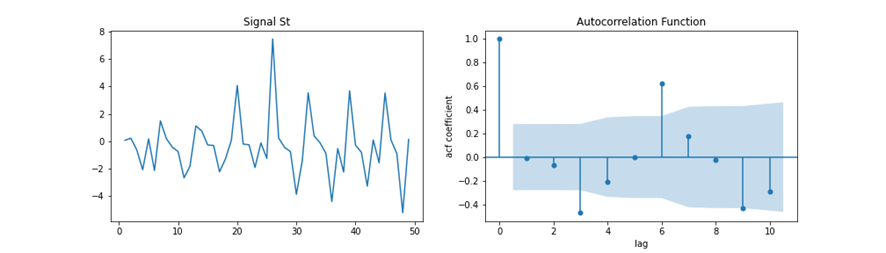

## **ARMA Definition**
ARMA(p, q) is a combination of AR(p) and MA(q) models. For example, ARMA(3,3) of signal the St can be formulated as

`St = β0 + β1St-1 + β2St-2 + β3St-3 + ϵt + γ1ϵt-1 + γ2ϵt-2 + γ3ϵt-3`

where β, γ are coefficients and ϵ error. We already described the way of choosing order p and q in the section for AR and MA models.

## Since our search space is not big, **usually values p and q are not higher than 10**.
- We will only test values up to 10.

Notice that, for spikes in the limiar region of the 95% confidence interval, it is also interesting to analyze their decay rate: **when the inclination of the vertical values (decay rate of the autocorrelation) suddenly decreases, we should stop considering the influence of the lags** (i.e., we stop counting the lags when the derivative suddenly changes).
- For instance: there may be an abrupt change of derivative from lag = 6 in the ACF plot: the values of the ACF becomes approximately constant, and a baseline is reached. 

## p = spikes on PACF plot that are outside the error (blue region).
- For instance, if there are spikes in both lag = 1 and lag = 2, then p = 2, or p = 1.
    
## In its turn, q represents the lags where spikes of ACF plot that are outside blue region.
- For instance, if all spikes until lag = 6 are outside the blue region, then q = 1, 2, 3, 4, 5, 6.

## **Interpretation - Background**

To find the best combination (p,q), we can apply a popular technique for hyperparameter optimization called grid search. Grid search is simply an exhaustive search through a manually specified subset of the hyperparameter space of a learning algorithm. 
- Basically, it means that this method will try each combination of p and q from the specified subset that we provided.

Also, in order to find the best combination of p and q, we need to have some **objective function that will measure model performance on a validation set.**  
- Usually, we can use **AIC and BIC** for that purpose. 

#### **The lower the values of these criteria, the better the model is.**

### **Akaike Information Criteria (AIC)**
**AIC stands for Akaike Information Criteria, and it is a statistical measure that we can use to compare different models for their relative quality.** 
- It measures the quality of the model in terms of its goodness-of-fit to the data, its simplicity, and how much it relies on the tuning parameters. The formula for AIC is:

`AIC = 2k - 2l`
 
where l is a log-likelihood, and k is a number of parameters. For example, the AR(p) model has p+1 parameters.
- AIC prefers a **higher log-likelihood** that indicates how strong the model is in fitting the data, and a **simpler model in terms of parameters.**

### **Bayesian Information Criteria (BIC)**
In addition to AIC, the BIC (Bayesian Information Criteria) uses one more indicator **n that defines the number of samples used for fitting.** The formula for BIC is:

`BIC = klog(n) - 2l`
 
### **Cross-Validation for Time-Series**
Finally, since we are dealing with time series, we would need to utilize appropriate validation techniques for parameter tuning. This is important because we want to simulate the real-time behavior of the data flow. 
- For instance, it would not be correct to use a data sample xi to predict data sample xj, if xj comes before xi by time. That is because in real life we cannot use information from the future to predict data in real-time.
- Thus, one popular validation technique used for tuning time-series-based machine learning models is cross-validation for time-series. The goal is to see which hyperparameters of the model give the best results in terms of our selected measurement metric on the training data. Then, we use that model for future predictions.
For example, if our data consist of five time-points, we can make a train-test split as:
•	Training [1], Test [2]
•	Training [1, 2], Test [3]
•	Training [1, 2, 3], Test [4]
•	Training [1, 2, 3, 4], Test [5]
Of course, one time-point might not be enough as the starting training set, but instead of one, we can start with n starting points and follow the same logic.

# **ARIMA Models - Time Series Analysis Handbook - Background**

ARIMA models are built given the following key aspects:

**AR**: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.  
**I**: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.  
**MA**: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used:  
**p**: The number of lag observations included in the model, also called the lag order (_deals with **window** of $X\_t$_)  
**d**: The number of times that the raw observations are differenced, also called the degree of differencing (_deals with order of **differencing** of $X\_t$_)  
**q**: The size of the moving average window, also called the order of moving average (_deals with **residuals**_)

Given this, the general case of _**ARIMA(p,d,q)**_ can be written as:

\\begin{equation} X\_{t} = \\alpha _{1}X_{t-1} + \\dots + \\alpha _{p}X_{t-p} + \\varepsilon _{t}+\\theta_{1}\\varepsilon \_{t-1}+\\cdots +\\theta \_{q}\\varepsilon \_{t-q} \\end{equation}

Or in words :

**Predicted $X\_t$** = Constant + Linear combination of **Lags of $X$ (up to $p$ lags)** + Linear Combination of **Lagged forecast errors (up to q lags)**. Provided that the time-series is already **differenced (up to d terms)** to ensure stationarity.

#### Finding the order differencing _d_

As stated before, ARIMA models are assumed to be stationary. Implementing differencing may induce stationarity for various time series. The quickest way to determine _d_ for our models is to difference and simply run ADF to check for stationarity. We can also look at the PACF and ACF to see if our time series is stationary after _d_ differencing.

To illustrate, let's take a look at the following example:


Initial eyeballing shows that there is a trend for this time series and is non-stationary.  Checking the ADF:

```
from statsmodels.tsa.stattools import adfuller
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
```



```
ADF Statistic: -2.464240
p-value: 0.124419
```

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary. For our example, we fail to reject the null hypothesis.

Next we difference our time series and check the results of the ADF test. We will also look at the ACF.

```
plt.rcParams.update({'figure.figsize':(15,8), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

print('ADF Statistic for 1st Order Differencing')
result = adfuller(df.value.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

print('\n ADF Statistic for 2nd Order Differencing')
result = adfuller(df.value.diff().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
```

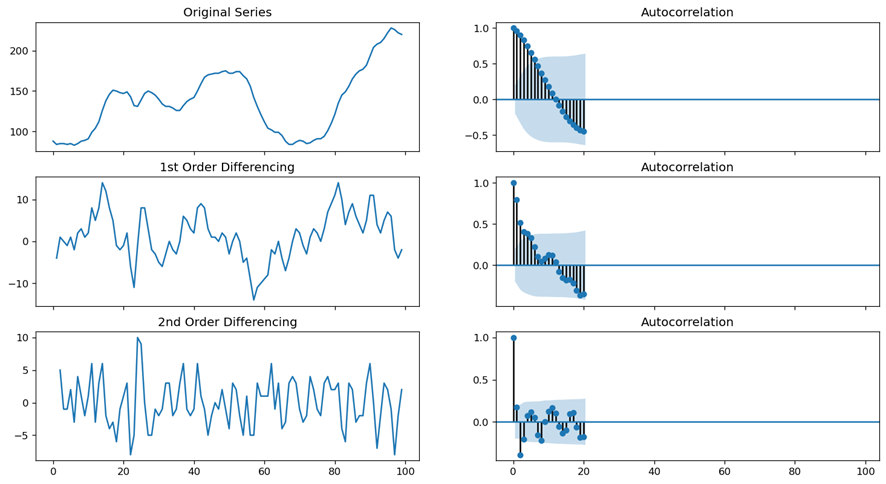

```
ADF Statistic for 1st Order Differencing
ADF Statistic: -2.722238
p-value: 0.070268
Critical Values:
    1%: -3.500
    5%: -2.892
    10%: -2.583

 ADF Statistic for 2nd Order Differencing
ADF Statistic: -9.929762
p-value: 0.000000
Critical Values:
    1%: -3.500
    5%: -2.892
    10%: -2.583

```

Given the results of our ACF and ADF, **we can see that our time series reaches stationarity after two orders of differencing. However, the ACF of the 2nd order differencing goes into the negative zone fairly quick. This can indicates that the series might have been over differenced. It is now up to us if we want consider the first or second order differencing for our ARIMA models.**

**\- Then, d = 1 or d = 2.**

\- If d = 0, we are using ARMA model.

## **The value of "d" corresponds to the total of differentiations for making the process stationary.**

# **Time series seasonal decomposition - Background**

- decomposition_mode = "additive" - manipulate the parameter 'model' from seasonal_decompose.
- Alternatively, set decomposition_mode = "multiplicative" for decomposing as a multiplicative time series.

### **'additive' model**
- An additive model suggests that the components are added together as: 

`y(t) = Level + Trend + Seasonality + Noise`

- An additive model is linear where changes over time are consistently made by the same amount. 
- A linear trend is a straight line. 
- A linear seasonality has the same frequency (width of cycles) and amplitude (height of cycles).
    
### **'multiplicative' model** 
- A multiplicative model suggests that the components are multiplied together as:

`y(t) = Level * Trend * Seasonality * Noise`

- A multiplicative model is nonlinear, such as quadratic or exponential. Changes increase or decrease over time.
- A nonlinear trend is a curved line. 
- A non-linear seasonality has an increasing or decreasing frequency and/or amplitude over time.

Check:
https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/#:~:text=The%20statsmodels%20library%20provides%20an%20implementation%20of%20the,careful%20to%20be%20critical%20when%20interpreting%20the%20result